In [1]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import os
import sys
from matplotlib.patches import Patch


In [2]:
adata = sc.read_h5ad("/Users/shawnschulz/Documents/shared/glia_689_subset.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 689 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [4]:
sc.set_figure_params(dpi=100, dpi_save=1000)

## Load chosen glial cells and check

In [5]:
glial_metadata = pd.read_csv("~/Downloads/metadata_glial_sapiens.csv", skiprows=1,error_bad_lines=False)

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/735200341.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  glial_metadata = pd.read_csv("~/Downloads/metadata_glial_sapiens.csv", skiprows=1,error_bad_lines=False)


In [6]:
glial_metadata = glial_metadata.dropna(how='all')

In [7]:
glial_689 = pd.read_csv("~/Downloads/glial_metadata_638.csv")

In [8]:
glial_689

barcodes     orig.ident  \
0    CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10...  SeuratProject   
1                 ACGATGTTCGGCTGTG_TSP5_Eye_NA_10X_1_2  SeuratProject   
2                 AGATCCACAACAGCTT_TSP5_Eye_NA_10X_1_2  SeuratProject   
3                 AGGAGGTAGAAGGGAT_TSP5_Eye_NA_10X_1_2  SeuratProject   
4        TTGCTGCCATCCTTCG_TSP3_Eye_NA_10X_1_1_NoCornea  SeuratProject   
..                                                 ...            ...   
684  ATCCACCCAGGCTACC_TSP2_Lung_proxmedialdistal_10...  SeuratProject   
685  CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10...  SeuratProject   
686  CCATCACGTACCGGCT_TSP2_Muscle_rectusabdominus_1...  SeuratProject   
687               AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3  SeuratProject   
688  TSP2_Vasculature_aorta_SS2_B114585_B133324_Str...  SeuratProject   

       nCount_RNA  nFeature_RNA    organ_tissue     method donor  \
0     8895.472406          2418  Salivary_Gland        10X  TSP7   
1     7312.797163          2027             Eye        10X  TSP5   
2     8794.929395          2265             Eye        10X  TSP5   
3     6987.815597          1710             Eye        10X  TSP5   
4     6573.562315          2345             Eye        10X  TSP3   
..            ...           ...             ...        ...   ...   
684   7257.964557          3052            Lung        10X  TSP2   
685  11717.335180          6144            Lung        10X  TSP2   
686   6360.418425          1568          Muscle        10X  TSP2   
687  10518.289370          4336        Pancreas        10X  TSP1   
688   3848.437954           971     Vasculature  smartseq2  TSP2   

    anatomical_information  n_counts_UMIs  n_genes  \
0                  Parotid           4061     2418   
1                      NaN           5128     2027   
2                      NaN           5165     2265   
3                      NaN           3883     1710   
4                      NaN           7204     2345   
..                     ...            ...      ...   
684       proxmedialdistal          10836     3052   
685       proxmedialdistal          26046     6144   
686        rectusabdominus           2899     1568   
687               Exocrine          14998     4336   
688                    NaN          40203      971   

                     cell_ontology_class                      free_annotation  \
0                             fibroblast                           Fibroblast   
1                    limbal stromal cell                 limbal stromal cells   
2                    limbal stromal cell                 limbal stromal cells   
3                    limbal stromal cell                 limbal stromal cells   
4                    limbal stromal cell                 limbal stromal cells   
..                                   ...                                  ...   
684                   type ii pneumocyte                   type ii pneumocyte   
685                   myofibroblast cell                   myofibroblast cell   
686  skeletal muscle satellite stem cell  skeletal muscle satellite stem cell   
687             pancreatic stellate cell             pancreatic stellate cell   
688                           fibroblast                           fibroblast   

     manually_annotated compartment  gender  leiden  glial_highlight  \
0                  True     stromal  female      12  glia_candidates   
1                  True     stromal  female       2  glia_candidates   
2                  True     stromal  female       9  glia_candidates   
3                  True     stromal  female       4  glia_candidates   
4                  True     stromal  female       8  glia_candidates   
..                  ...         ...     ...     ...              ...   
684                True  epithelial  female      15  glia_candidates   
685                True     stromal  female       7  glia_candidates   
686                True     stromal  female       9  glia_candidates   
687       

## Annotate myelinating vs non-myelinating

In [9]:

myelinating_index = ["GGGTGTCAGTGCCAGA_TSP15_Eye_Sclera-etc_10X_2_1",
"TGATTCTAGCTGAGCA_TSP15_Eye_Sclera-etc_10X_2_1",
"TTCTCCTCATTCTTAC_TSP14_Thymus_NA_10X_2_1_5Prime",
"CCCTTAGAGACTAAGT_TSP1_bladder_3"]

adata.obs['glial_classes'] = 'non_myelinating'

adata.obs['glial_classes'] = adata.obs['glial_classes'].astype('category')

adata.obs['glial_classes'] = adata.obs['glial_classes'].cat.set_categories(['non_myelinating', 'myelinating', "terminal"])

adata.obs['glial_classes'].loc[myelinating_index] = 'myelinating'

## Annotate Glial vs Non-glial

In [10]:

glial_index = list(glial_metadata['Barcode_description'])

adata.obs['is_glial'] = 'Non-glial'

adata.obs['is_glial'] = adata.obs['is_glial'].astype('category')

adata.obs['is_glial'] = adata.obs['is_glial'].cat.set_categories(['Glial', 'Non-glial'])

adata.obs['is_glial'].loc[glial_index] = 'Glial'

In [11]:
adata.obs.to_csv("~/Downloads/053023_ts_glial_metadata.csv")

## Generate heatmaps

#### (DEPRECATED) initial for selection

In [ ]:
# Function for generating a heatmap for specififed tissue with clustering to id glial vs non glial
fp = "/Users/shawnschulz/Documents/shared/"
def initialHeatmap(adata, tissue):
    adata.obs['barcodes'] = adata.obs.index
    adata.obs.index = adata.obs.index.astype(str)
    def sub_genes(adata, tissue):
        sub = adata[adata.obs['organ_tissue']==tissue]
        sub = sub[:, [
"SOX10", "PLP1", "S100B", "NCAM1", "GFAP", "PLLP", "MPZ", "MBP", "PMP22", "CDKN1C", "SCN7A", "GFRA3", "APOE", "NRXN1", "COL1A1", "ACTA2", "EPCAM", "CDH1", "KRT5", "KRT14", "PTPRC", "ITGAM", "CD3E", "CD19", "MITF", "DCT", "MLANA", "PMEL", "TYR", "TYRP1"]]
        sub.obs['barcodes']=sub.obs.index
        sub.obs['barcodes']=sub.obs['barcodes'].astype('category')
        display(sub)
        return(sub)
    sub = sub_genes(adata,tissue)
   
    # Need a custom order before we can sourt the custom order
#    sub.obs['glial_classes'] = pd.Categorical(sub.obs['glial_classes'], categories=['terminal', 'myelinating', 'non-myelinating'], ordered=True)
 #   sub = sub[sub.obs.sort_values(['glial_classes']).index]
 #   glial_class_col = sub.obs["glial_classes"]

  #  lut = {'non_myelinating': '#F8766D', 'myelinating': '#619CFF', 'terminal': '#00BA38'}
 #   row_colors = glial_class_col.map(lut).to_numpy()
 #   print(glial_class_col)
 #   print(row_colors)
    # Generate the heatmap and adjust tick labels
#    sub = sub.copy().T
    heatmap = sns.clustermap(sub.X.todense(), yticklabels = list(sub.obs['barcodes']), xticklabels= list(sub.var.index),col_cluster = False, row_cluster = True, cmap='RdYlBu_r')
#    heatmap = sns.clustermap(sub.X.todense(), yticklabels = list(sub.var.index), xticklabels= list(sub.obs.index),col_cluster = False, row_cluster = False, cmap='RdYlBu_r', row_colors=row_colors)

    heatmap.tick_params(axis='both', which='major', labelsize=3)
   
    # Legend for glial_class
  #  handles = [Patch(facecolor=lut[name]) for name in lut]
   # plt.legend(handles, lut, title='glial_highlight', bbox_to_anchor=(0.7, 1),
    #           bbox_transform=plt.gcf().transFigure, loc='upper right')
    fig = heatmap.fig
    fig.savefig(fp + "ts_" + tissue + "_all_adata_heatmap.pdf")
   
    display(fig)

In [ ]:
for tissue in np.unique(adata.obs['organ_tissue']):
    initialHeatmap(adata, tissue)

#### Glial vs non glial

In [21]:
# Function for generating a heatmap for specified tissue showing glial vs non glial
fp = "/Users/shawnschulz/Documents/shared/"
def nonGlialHeatmap(adata, tissue):
    adata.obs['barcodes'] = adata.obs.index
    adata.obs.index = adata.obs.index.astype(str)
    def sub_genes(adata, tissue):
        sub = adata[adata.obs['organ_tissue']==tissue]
        sub = sub[:, ["SOX10", "PLP1", "S100B", "GPM6B", "PRNP", "CRYAB", "CDH19", "KCNA1", "IGFBP7", "SCN7A", "GFRA3", "APOE", "CLDN19", "PRX", "PLLP", "BCAS1", "MBP", "MPZ", "TINAGL1", "GPC3", "BCHE", "CPM", "PLA2G7", "KCNN4", "IGFBP4", "SOD3"]]
        sub.obs['barcodes']=sub.obs.index
        sub.obs['barcodes']=sub.obs['barcodes'].astype('category')
        display(sub)
        return(sub)
    sub = sub_genes(adata,tissue)
   
    # Need a custom order before we can sourt the custom order
#    sub.obs['glial_classes'] = pd.Categorical(sub.obs['glial_classes'], categories=['terminal', 'myelinating', 'non-myelinating'], ordered=True)
    sub = sub[sub.obs.sort_values(['is_glial'], ascending= False).index]
    glial_class_col = sub.obs["is_glial"]

    lut = {'Glial': '#f7931d', 'Non-glial': '#bcbec0'}
    row_colors = glial_class_col.map(lut).to_numpy()
    print(glial_class_col)
    print(row_colors)
    # Generate the heatmap and adjust tick labels
#    sub = sub.copy().T
    heatmap = sns.clustermap(sub.X.todense(), yticklabels = list(sub.obs['barcodes']), xticklabels= list(sub.var.index),col_cluster = False, row_cluster = False, cmap='RdYlBu_r', row_colors=row_colors)
#    heatmap = sns.clustermap(sub.X.todense(), yticklabels = list(sub.var.index), xticklabels= list(sub.obs.index),col_cluster = False, row_cluster = False, cmap='RdYlBu_r', row_colors=row_colors)

    heatmap.tick_params(axis='both', which='major', labelsize=3)
   
    # Legend for glial_class
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='glial_highlight', bbox_to_anchor=(0.7, 1),
               bbox_transform=plt.gcf().transFigure, loc='upper right')
    fig = heatmap.fig
    fig.savefig(fp + "ts_" + tissue + "_glial_vs_non_glial_adata_heatmap.pdf")
   
    return glial_class_col

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 36 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
TATTCCAGTGGAATGC_TSP1_bladder_3                         Non-glial
AGGACGAAGAGAGCGG_TSP14_Bladder_NA_10X_1_1                   Glial
TTCTTGAAGACATAAC_TSP1_bladder_2                             Glial
CCGGGTAAGTGGCGAT_TSP2_Bladder_NA_10X_1_1                    Glial
CTCCAACTCCGTGTGG_TSP2_Bladder_NA_10X_1_1                    Glial
GAGGCAAAGCGCCTCA_TSP2_Bladder_NA_10X_1_1                    Glial
TAAGCACTCCTGATAG_TSP2_Bladder_NA_10X_1_1                    Glial
TGCAGGCGTGCCTTTC_TSP2_Bladder_NA_10X_1_1                    Glial
TGCATCCGTTCTCCTG_TSP2_Bladder_NA_10X_1_1                    Glial
ACACAGTGTTGACGGA_TSP2_Bladder_NA_10X_1_2                    Glial
ACCACAACAAATACGA_TSP2_Bladder_NA_10X_1_2                    Glial
ACTATGGTCTACTGAG_TSP2_Bladder_NA_10X_1_2                    Glial
CCTCTCCCAGTGTACT_TSP2_Bladder_NA_10X_1_2                    Glial
CGAGAAGGTGTTACAC_TSP2_Bladder_NA_10X_1_2                    Glial
CGATGCGAGAAACACT_TSP2_Bladder_NA_10X_1_2                    Glial
GA

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 17 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
CTATAGGCATCGATGT_TSP15_Eye_Cornea-etc_10X_1_1    Non-glial
GATCGTAAGACACACG_TSP5_Eye_NA_10X_1_1             Non-glial
GGTTGTATCACGACTA_TSP15_Eye_Cornea-etc_10X_1_1    Non-glial
ACGATGTTCGGCTGTG_TSP5_Eye_NA_10X_1_2                 Glial
GGGTGTCAGTGCCAGA_TSP15_Eye_Sclera-etc_10X_2_1        Glial
CTCTCGATCTCTGGTC_TSP15_Eye_Sclera-etc_10X_2_1        Glial
CAATGACGTCCACGCA_TSP15_Eye_Sclera-etc_10X_2_1        Glial
ATTCTACGTCATCCGG_TSP15_Eye_Sclera-etc_10X_2_1        Glial
ACACAGTGTGTAGTGG_TSP15_Eye_Sclera-etc_10X_2_1        Glial
CCCTCAAAGTCACAGG_TSP15_Eye_Cornea-etc_10X_1_1        Glial
AGATCCACAACAGCTT_TSP5_Eye_NA_10X_1_2                 Glial
AGGTGTTCAGCCTACG_TSP15_Eye_Cornea-etc_10X_1_1        Glial
GGCAGTCGTCTAGGTT_TSP5_Eye_NA_10X_1_1                 Glial
ATAGGCTGTGTTAACC_TSP5_Eye_NA_10X_1_1                 Glial
TTGCTGCCATCCTTCG_TSP3_Eye_NA_10X_1_1_NoCornea        Glial
AGGAGGTAGAAGGGAT_TSP5_Eye_NA_10X_1_2                 Glial
TGATTCTAGCTGAGCA_TSP15_Eye_Sclera-etc_10X_2_1   

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 543 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
AAACCCACATTCAGCA_TSP14_LI_Distal_10X_1_1      Non-glial
AGGGTGACATGGGAAC_TSP14_LI_Proximal_10X_1_1    Non-glial
ATGAAAGAGTATGGCG_TSP14_LI_Proximal_10X_1_1    Non-glial
ATCGTCCCAAATGAAC_TSP14_LI_Proximal_10X_1_1    Non-glial
ATCGTAGTCTCCACTG_TSP14_LI_Proximal_10X_1_1    Non-glial
                                                ...    
GACTCTCTCTGCGAGC_TSP14_LI_Distal_10X_1_1      Non-glial
GACTCTCCAACCGATT_TSP14_LI_Distal_10X_1_1      Non-glial
GACTCAACAAACTGCT_TSP14_LI_Distal_10X_1_1      Non-glial
GACCTTCCATCGAAGG_TSP14_LI_Distal_10X_1_1      Non-glial
TTTGGTTGTCAAGTTC_TSP14_LI_Proximal_10X_1_1    Non-glial
Name: is_glial, Length: 543, dtype: category
Categories (1, object): ['Non-glial']
['#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 '#bcbec0

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 3 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
ATCCACCCAGGCTACC_TSP2_Lung_proxmedialdistal_10X_1_2    Non-glial
GTTGTAGTCAAGTCTG_TSP2_Lung_proxmedialdistal_10X_1_1        Glial
CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10X_1_2        Glial
Name: is_glial, dtype: category
Categories (2, object): ['Glial', 'Non-glial']
['#bcbec0' '#f7931d' '#f7931d']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 2 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
TSP4_Muscle_rectusabdominus_SS2_B114867_B134050_MuscleStemCell_G7_L004    Non-glial
CCATCACGTACCGGCT_TSP2_Muscle_rectusabdominus_10X_1_1                      Non-glial
Name: is_glial, dtype: category
Categories (1, object): ['Non-glial']
['#bcbec0' '#bcbec0']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 4 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
ACTGCAAGTGACAGGT_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    Glial
AGGAATACAGACGATG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    Glial
CAGAGCCCACTAGAGG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    Glial
AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3                             Glial
Name: is_glial, dtype: category
Categories (1, object): ['Glial']
['#f7931d' '#f7931d' '#f7931d' '#f7931d']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 5 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
GCCCAGATCCTCTTTC_TSP8_Prostate_NA_10X_1_2                  Non-glial
TCCACCACATGACGTT_TSP8_Prostate_NA_10X_1_1                  Non-glial
TTGGTTTCAAGGGTCA_TSP8_Prostate_NA_10X_1_2                      Glial
ATGGTTGAGCCGTTGC_TSP8_Prostate_NA_10X_1_1                      Glial
TSP8_Prostate_NA_SS2_B134140_B134704_Epithelial_P2_L002        Glial
Name: is_glial, dtype: category
Categories (2, object): ['Glial', 'Non-glial']
['#bcbec0' '#bcbec0' '#f7931d' '#f7931d' '#f7931d']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 4 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
TSP7_Salivary_parotid_SS2_B134159_B133912_Epithelial_N22_S334    Non-glial
CACAGATAGCATGGGT_TSP14_SalivaryGland_Submandibular_10X_1_1       Non-glial
CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10X_1_1                  Glial
TGCATCCTCTGTCTCG_TSP14_SalivaryGland_Parotid_10X_1_1                 Glial
Name: is_glial, dtype: category
Categories (2, object): ['Glial', 'Non-glial']
['#bcbec0' '#bcbec0' '#f7931d' '#f7931d']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 61 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
AATTTCCAGATACCAA_TSP14_SI_Proximal_10X_1_1    Non-glial
ACGTAGTTCGCAGAGA_TSP14_SI_Proximal_10X_1_1    Non-glial
AGATCGTCATCAGCAT_TSP14_SI_Proximal_10X_1_1    Non-glial
AGCCAGCAGAAGGGAT_TSP14_SI_Proximal_10X_1_1    Non-glial
AGCGTATCAATGTCTG_TSP14_SI_Proximal_10X_1_1    Non-glial
                                                ...    
TATTGGGGTATGCAAA_TSP14_SI_Distal_10X_1_1      Non-glial
TCAGGTATCGACCAAT_TSP14_SI_Distal_10X_1_1      Non-glial
TCTGTCGGTACAAACA_TSP14_SI_Distal_10X_1_1      Non-glial
TGCCGAGCACGTACAT_TSP14_SI_Distal_10X_1_1      Non-glial
AAAGGATCACGTATAC_TSP14_SI_Distal_10X_1_1          Glial
Name: is_glial, Length: 61, dtype: category
Categories (2, object): ['Glial', 'Non-glial']
['#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0' '#bcbec0'
 

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 7 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
ACTTTCACATACTACG_TSP14_Thymus_NA_10X_2_1_5Prime    Glial
CTCGGAGCATCCGTGG_TSP14_Thymus_NA_10X_2_1_5Prime    Glial
GCTCTGTTCAGGTAAA_TSP14_Thymus_NA_10X_2_1_5Prime    Glial
TTCTCCTCATTCTTAC_TSP14_Thymus_NA_10X_2_1_5Prime    Glial
CAGATTGAGCTGGTGA_TSP14_Thymus_NA_10X_2_1           Glial
GTTACCCTCAACCTCC_TSP14_Thymus_NA_10X_2_1           Glial
TTCTAACAGAGCTTTC_TSP14_Thymus_NA_10X_2_1           Glial
Name: is_glial, dtype: category
Categories (1, object): ['Glial']
['#f7931d' '#f7931d' '#f7931d' '#f7931d' '#f7931d' '#f7931d' '#f7931d']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 6 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
AGGTGTTCAGCATCTA_TSP14_Tongue_Anterior_10X_1_1     Glial
CGATCGGTCCGCTGTT_TSP14_Tongue_Anterior_10X_1_1     Glial
CTGCGAGAGCTCACTA_TSP14_Tongue_Anterior_10X_1_1     Glial
GACCAATGTATTCTCT_TSP14_Tongue_Anterior_10X_1_1     Glial
TACGGTAAGCCTAACT_TSP14_Tongue_Anterior_10X_1_1     Glial
ATCCCTGGTCCTTGTC_TSP14_Tongue_Posterior_10X_1_1    Glial
Name: is_glial, dtype: category
Categories (1, object): ['Glial']
['#f7931d' '#f7931d' '#f7931d' '#f7931d' '#f7931d' '#f7931d']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_41064/3352745380.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 1 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

cell_id
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_O9_S81    Glial
Name: is_glial, dtype: category
Categories (1, object): ['Glial']
['#f7931d']


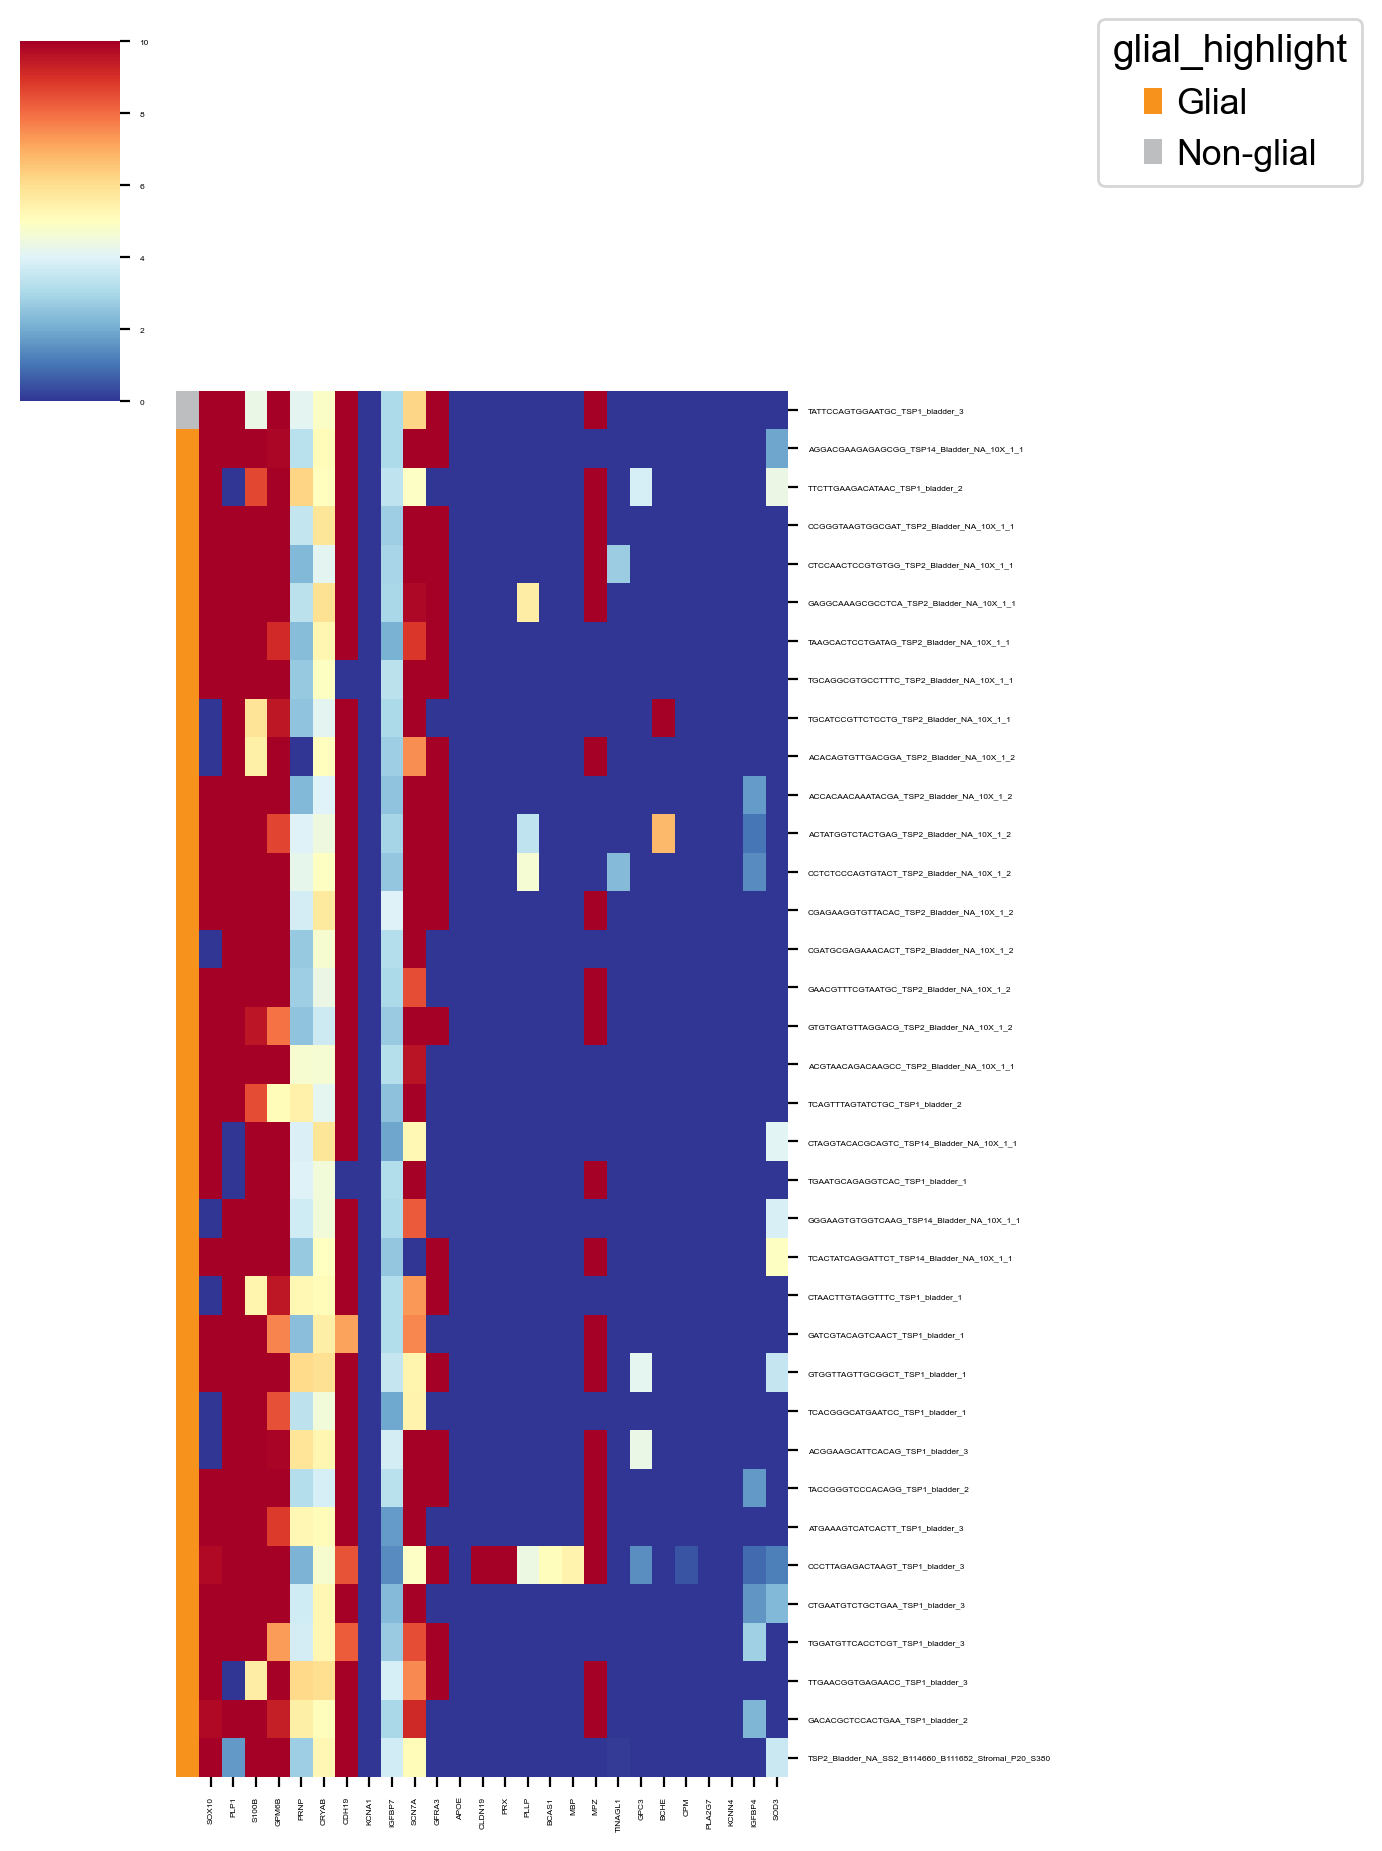

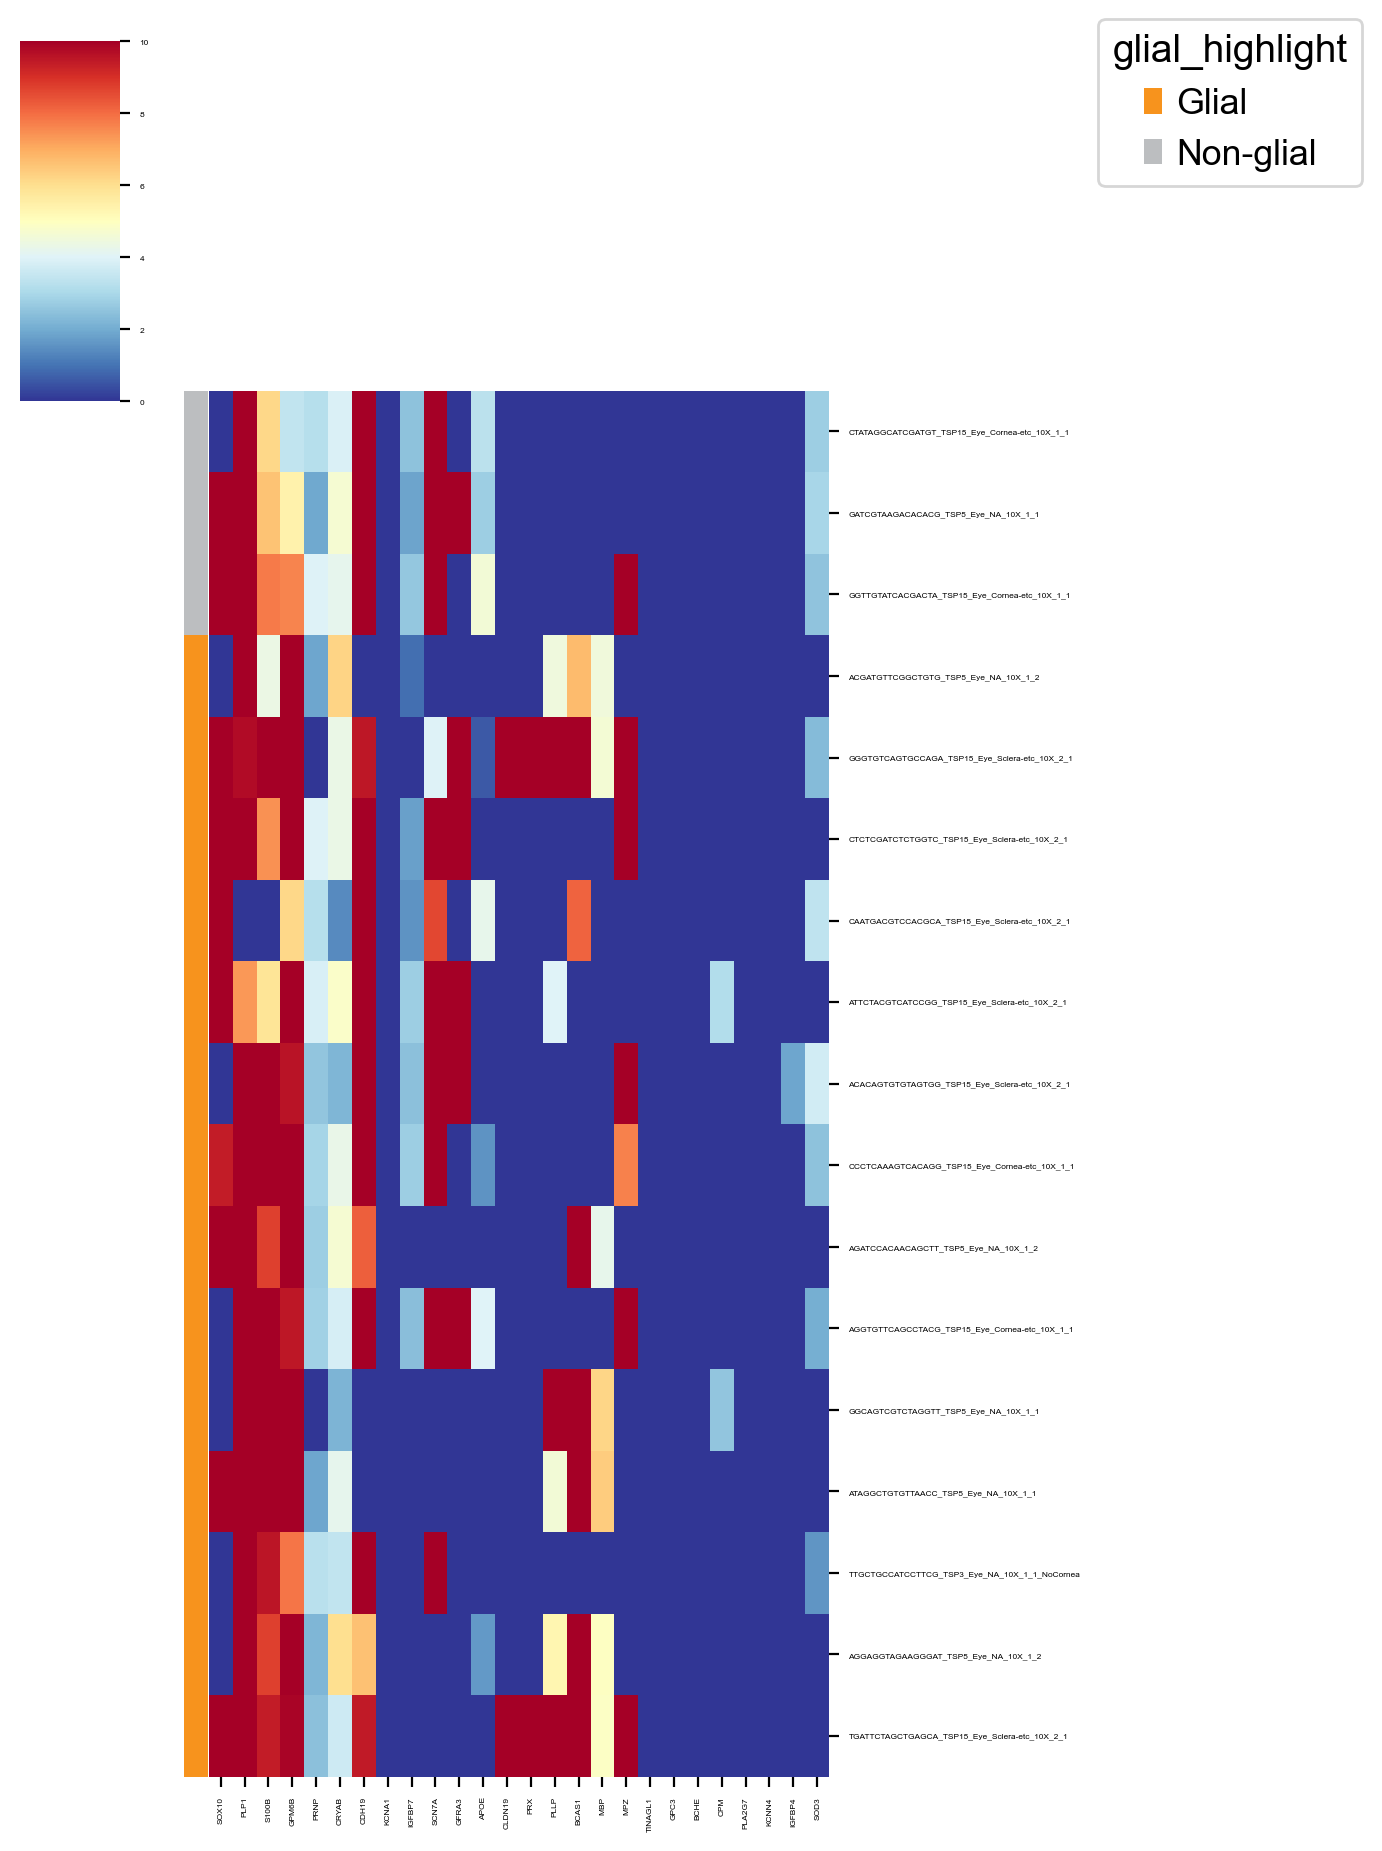

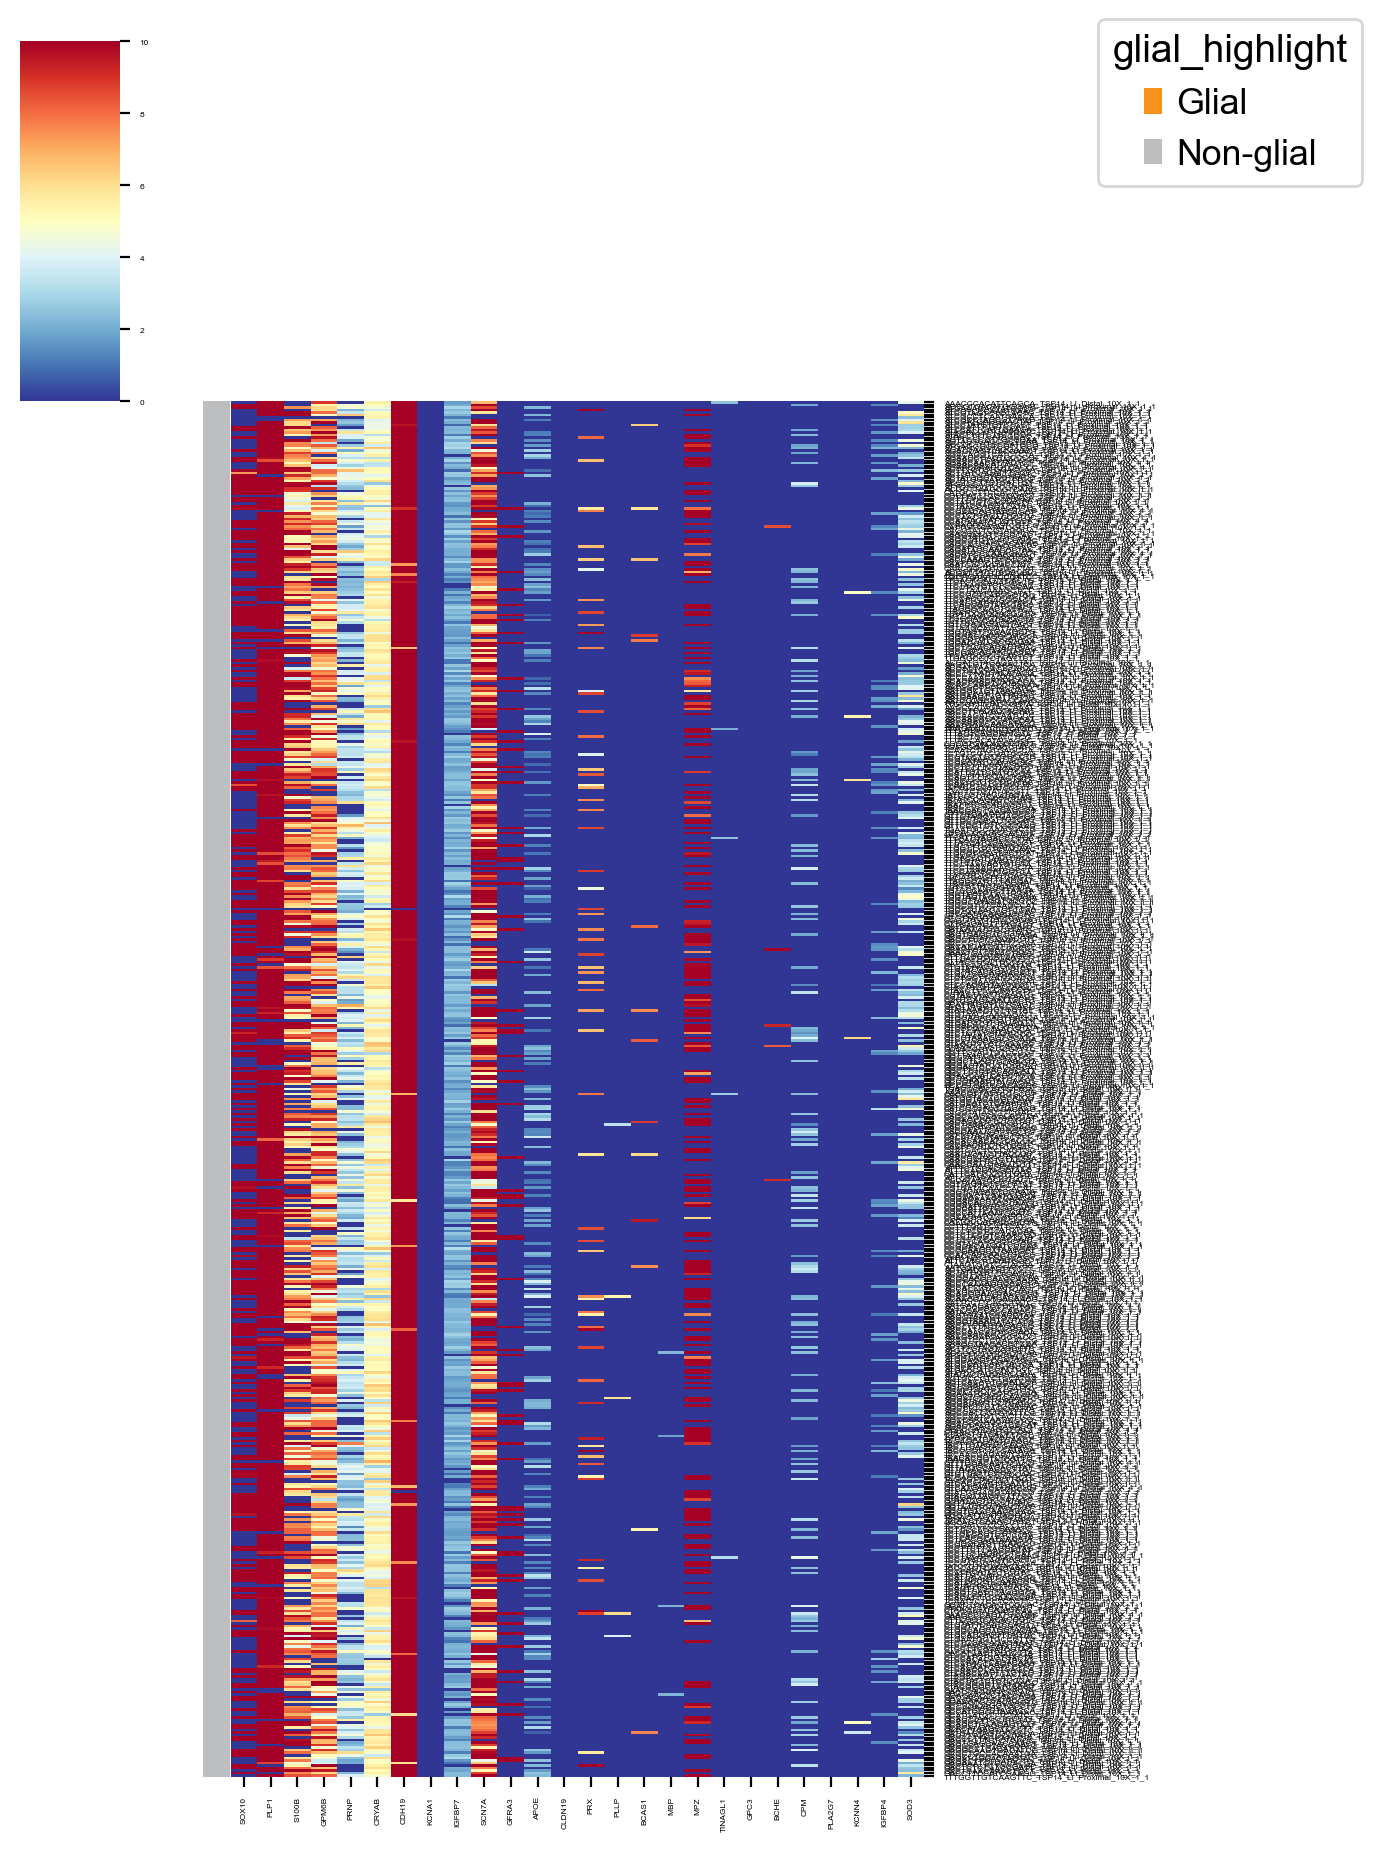

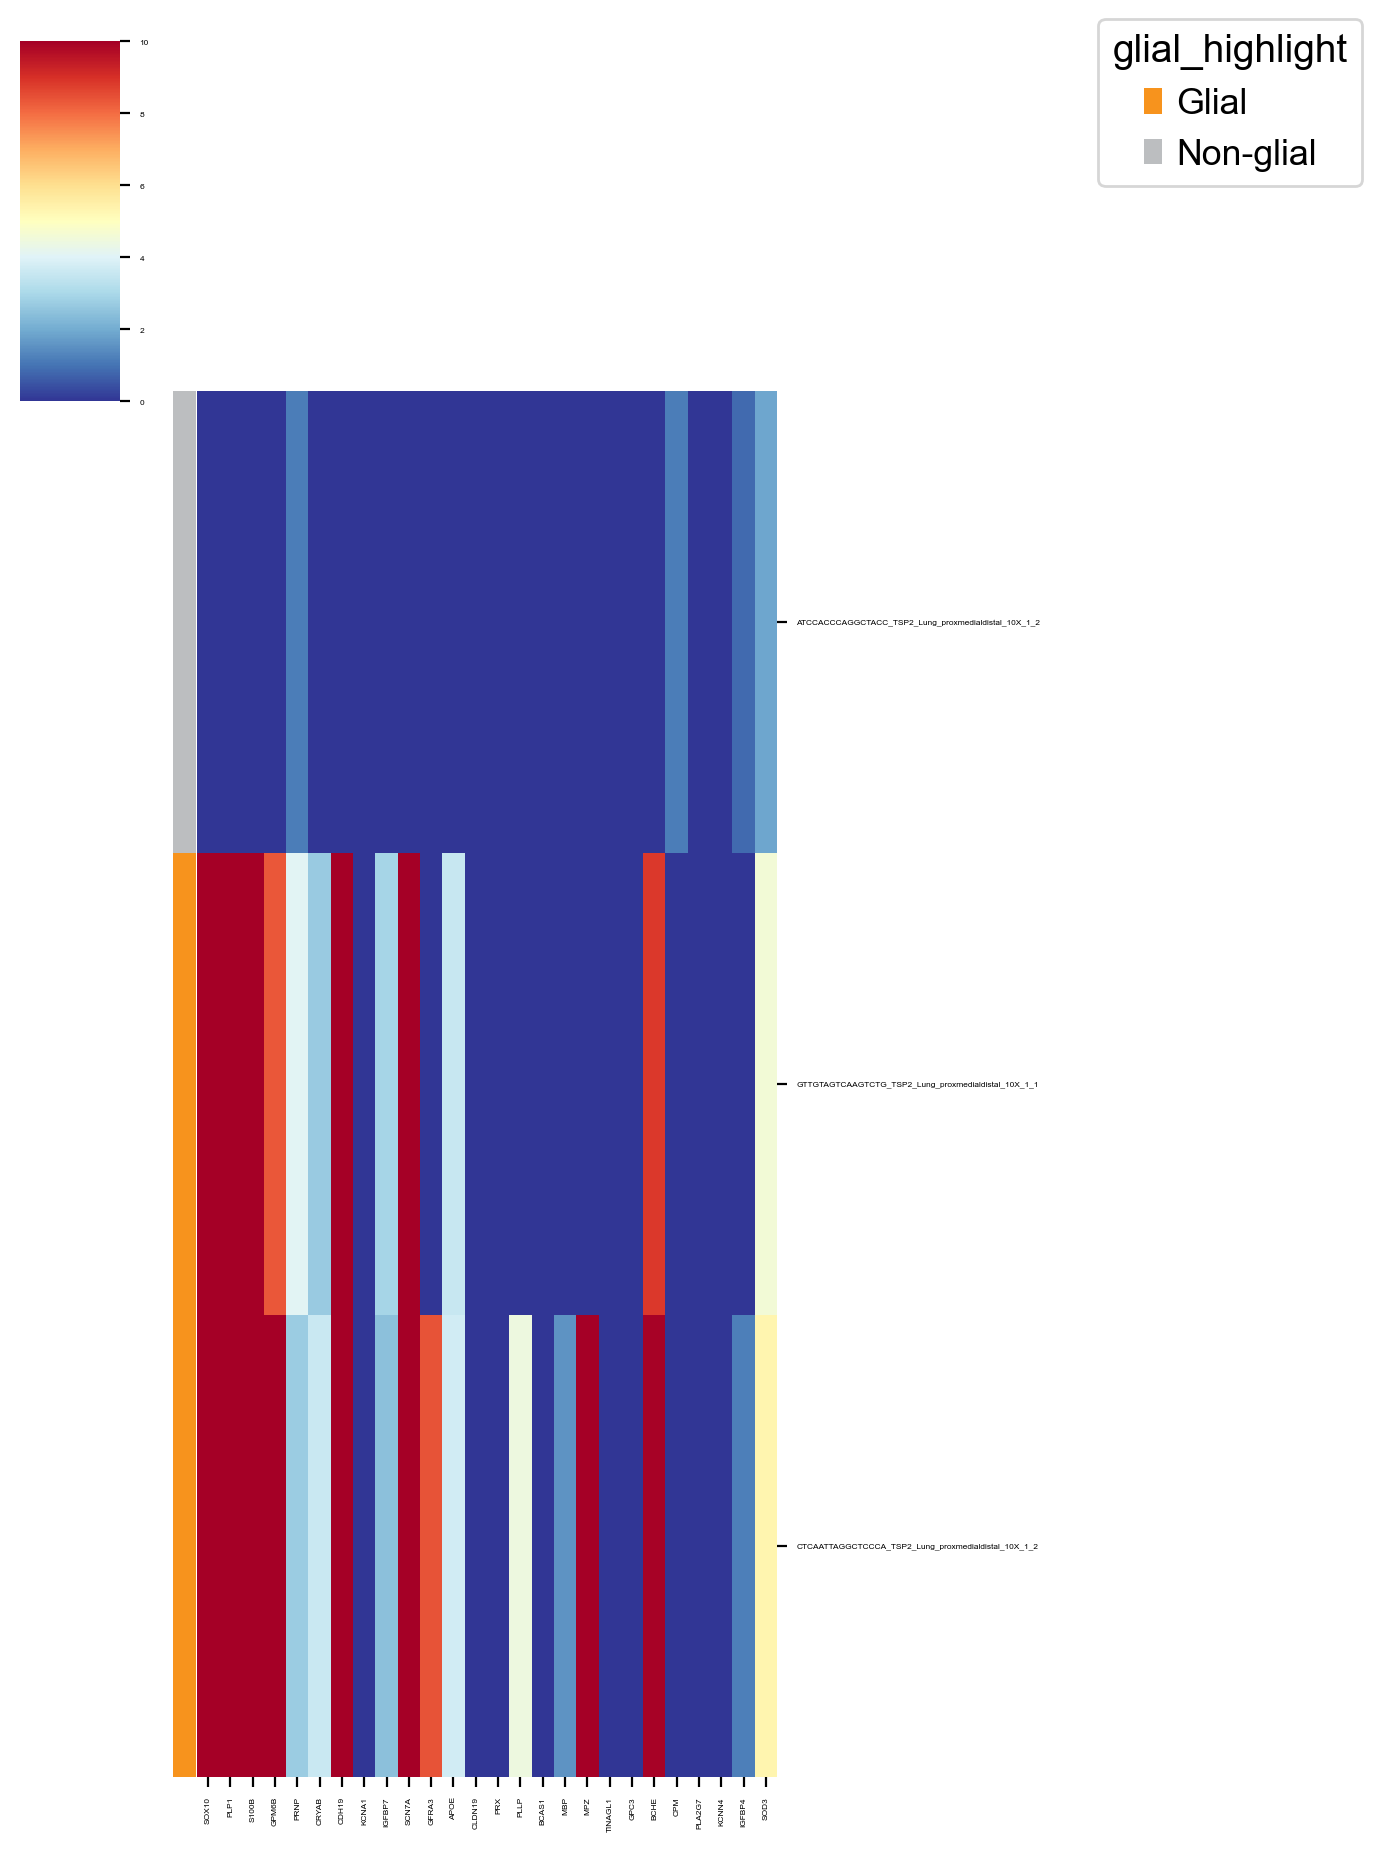

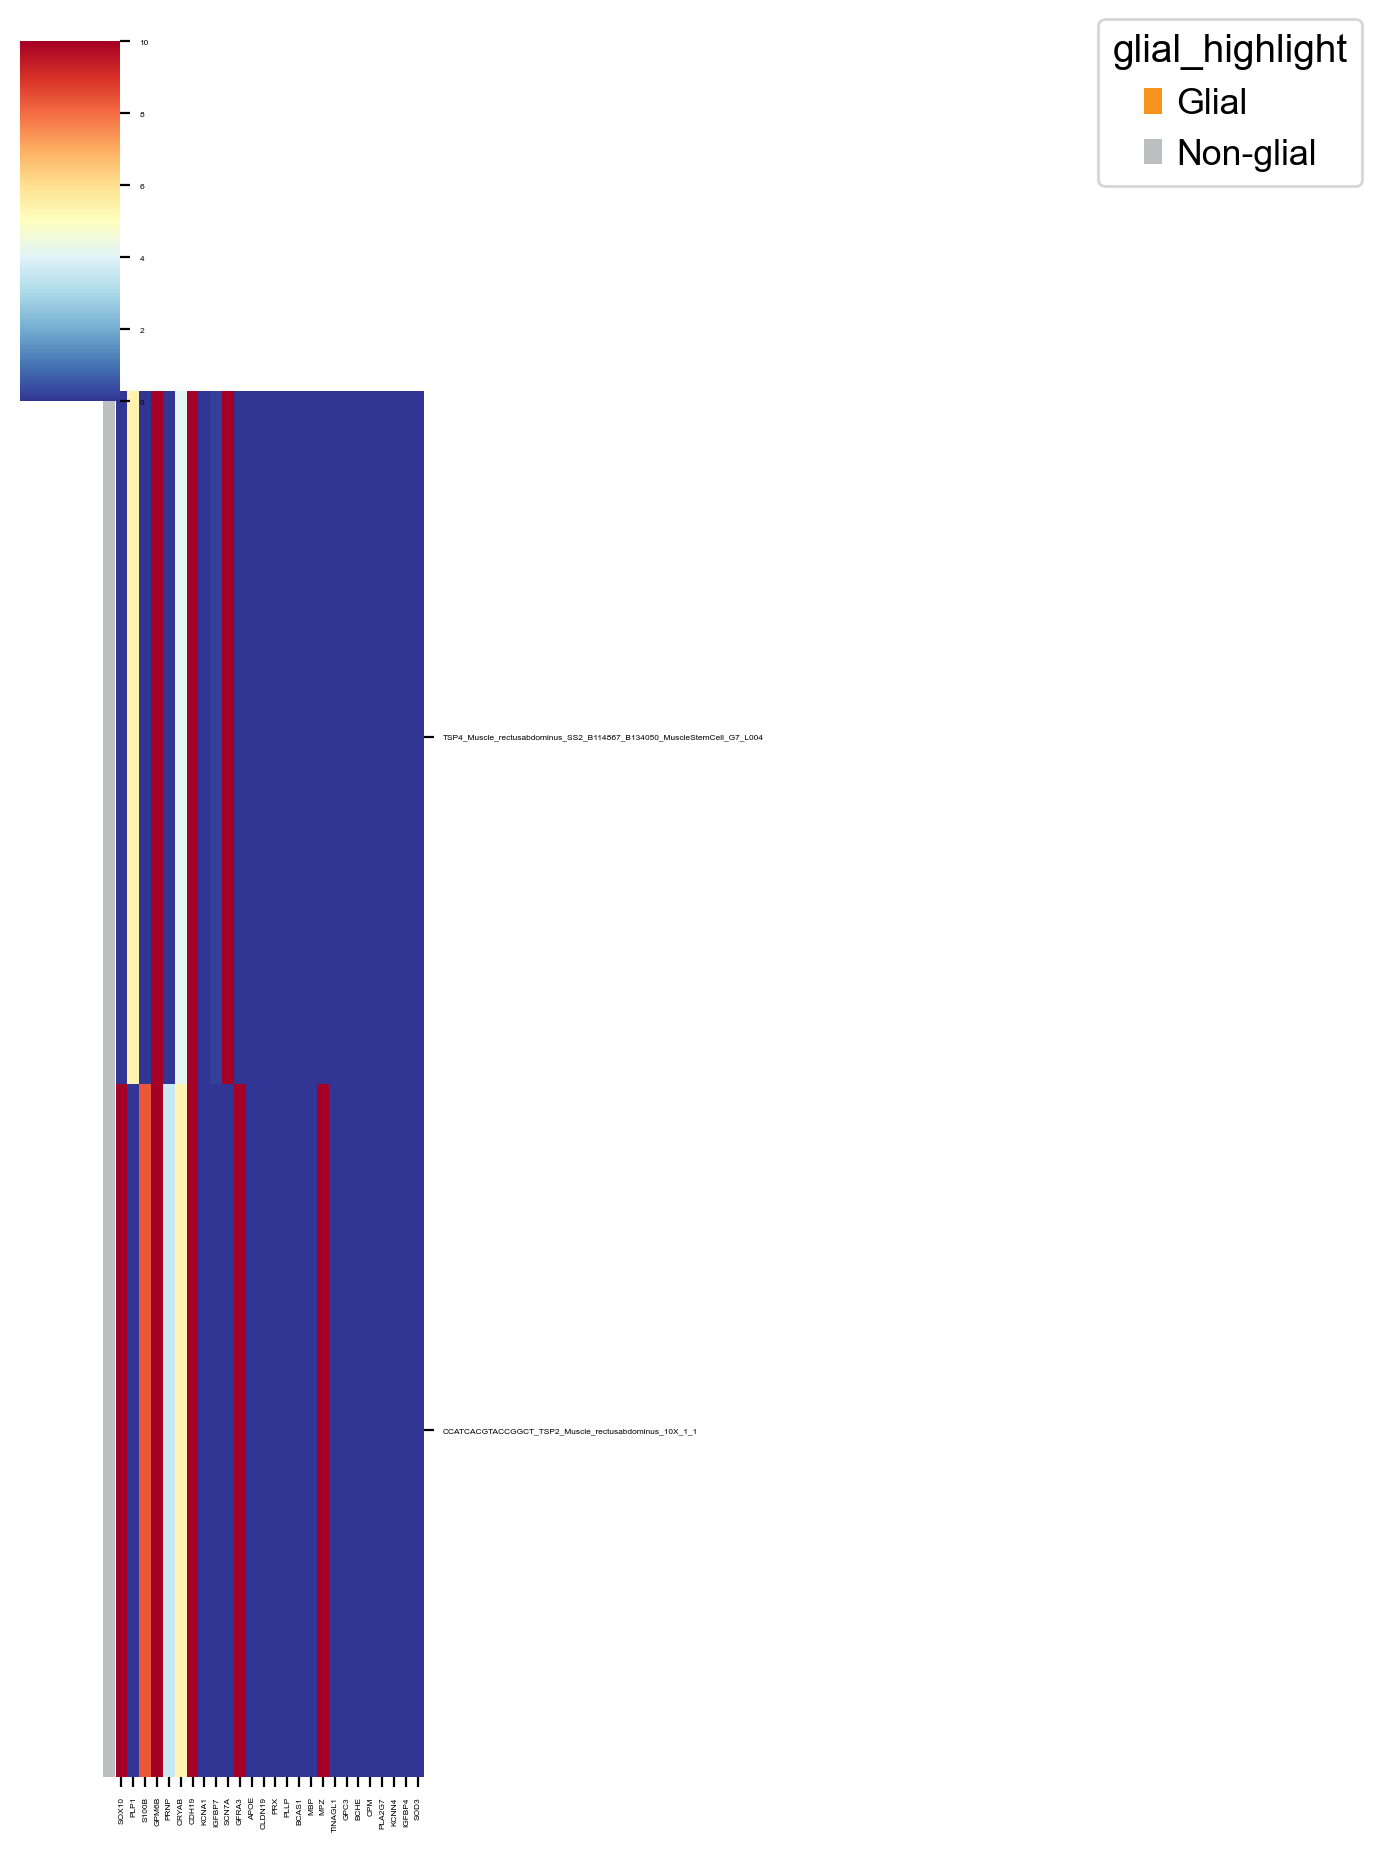

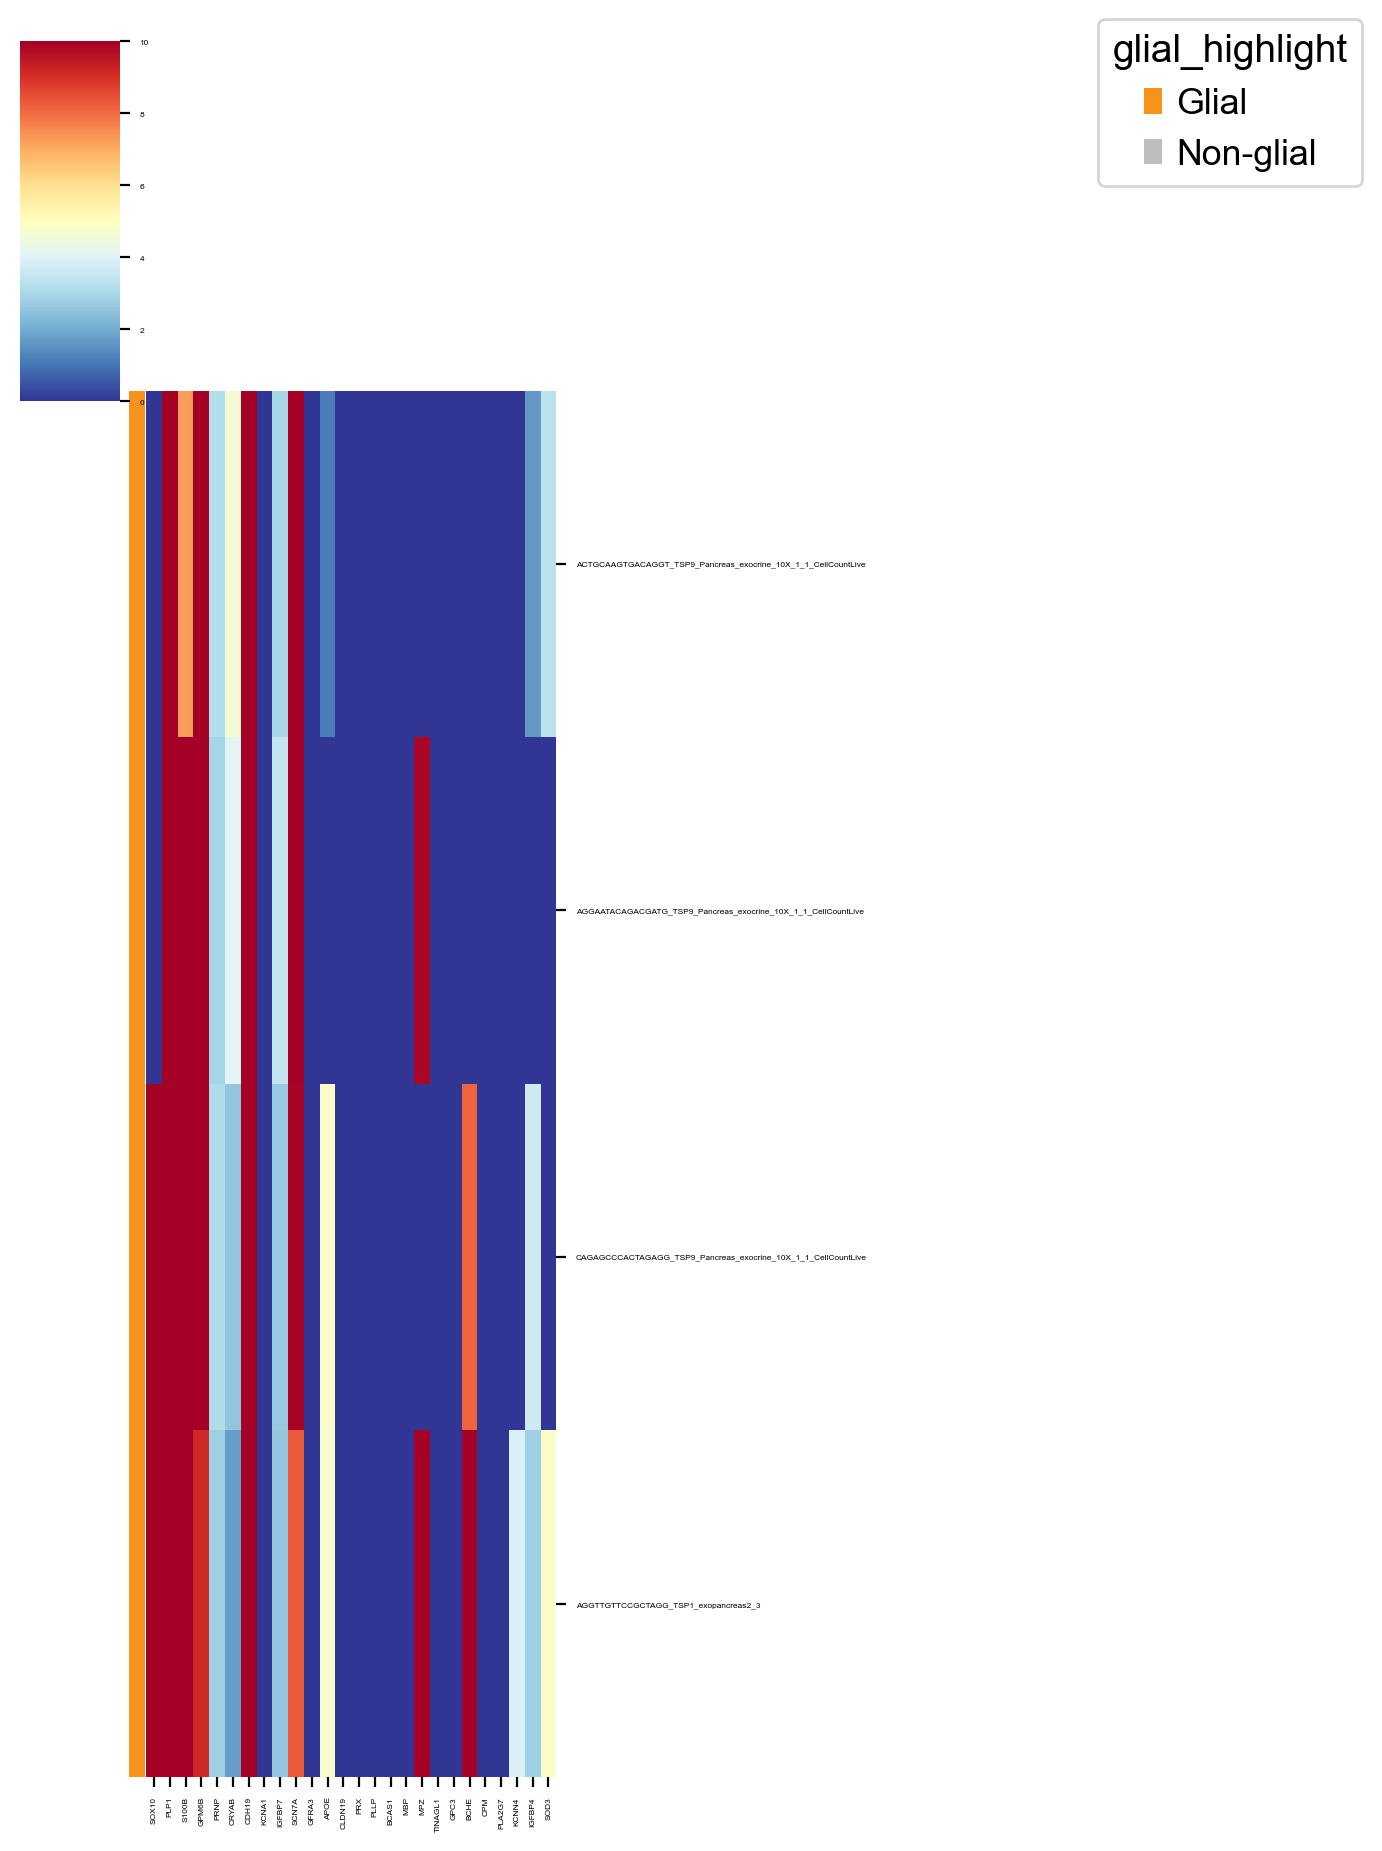

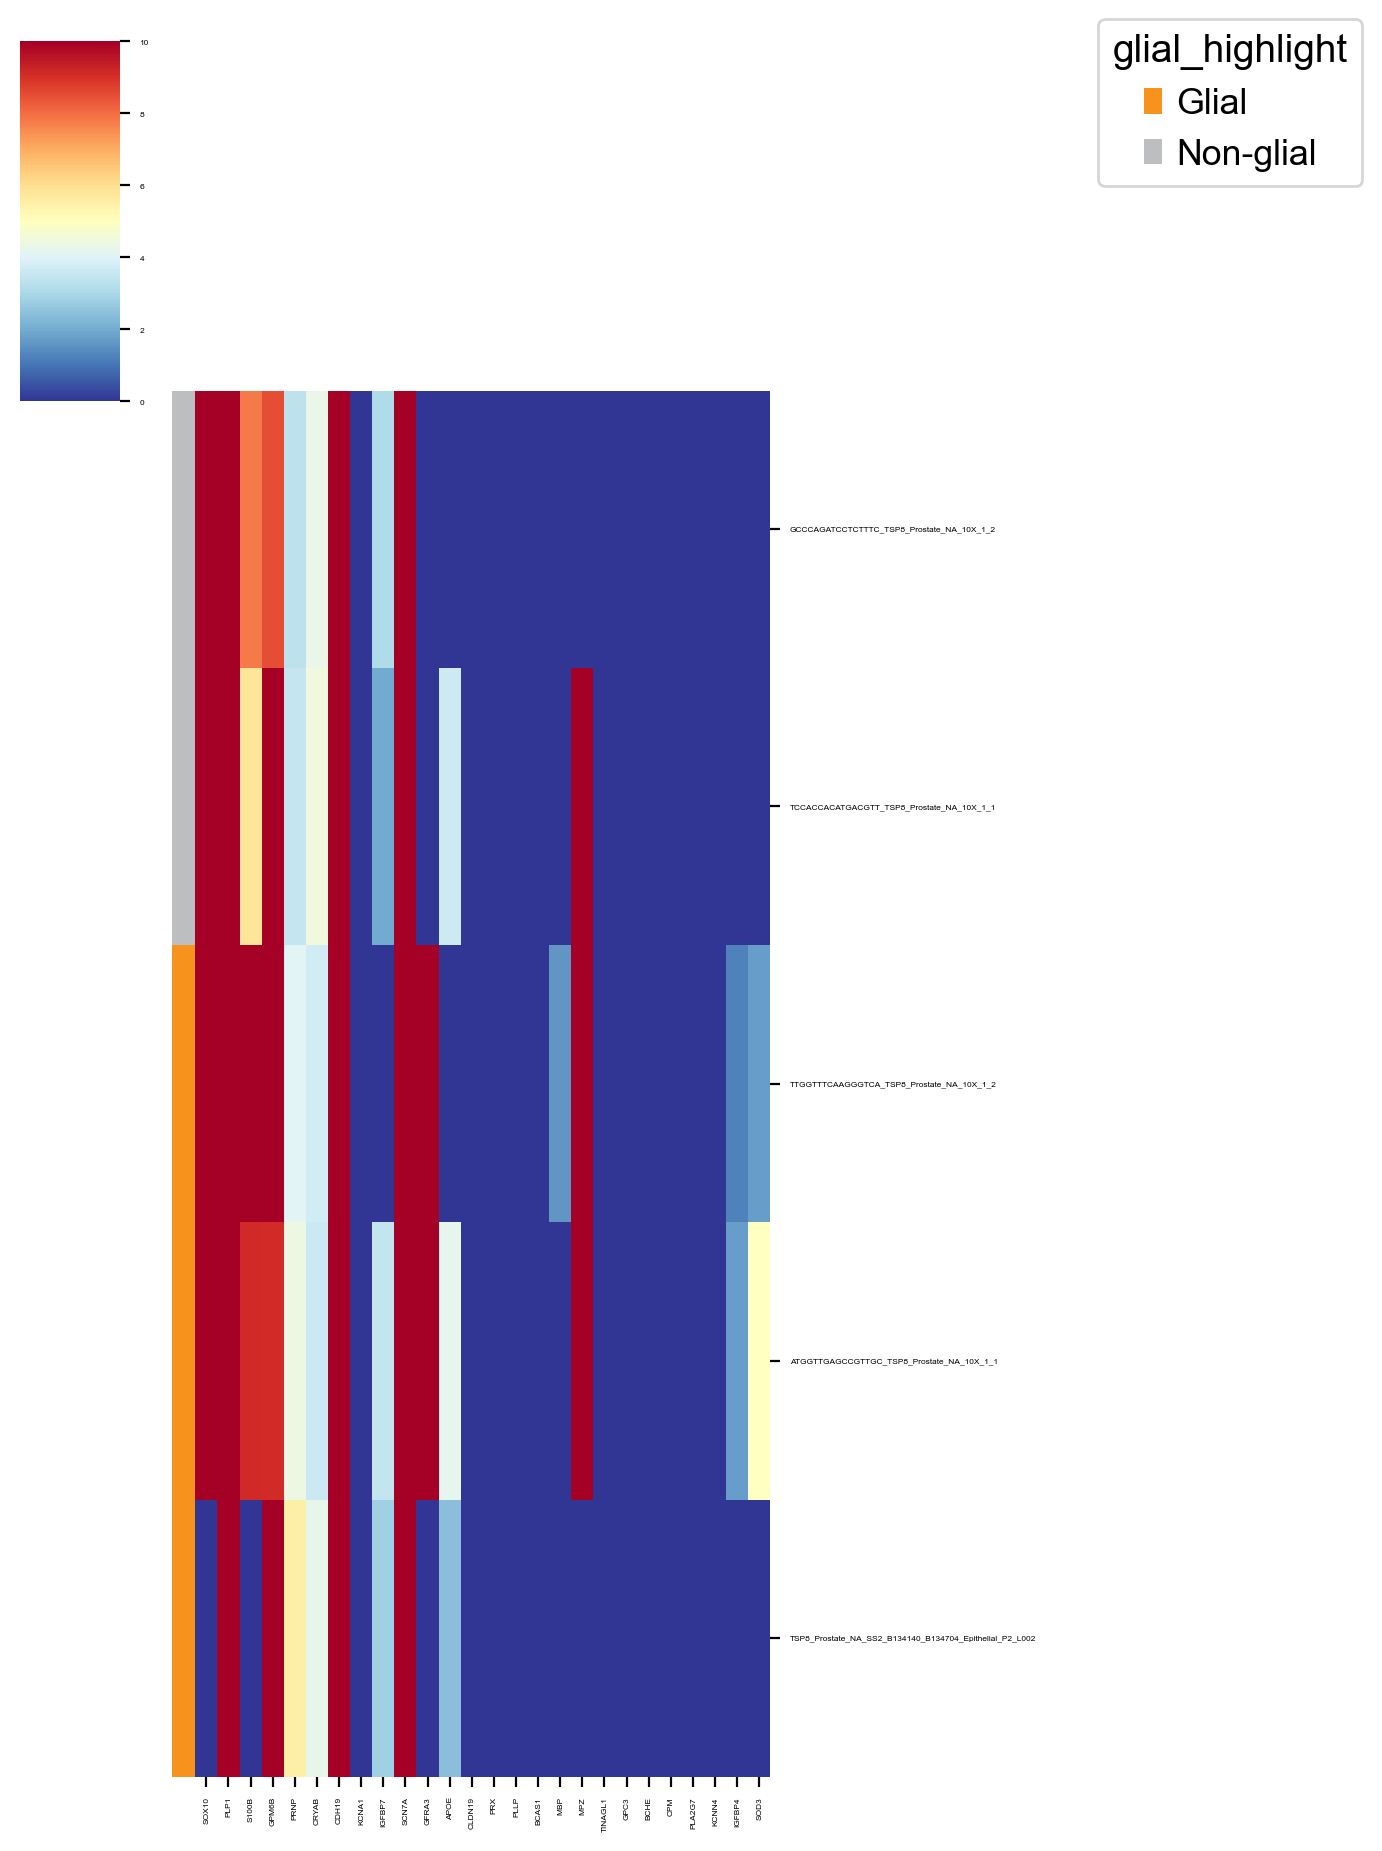

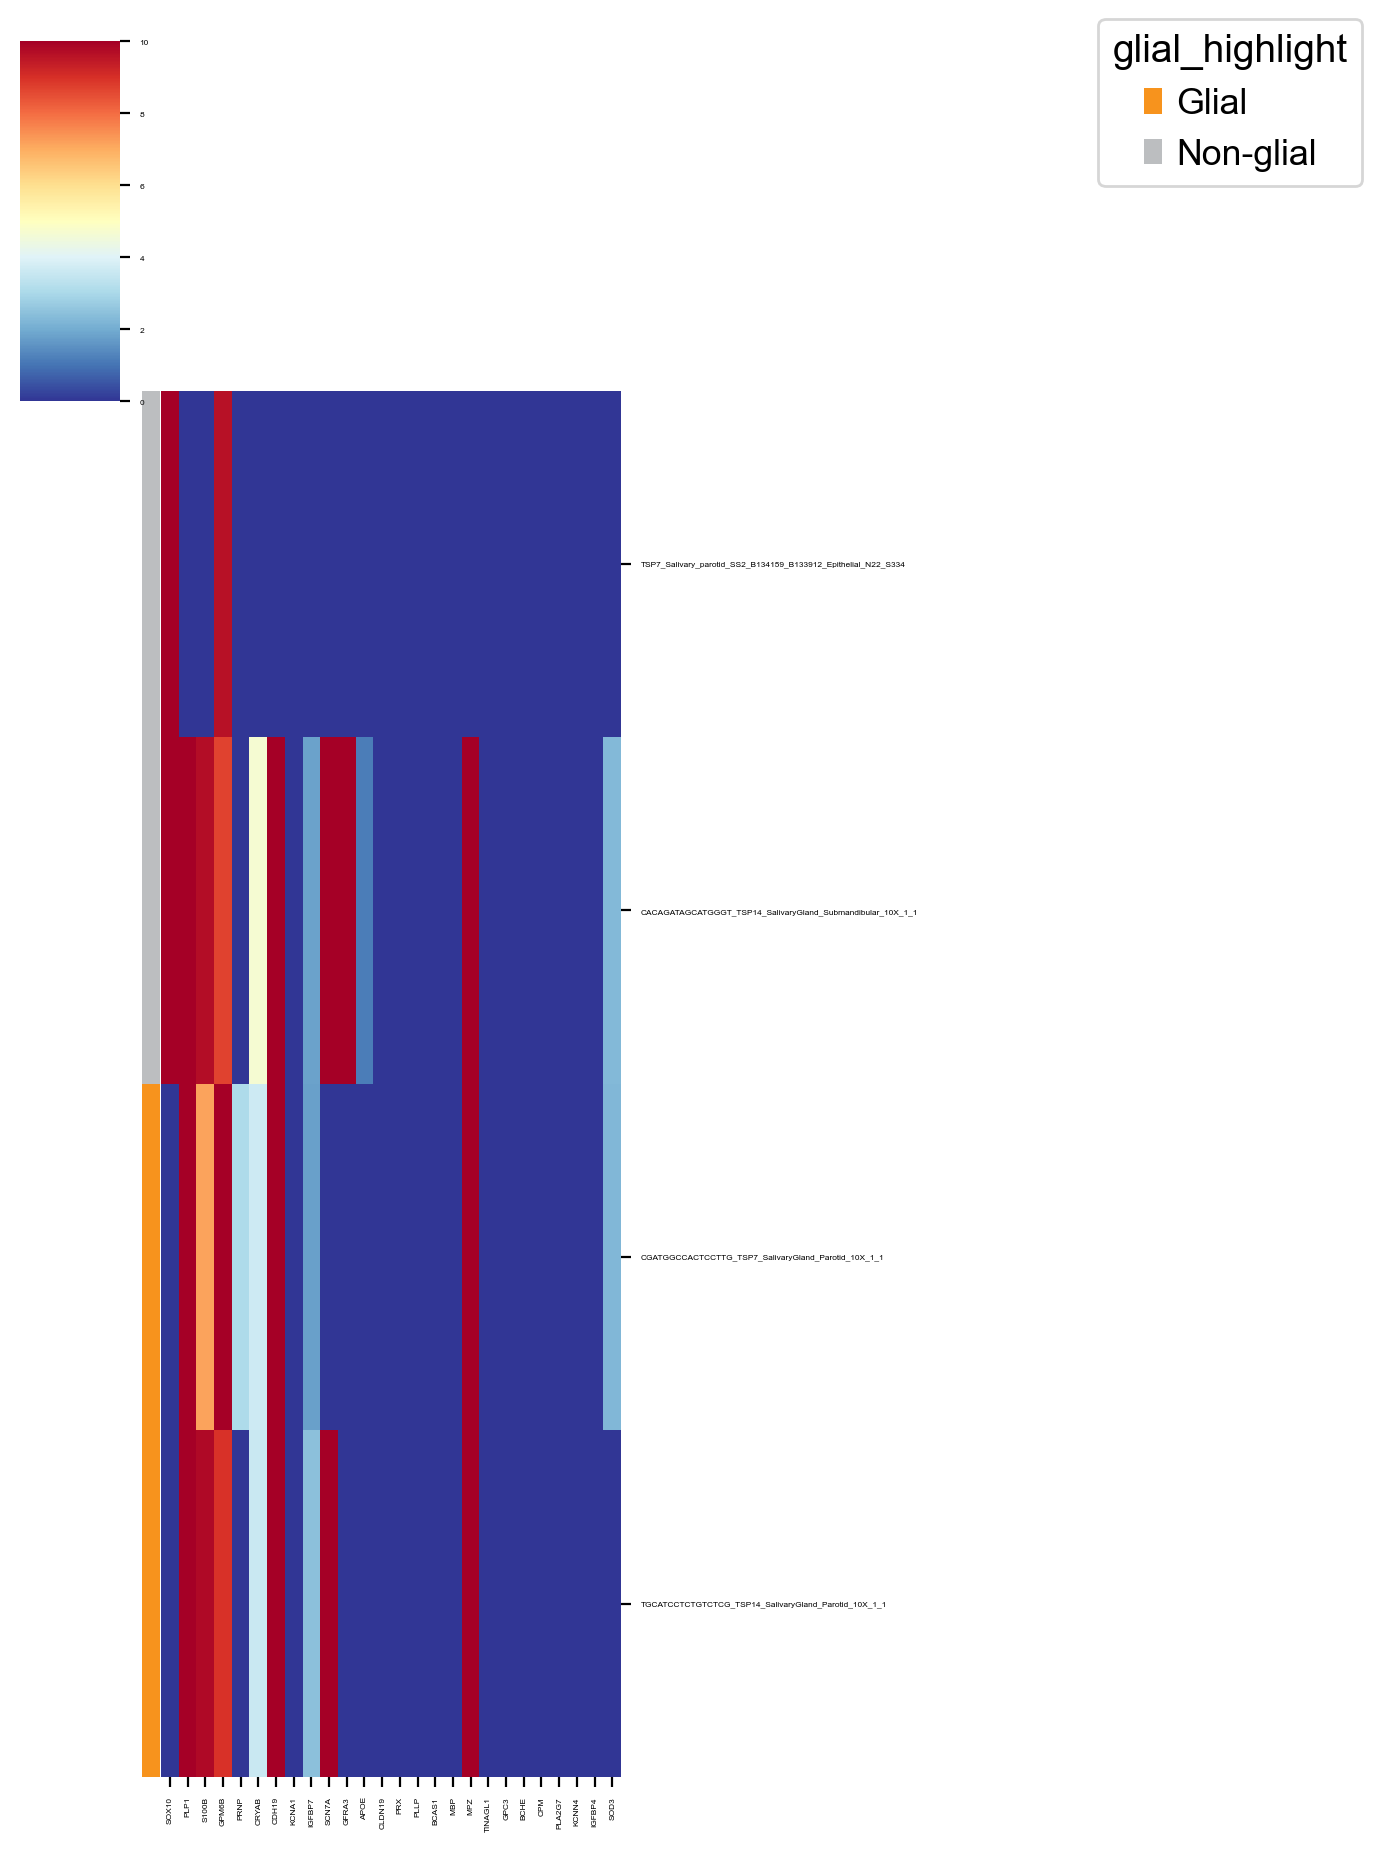

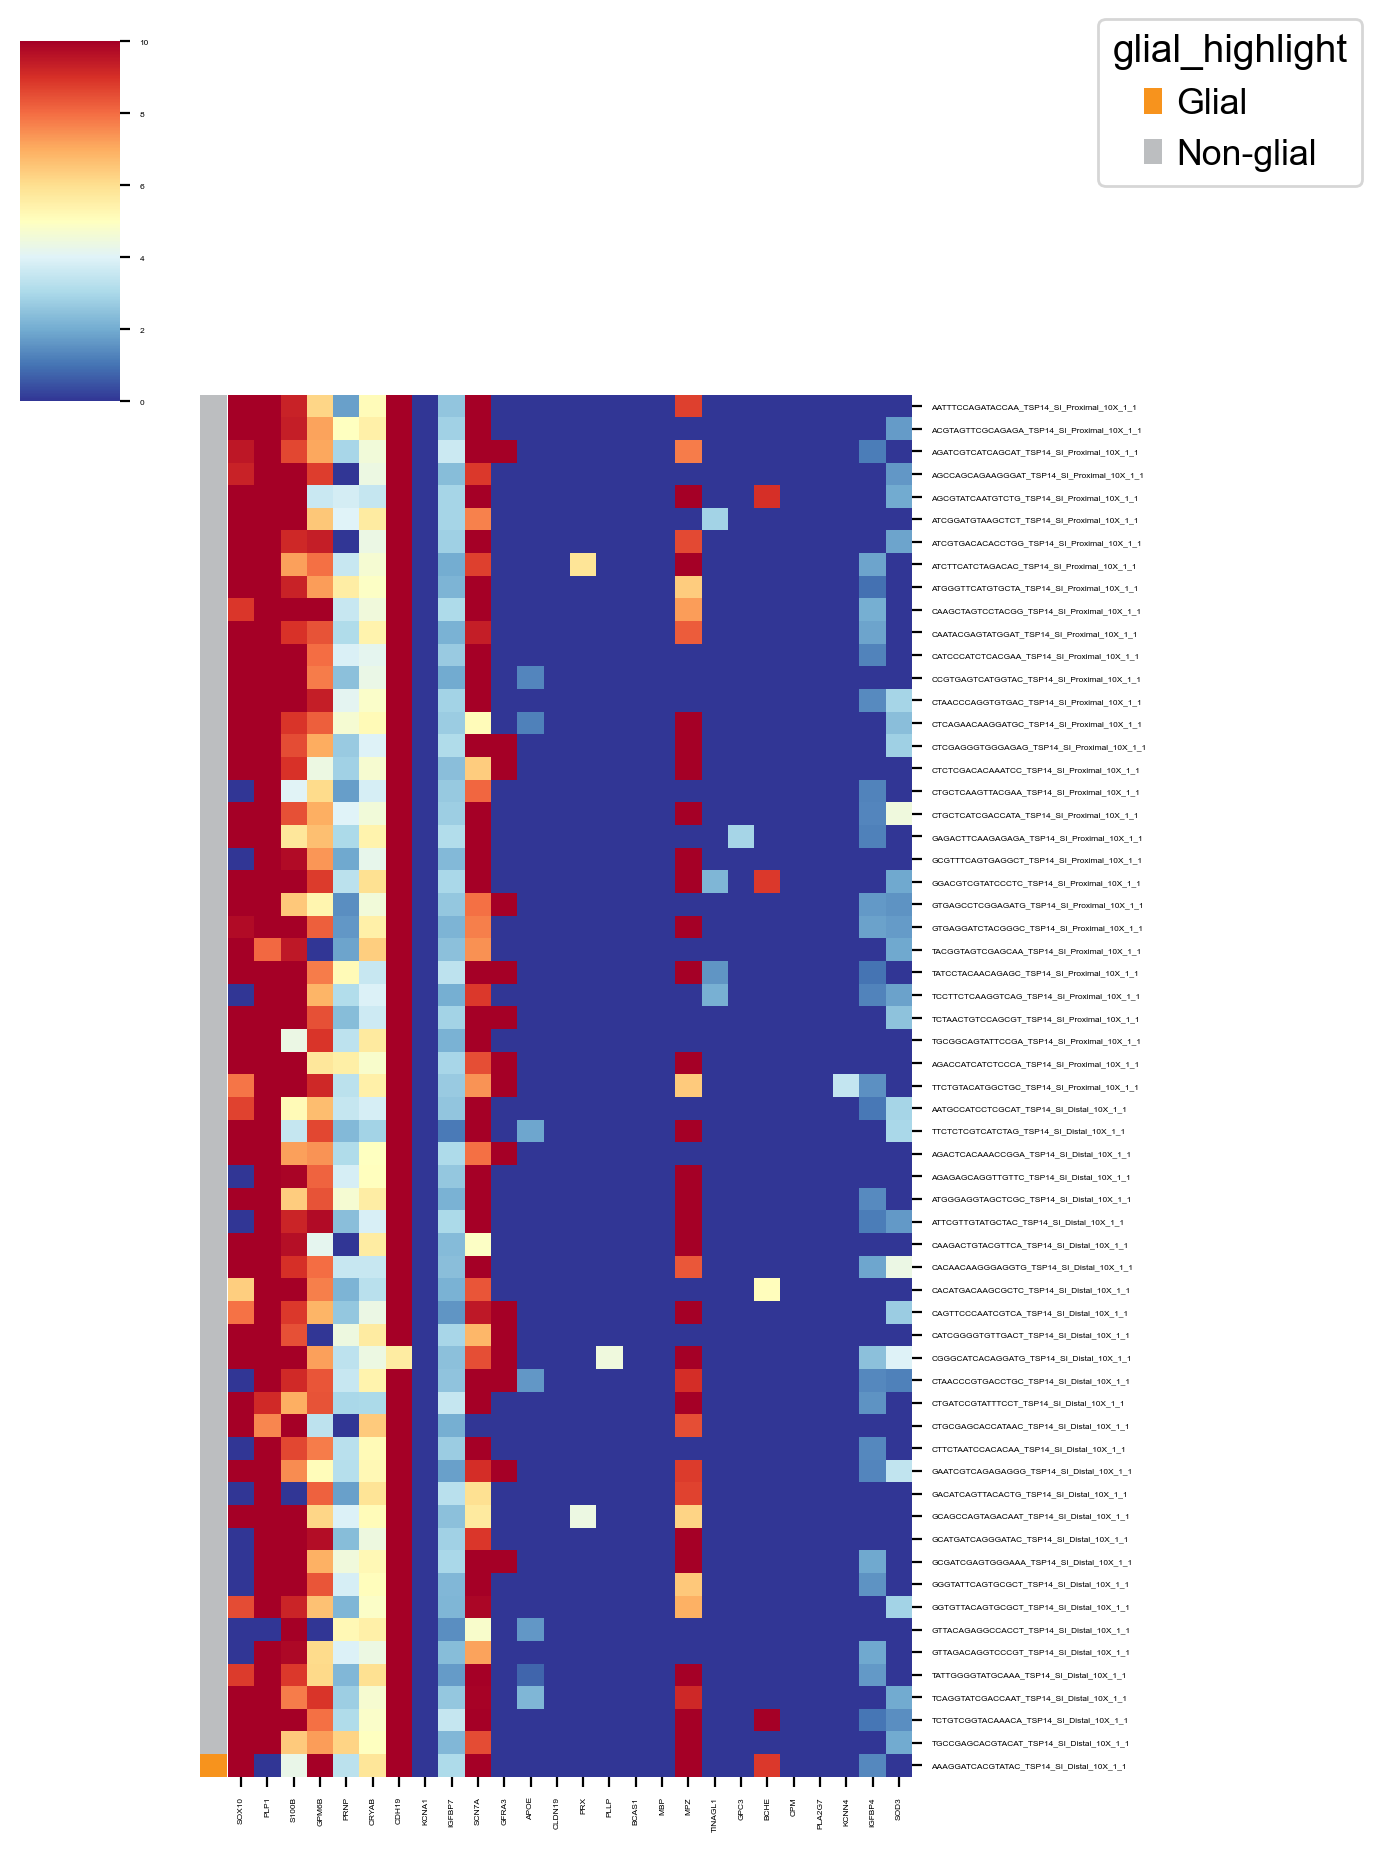

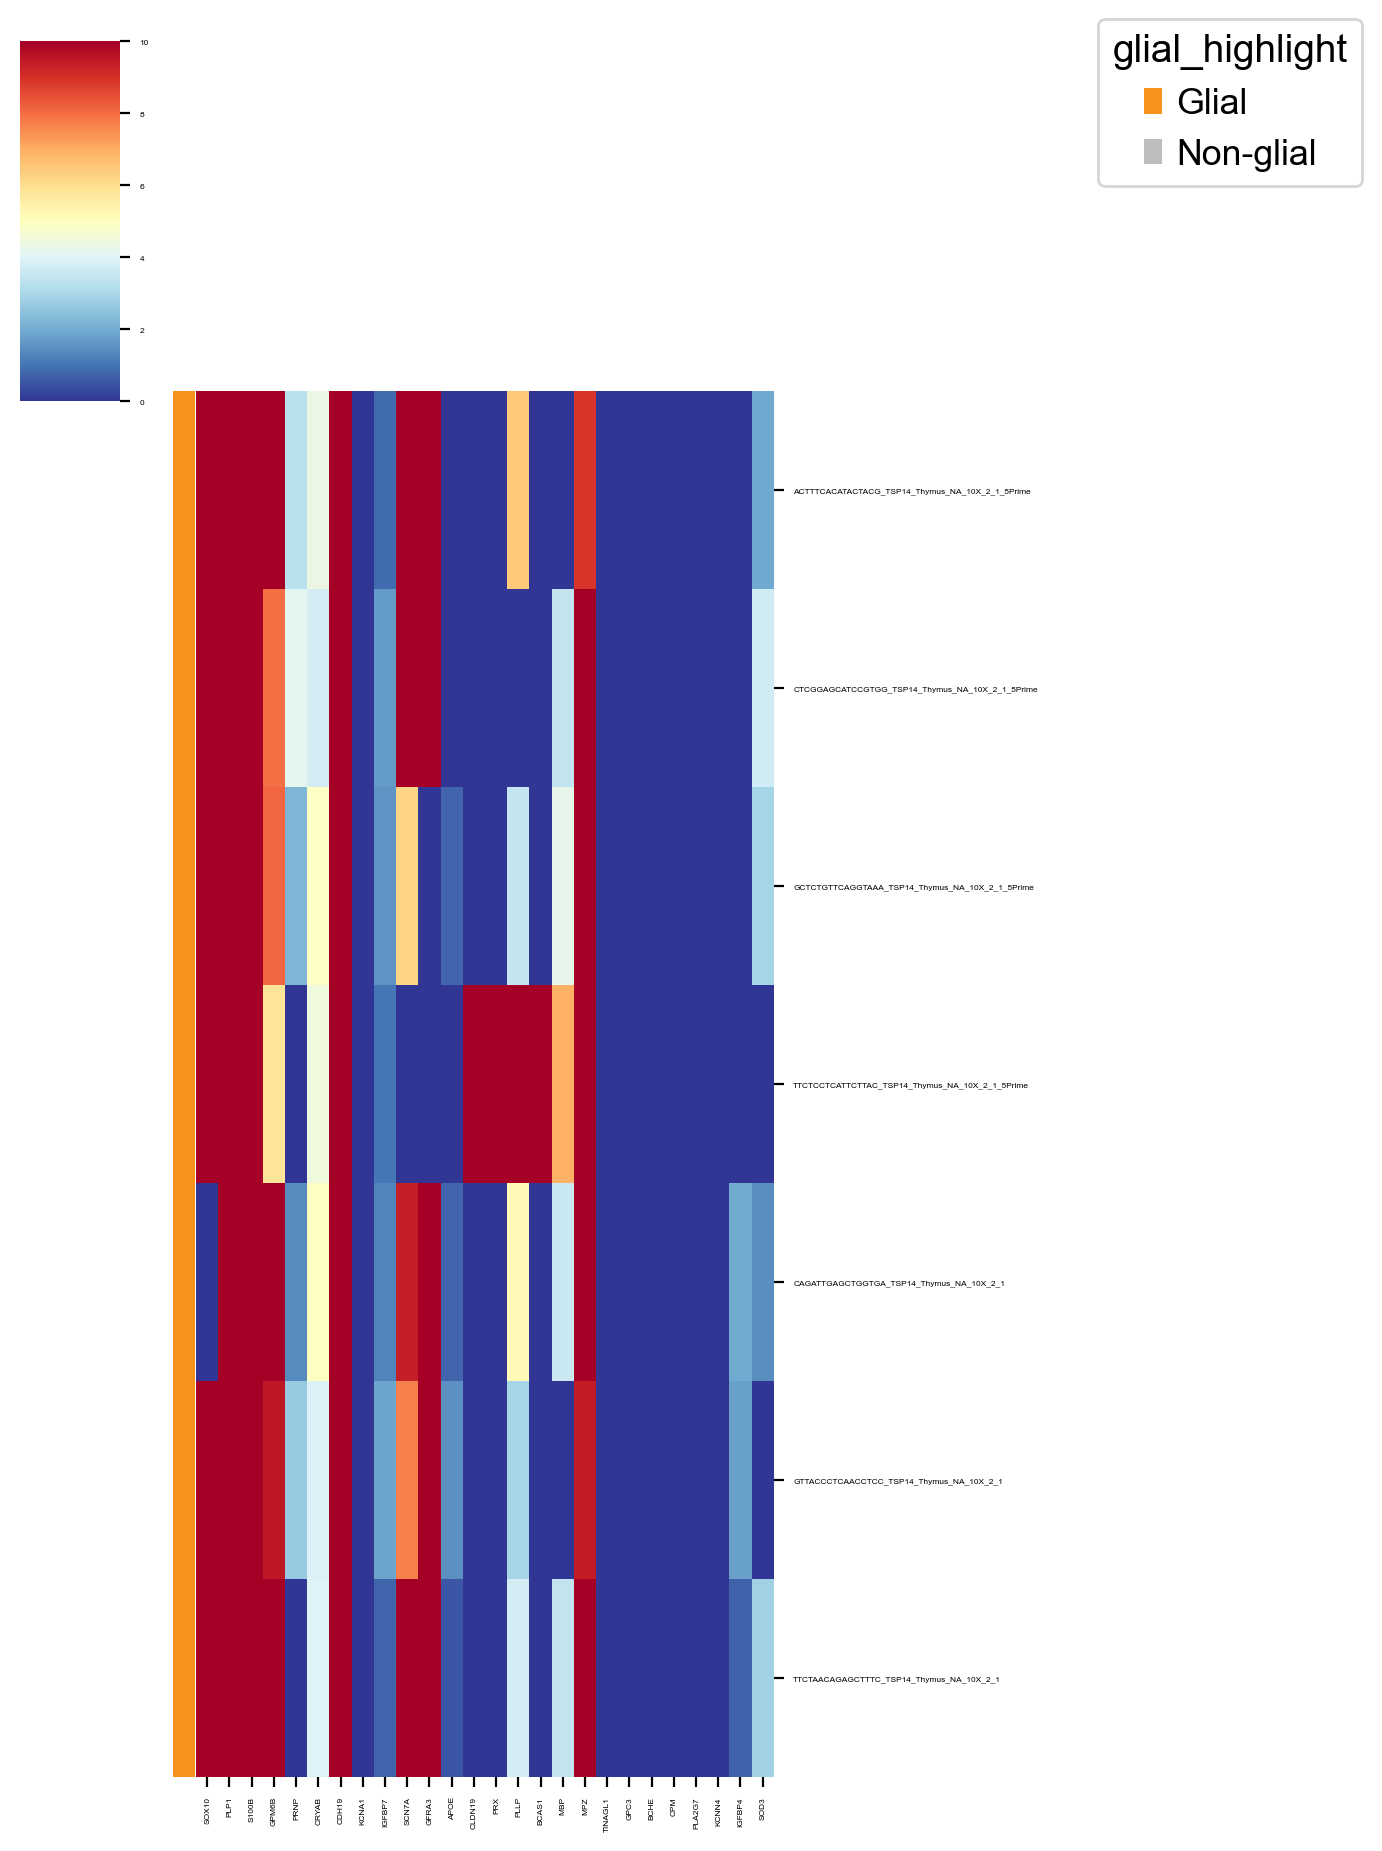

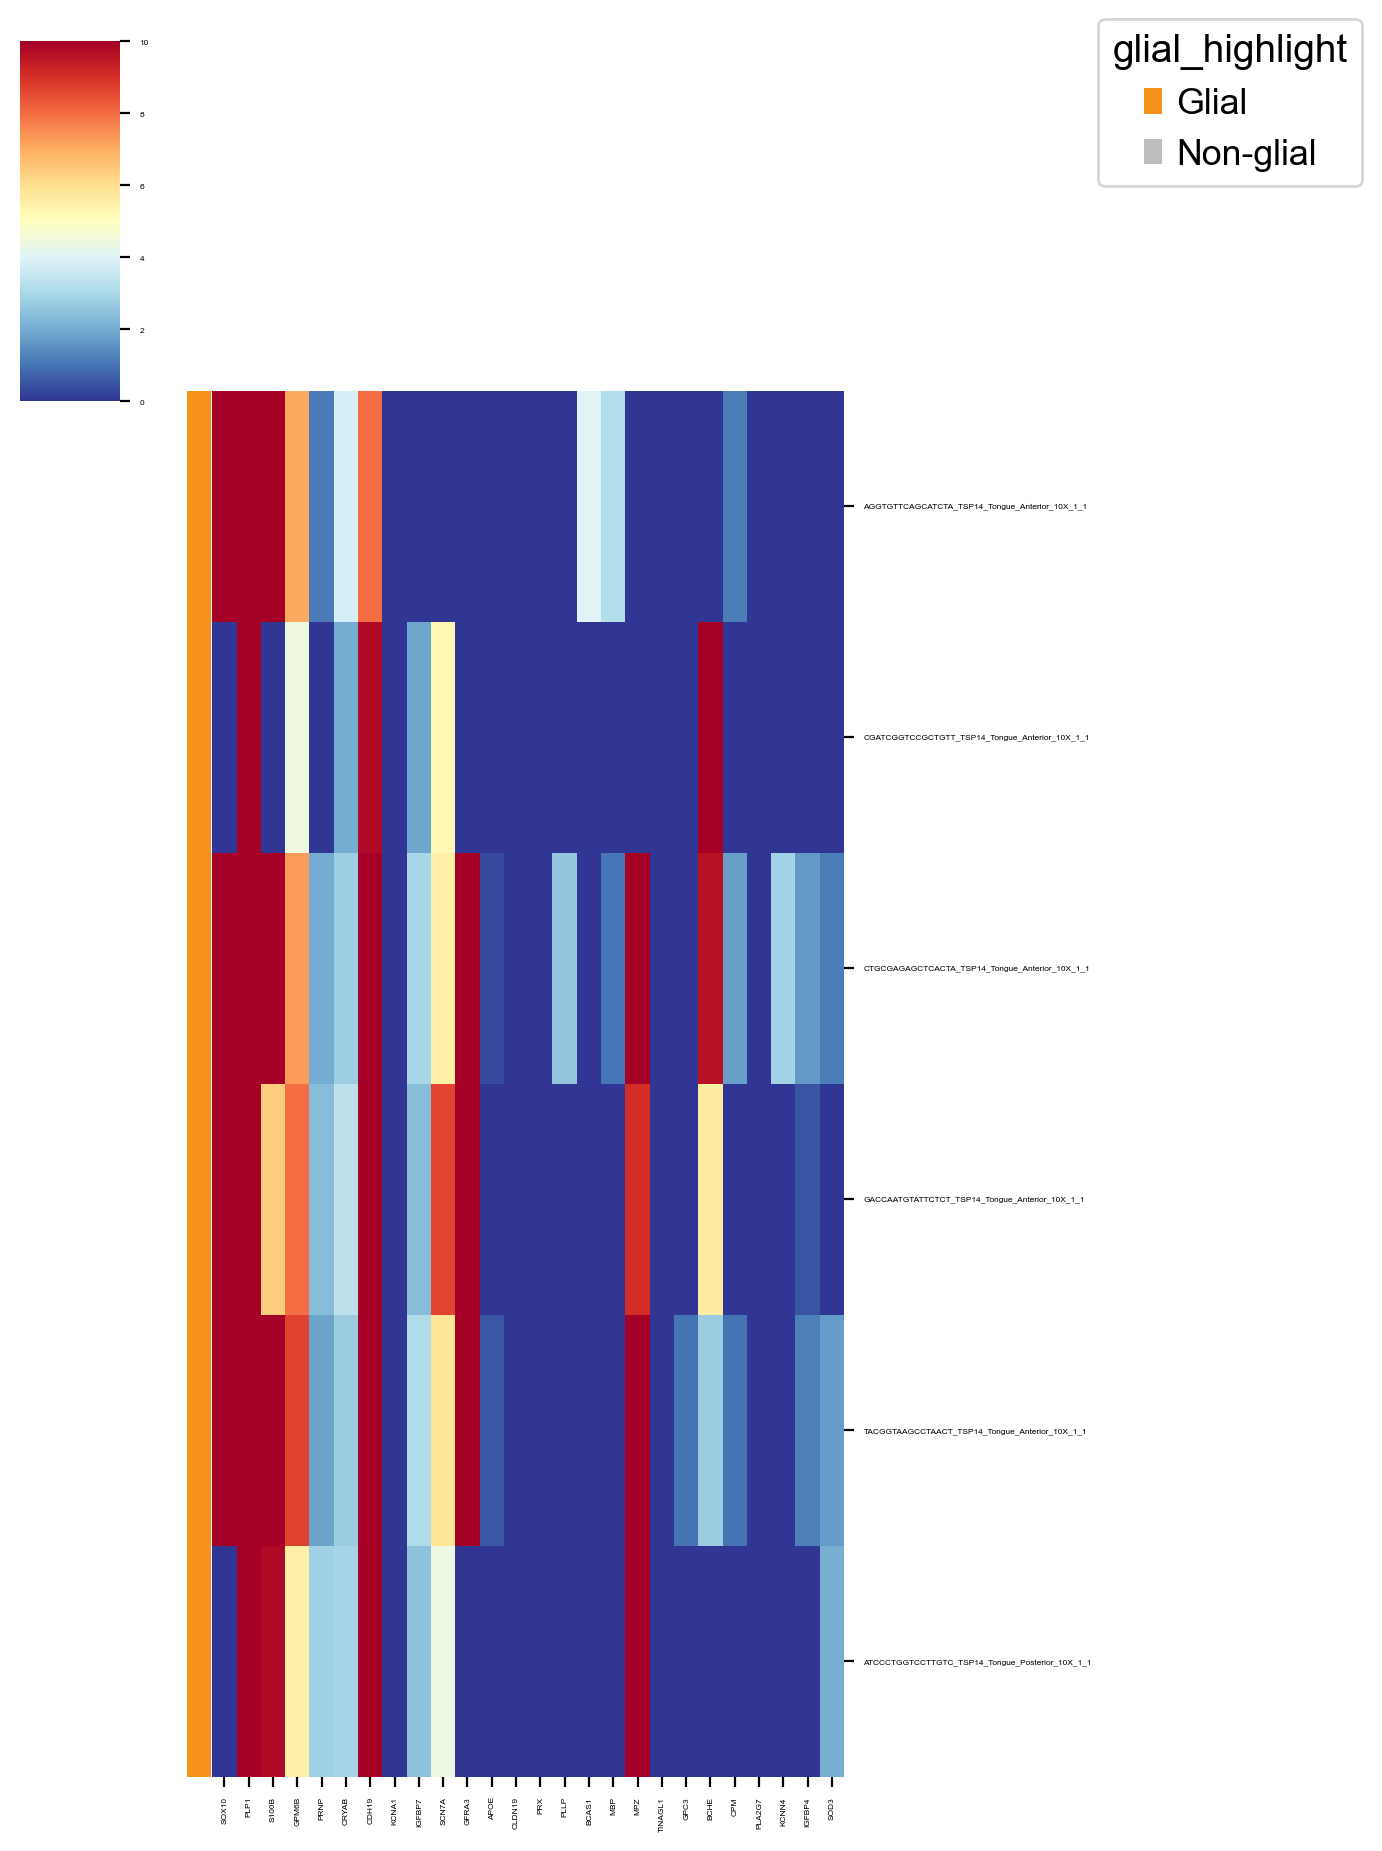

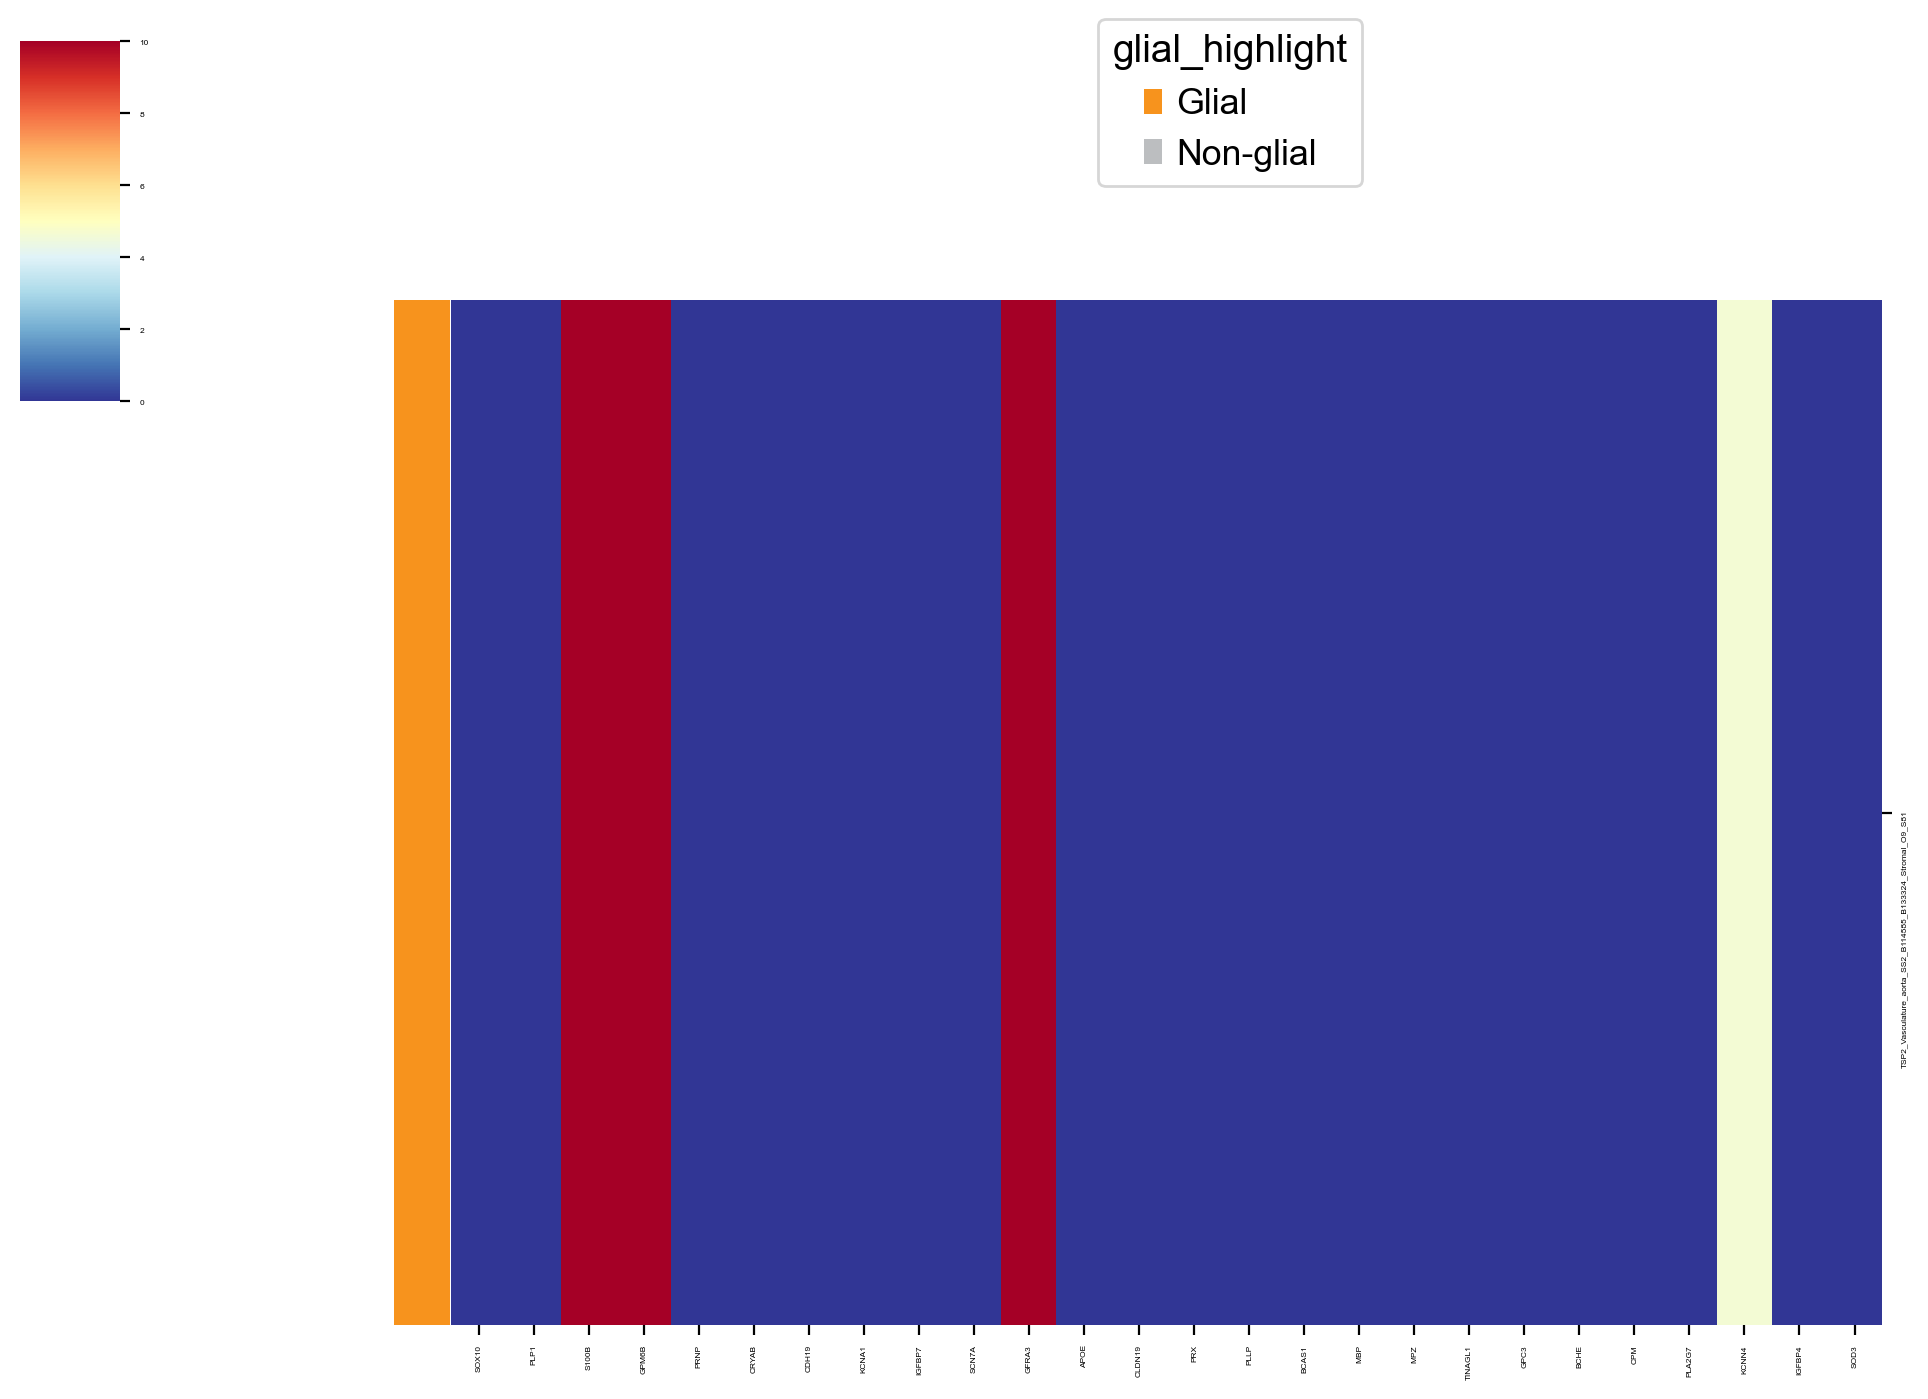

In [22]:
for tissue in np.unique(adata.obs['organ_tissue']):
    nonGlialHeatmap(adata, tissue)

In [23]:
adata.obs

organ_tissue     method  \
cell_id                                                                         
CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10X...  Salivary_Gland        10X   
ACGATGTTCGGCTGTG_TSP5_Eye_NA_10X_1_2                           Eye        10X   
AGATCCACAACAGCTT_TSP5_Eye_NA_10X_1_2                           Eye        10X   
AGGAGGTAGAAGGGAT_TSP5_Eye_NA_10X_1_2                           Eye        10X   
TTGCTGCCATCCTTCG_TSP3_Eye_NA_10X_1_1_NoCornea                  Eye        10X   
...                                                            ...        ...   
ATCCACCCAGGCTACC_TSP2_Lung_proxmedialdistal_10X...            Lung        10X   
CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10X...            Lung        10X   
CCATCACGTACCGGCT_TSP2_Muscle_rectusabdominus_10...          Muscle        10X   
AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3                      Pancreas        10X   
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stro...     Vasculature  smartseq2   

                                                   donor  \
cell_id                                                    
CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10X...  TSP7   
ACGATGTTCGGCTGTG_TSP5_Eye_NA_10X_1_2                TSP5   
AGATCCACAACAGCTT_TSP5_Eye_NA_10X_1_2                TSP5   
AGGAGGTAGAAGGGAT_TSP5_Eye_NA_10X_1_2                TSP5   
TTGCTGCCATCCTTCG_TSP3_Eye_NA_10X_1_1_NoCornea       TSP3   
...                                                  ...   
ATCCACCCAGGCTACC_TSP2_Lung_proxmedialdistal_10X...  TSP2   
CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10X...  TSP2   
CCATCACGTACCGGCT_TSP2_Muscle_rectusabdominus_10...  TSP2   
AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3                TSP1   
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stro...  TSP2   

                                                   anatomical_information  \
cell_id                                                                     
CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10X...                Parotid   
ACGATGTTCGGCTGTG_TSP5_Eye_NA_10X_1_2                                  nan   
AGATCCACAACAGCTT_TSP5_Eye_NA_10X_1_2                                  nan   
AGGAGGTAGAAGGGAT_TSP5_Eye_NA_10X_1_2                                  nan   
TTGCTGCCATCCTTCG_TSP3_Eye_NA_10X_1_1_NoCornea                         nan   
...                                                                   ...   
ATCCACCCAGGCTACC_TSP2_Lung_proxmedialdistal_10X...       proxmedialdistal   
CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10X...       proxmedialdistal   
CCATCACGTACCGGCT_TSP2_Muscle_rectusabdominus_10...        rectusabdominus   
AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3                             Exocrine   
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stro...                    nan   

                                                    n_counts_UMIs  n_genes  \
cell_id                                                                      
CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10X...         4061.0     2418   
ACGATGTTCGGCTGTG_TSP5_Eye_NA_10X_1_2                       5128.0     2027   
AGATCCACAACAGCTT_TSP5_Eye_NA_10X_1_2                       5165.0     2265   
AGGAGGTAGAAGGGAT_TSP5_Eye_NA_10X_1_2                       3883.0     1710   
TTGCTGCCATCCTTCG_TSP3_Eye_NA_10X_1_1_NoCornea              7204.0     2345   
...                                                           ...      ...   
ATCCACCCAGGCTACC_TSP2_Lung_proxmedialdistal_10X...        10836.0     3052   
CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10X...        26046.0     6144   
CCATCACGTACCGGCT_TSP2_Muscle_rectusabdominus_10...         2899.0     1568   
AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3                      14998.0     4336   
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stro...        40203.0      971   

                                                                    cell_ontology_class  \
cell_id                                                                                   
CGATGGCCACTCCTTG_TSP

#### Glial Classes

In [81]:
# Function for generating a heatmap for specified tissue of finalized glial cells
def snsHeatmap(adata, tissue):
    fp = "/Users/shawnschulz/Documents/shared/"
    adata = adata[adata.obs['is_glial'] == 'Glial']
    adata.obs['barcodes'] = adata.obs.index
    adata.obs.index = adata.obs.index.astype(str)
    def sub_genes(adata, tissue):
        sub = adata[adata.obs['organ_tissue']==tissue]
        sub = sub[:, ["SOX10", "PLP1", "S100B", "GPM6B", "PRNP", "CRYAB", "CDH19", "KCNA1", "IGFBP7", "SCN7A", "GFRA3", "APOE", "CLDN19", "PRX", "PLLP", "BCAS1", "MBP", "MPZ", "TINAGL1", "GPC3", "BCHE", "CPM", "PLA2G7", "KCNN4", "IGFBP4", "SOD3"]]
        sub.obs['barcodes']=sub.obs.index
        sub.obs['barcodes']=sub.obs['barcodes'].astype('category')
        display(sub)
        return(sub)
    sub = sub_genes(adata,tissue)
    if len(sub.obs) == 0:
        return pd.DataFrame()
    # Need a custom order before we can sourt the custom order
#    sub.obs['glial_classes'] = pd.Categorical(sub.obs['glial_classes'], categories=['terminal', 'myelinating', 'non-myelinating'], ordered=True)
    sub = sub[sub.obs.sort_values(['glial_classes'], ascending = False).index]
    glial_class_col = sub.obs["glial_classes"]
    
    lut = {'non_myelinating': '#F8766D', 'myelinating': '#619CFF', 'terminal': '#00BA38'}
    row_colors = glial_class_col.map(lut).to_numpy()
    print("glial classes col is:")
    print(glial_class_col)
    print("classes col with correct order is :")
    corrected_glial_class_col = glial_class_col.iloc[::-1]
    print(corrected_glial_class_col)
    print(row_colors)
    # Generate the heatmap and adjust tick labels
#    sub = sub.copy().T
    heatmap = sns.clustermap(sub.X.todense(), yticklabels = list(sub.obs['barcodes']), xticklabels= list(sub.var.index),col_cluster = False, row_cluster = False, cmap='RdYlBu_r', row_colors=row_colors)
#    heatmap = sns.clustermap(sub.X.todense(), yticklabels = list(sub.var.index), xticklabels= list(sub.obs.index),col_cluster = False, row_cluster = False, cmap='RdYlBu_r', row_colors=row_colors)

    heatmap.tick_params(axis='both', which='major', labelsize=10)
   
    # Legend for glial_class
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='glial_highlight', bbox_to_anchor=(0.7, 1),
               bbox_transform=plt.gcf().transFigure, loc='upper right')
   
    fig = heatmap.fig
    fig.savefig(fp + "ts_" + tissue + "_glial_classes_adata_heatmap.pdf")
    corrected_glial_class_col.to_csv(fp + tissue + "_ordered_barcodes.csv")
    return glial_class_col

## Generate Table for Supplemental Figure

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 35 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
CCCTTAGAGACTAAGT_TSP1_bladder_3                             myelinating
AGGACGAAGAGAGCGG_TSP14_Bladder_NA_10X_1_1               non_myelinating
TTCTTGAAGACATAAC_TSP1_bladder_2                         non_myelinating
CCGGGTAAGTGGCGAT_TSP2_Bladder_NA_10X_1_1                non_myelinating
CTCCAACTCCGTGTGG_TSP2_Bladder_NA_10X_1_1                non_myelinating
GAGGCAAAGCGCCTCA_TSP2_Bladder_NA_10X_1_1                non_myelinating
TAAGCACTCCTGATAG_TSP2_Bladder_NA_10X_1_1                non_myelinating
TGCAGGCGTGCCTTTC_TSP2_Bladder_NA_10X_1_1                non_myelinating
TGCATCCGTTCTCCTG_TSP2_Bladder_NA_10X_1_1                non_myelinating
ACACAGTGTTGACGGA_TSP2_Bladder_NA_10X_1_2                non_myelinating
ACCACAACAAATACGA_TSP2_Bladder_NA_10X_1_2                non_myelinating
ACTATGGTCTACTGAG_TSP2_Bladder_NA_10X_1_2                non_myelinating
CCTCTCCCAGTGTACT_TSP2_Bladder_NA_10X_1_2                non_myelinating
CGAGAAGGTGTTACAC_TSP2_Bladder_NA_1

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 14 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
GGGTGTCAGTGCCAGA_TSP15_Eye_Sclera-etc_10X_2_1        myelinating
TGATTCTAGCTGAGCA_TSP15_Eye_Sclera-etc_10X_2_1        myelinating
ACGATGTTCGGCTGTG_TSP5_Eye_NA_10X_1_2             non_myelinating
AGATCCACAACAGCTT_TSP5_Eye_NA_10X_1_2             non_myelinating
AGGAGGTAGAAGGGAT_TSP5_Eye_NA_10X_1_2             non_myelinating
TTGCTGCCATCCTTCG_TSP3_Eye_NA_10X_1_1_NoCornea    non_myelinating
ATAGGCTGTGTTAACC_TSP5_Eye_NA_10X_1_1             non_myelinating
GGCAGTCGTCTAGGTT_TSP5_Eye_NA_10X_1_1             non_myelinating
AGGTGTTCAGCCTACG_TSP15_Eye_Cornea-etc_10X_1_1    non_myelinating
CCCTCAAAGTCACAGG_TSP15_Eye_Cornea-etc_10X_1_1    non_myelinating
ACACAGTGTGTAGTGG_TSP15_Eye_Sclera-etc_10X_2_1    non_myelinating
ATTCTACGTCATCCGG_TSP15_Eye_Sclera-etc_10X_2_1    non_myelinating
CAATGACGTCCACGCA_TSP15_Eye_Sclera-etc_10X_2_1    non_myelinating
CTCTCGATCTCTGGTC_TSP15_Eye_Sclera-etc_10X_2_1    non_myelinating
Name: glial_classes, dtype: category
Categories (2, object):

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 7 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
TTCTCCTCATTCTTAC_TSP14_Thymus_NA_10X_2_1_5Prime        myelinating
ACTTTCACATACTACG_TSP14_Thymus_NA_10X_2_1_5Prime    non_myelinating
CTCGGAGCATCCGTGG_TSP14_Thymus_NA_10X_2_1_5Prime    non_myelinating
GCTCTGTTCAGGTAAA_TSP14_Thymus_NA_10X_2_1_5Prime    non_myelinating
CAGATTGAGCTGGTGA_TSP14_Thymus_NA_10X_2_1           non_myelinating
GTTACCCTCAACCTCC_TSP14_Thymus_NA_10X_2_1           non_myelinating
TTCTAACAGAGCTTTC_TSP14_Thymus_NA_10X_2_1           non_myelinating
Name: glial_classes, dtype: category
Categories (2, object): ['non_myelinating', 'myelinating']
classes col with correct order is :
cell_id
TTCTAACAGAGCTTTC_TSP14_Thymus_NA_10X_2_1           non_myelinating
GTTACCCTCAACCTCC_TSP14_Thymus_NA_10X_2_1           non_myelinating
CAGATTGAGCTGGTGA_TSP14_Thymus_NA_10X_2_1           non_myelinating
GCTCTGTTCAGGTAAA_TSP14_Thymus_NA_10X_2_1_5Prime    non_myelinating
CTCGGAGCATCCGTGG_TSP14_Thymus_NA_10X_2_1_5Prime    non_myelinating
ACTTTCACATACTACG_TSP14_Thy

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 6 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
AGGTGTTCAGCATCTA_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
CGATCGGTCCGCTGTT_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
CTGCGAGAGCTCACTA_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
GACCAATGTATTCTCT_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
TACGGTAAGCCTAACT_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
ATCCCTGGTCCTTGTC_TSP14_Tongue_Posterior_10X_1_1    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
classes col with correct order is :
cell_id
ATCCCTGGTCCTTGTC_TSP14_Tongue_Posterior_10X_1_1    non_myelinating
TACGGTAAGCCTAACT_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
GACCAATGTATTCTCT_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
CTGCGAGAGCTCACTA_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
CGATCGGTCCGCTGTT_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
AGGTGTTCAGCATCTA_TSP14_Tongue_Anterior_10X_1_1     non_myelinating
Name: glial_classes, dtype: category
Cate

/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 3 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
TTGGTTTCAAGGGTCA_TSP8_Prostate_NA_10X_1_2                  non_myelinating
ATGGTTGAGCCGTTGC_TSP8_Prostate_NA_10X_1_1                  non_myelinating
TSP8_Prostate_NA_SS2_B134140_B134704_Epithelial_P2_L002    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
classes col with correct order is :
cell_id
TSP8_Prostate_NA_SS2_B134140_B134704_Epithelial_P2_L002    non_myelinating
ATGGTTGAGCCGTTGC_TSP8_Prostate_NA_10X_1_1                  non_myelinating
TTGGTTTCAAGGGTCA_TSP8_Prostate_NA_10X_1_2                  non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
['#F8766D' '#F8766D' '#F8766D']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 2 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10X_1_1     non_myelinating
TGCATCCTCTGTCTCG_TSP14_SalivaryGland_Parotid_10X_1_1    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
classes col with correct order is :
cell_id
TGCATCCTCTGTCTCG_TSP14_SalivaryGland_Parotid_10X_1_1    non_myelinating
CGATGGCCACTCCTTG_TSP7_SalivaryGland_Parotid_10X_1_1     non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
['#F8766D' '#F8766D']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 4 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
ACTGCAAGTGACAGGT_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    non_myelinating
AGGAATACAGACGATG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    non_myelinating
CAGAGCCCACTAGAGG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    non_myelinating
AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3                             non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
classes col with correct order is :
cell_id
AGGTTGTTCCGCTAGG_TSP1_exopancreas2_3                             non_myelinating
CAGAGCCCACTAGAGG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    non_myelinating
AGGAATACAGACGATG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    non_myelinating
ACTGCAAGTGACAGGT_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
['#F8766D' '#F8766D' '#F8766D' '#F8766D']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 2 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
GTTGTAGTCAAGTCTG_TSP2_Lung_proxmedialdistal_10X_1_1    non_myelinating
CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10X_1_2    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
classes col with correct order is :
cell_id
CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10X_1_2    non_myelinating
GTTGTAGTCAAGTCTG_TSP2_Lung_proxmedialdistal_10X_1_1    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
['#F8766D' '#F8766D']


/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['barcodes'] = adata.obs.index
/var/folders/gf/5m77fswx59n_g57lkjrxlrnc0000gq/T/ipykernel_33313/3352139386.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sub.obs['barcodes']=sub.obs.index


AnnData object with n_obs × n_vars = 1 × 26
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'glial_highlight', 'glial_classes', 'is_glial', 'barcodes'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

glial classes col is:
cell_id
AAAGGATCACGTATAC_TSP14_SI_Distal_10X_1_1    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
classes col with correct order is :
cell_id
AAAGGATCACGTATAC_TSP14_SI_Distal_10X_1_1    non_myelinating
Name: glial_classes, dtype: category
Categories (1, object): ['non_myelinating']
['#F8766D']


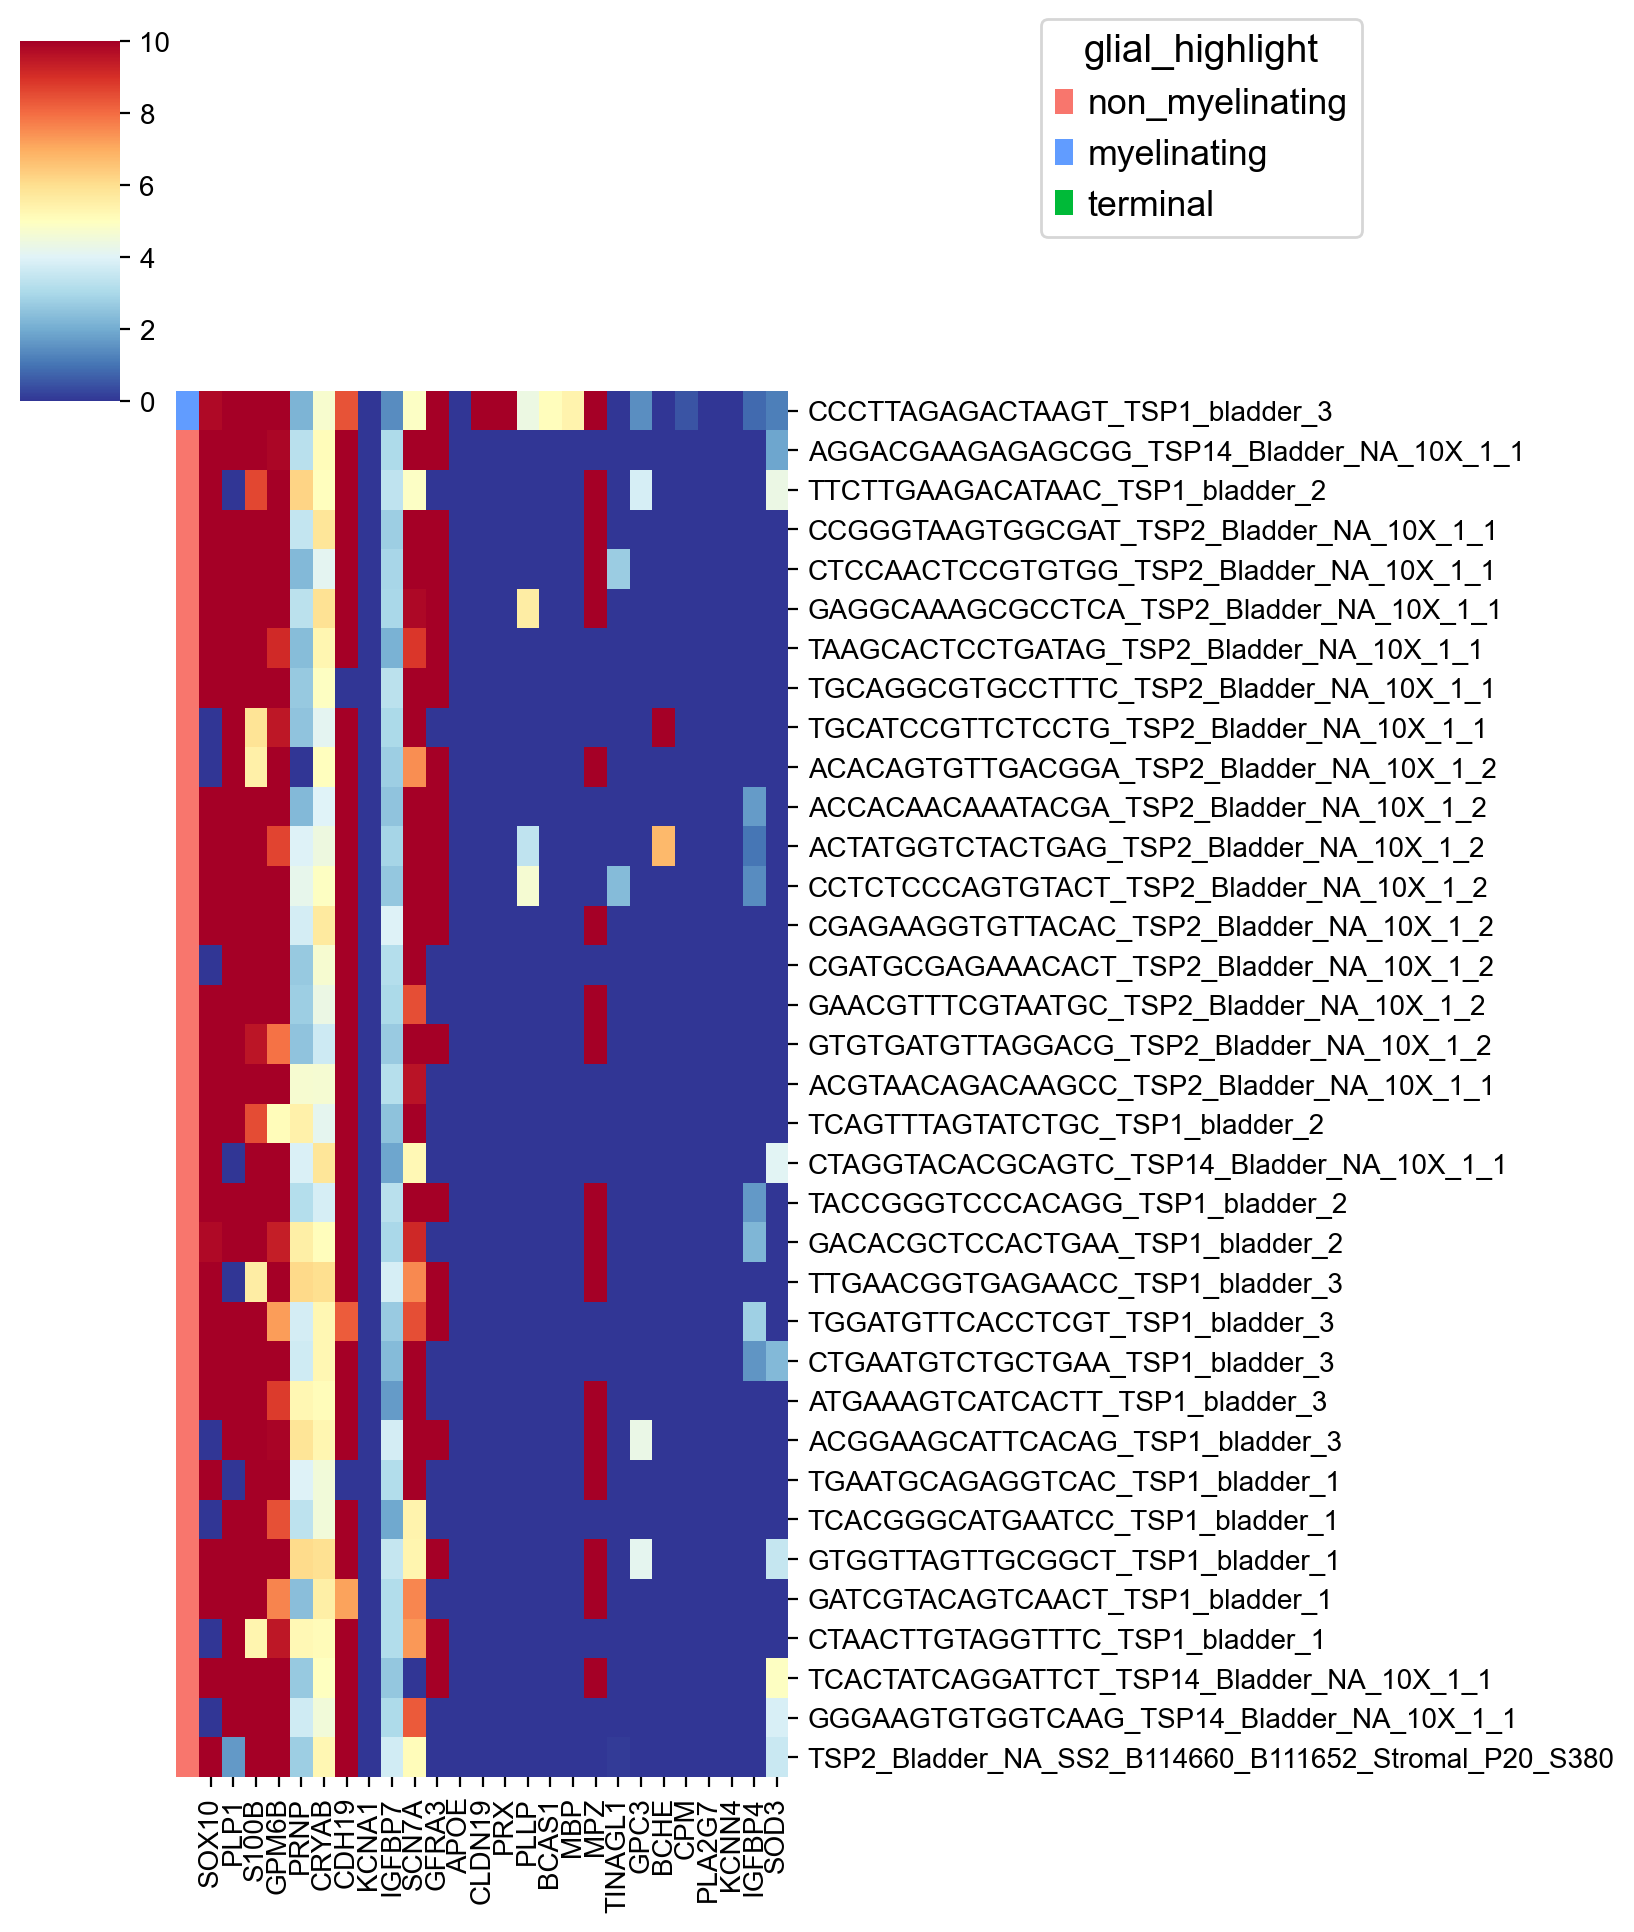

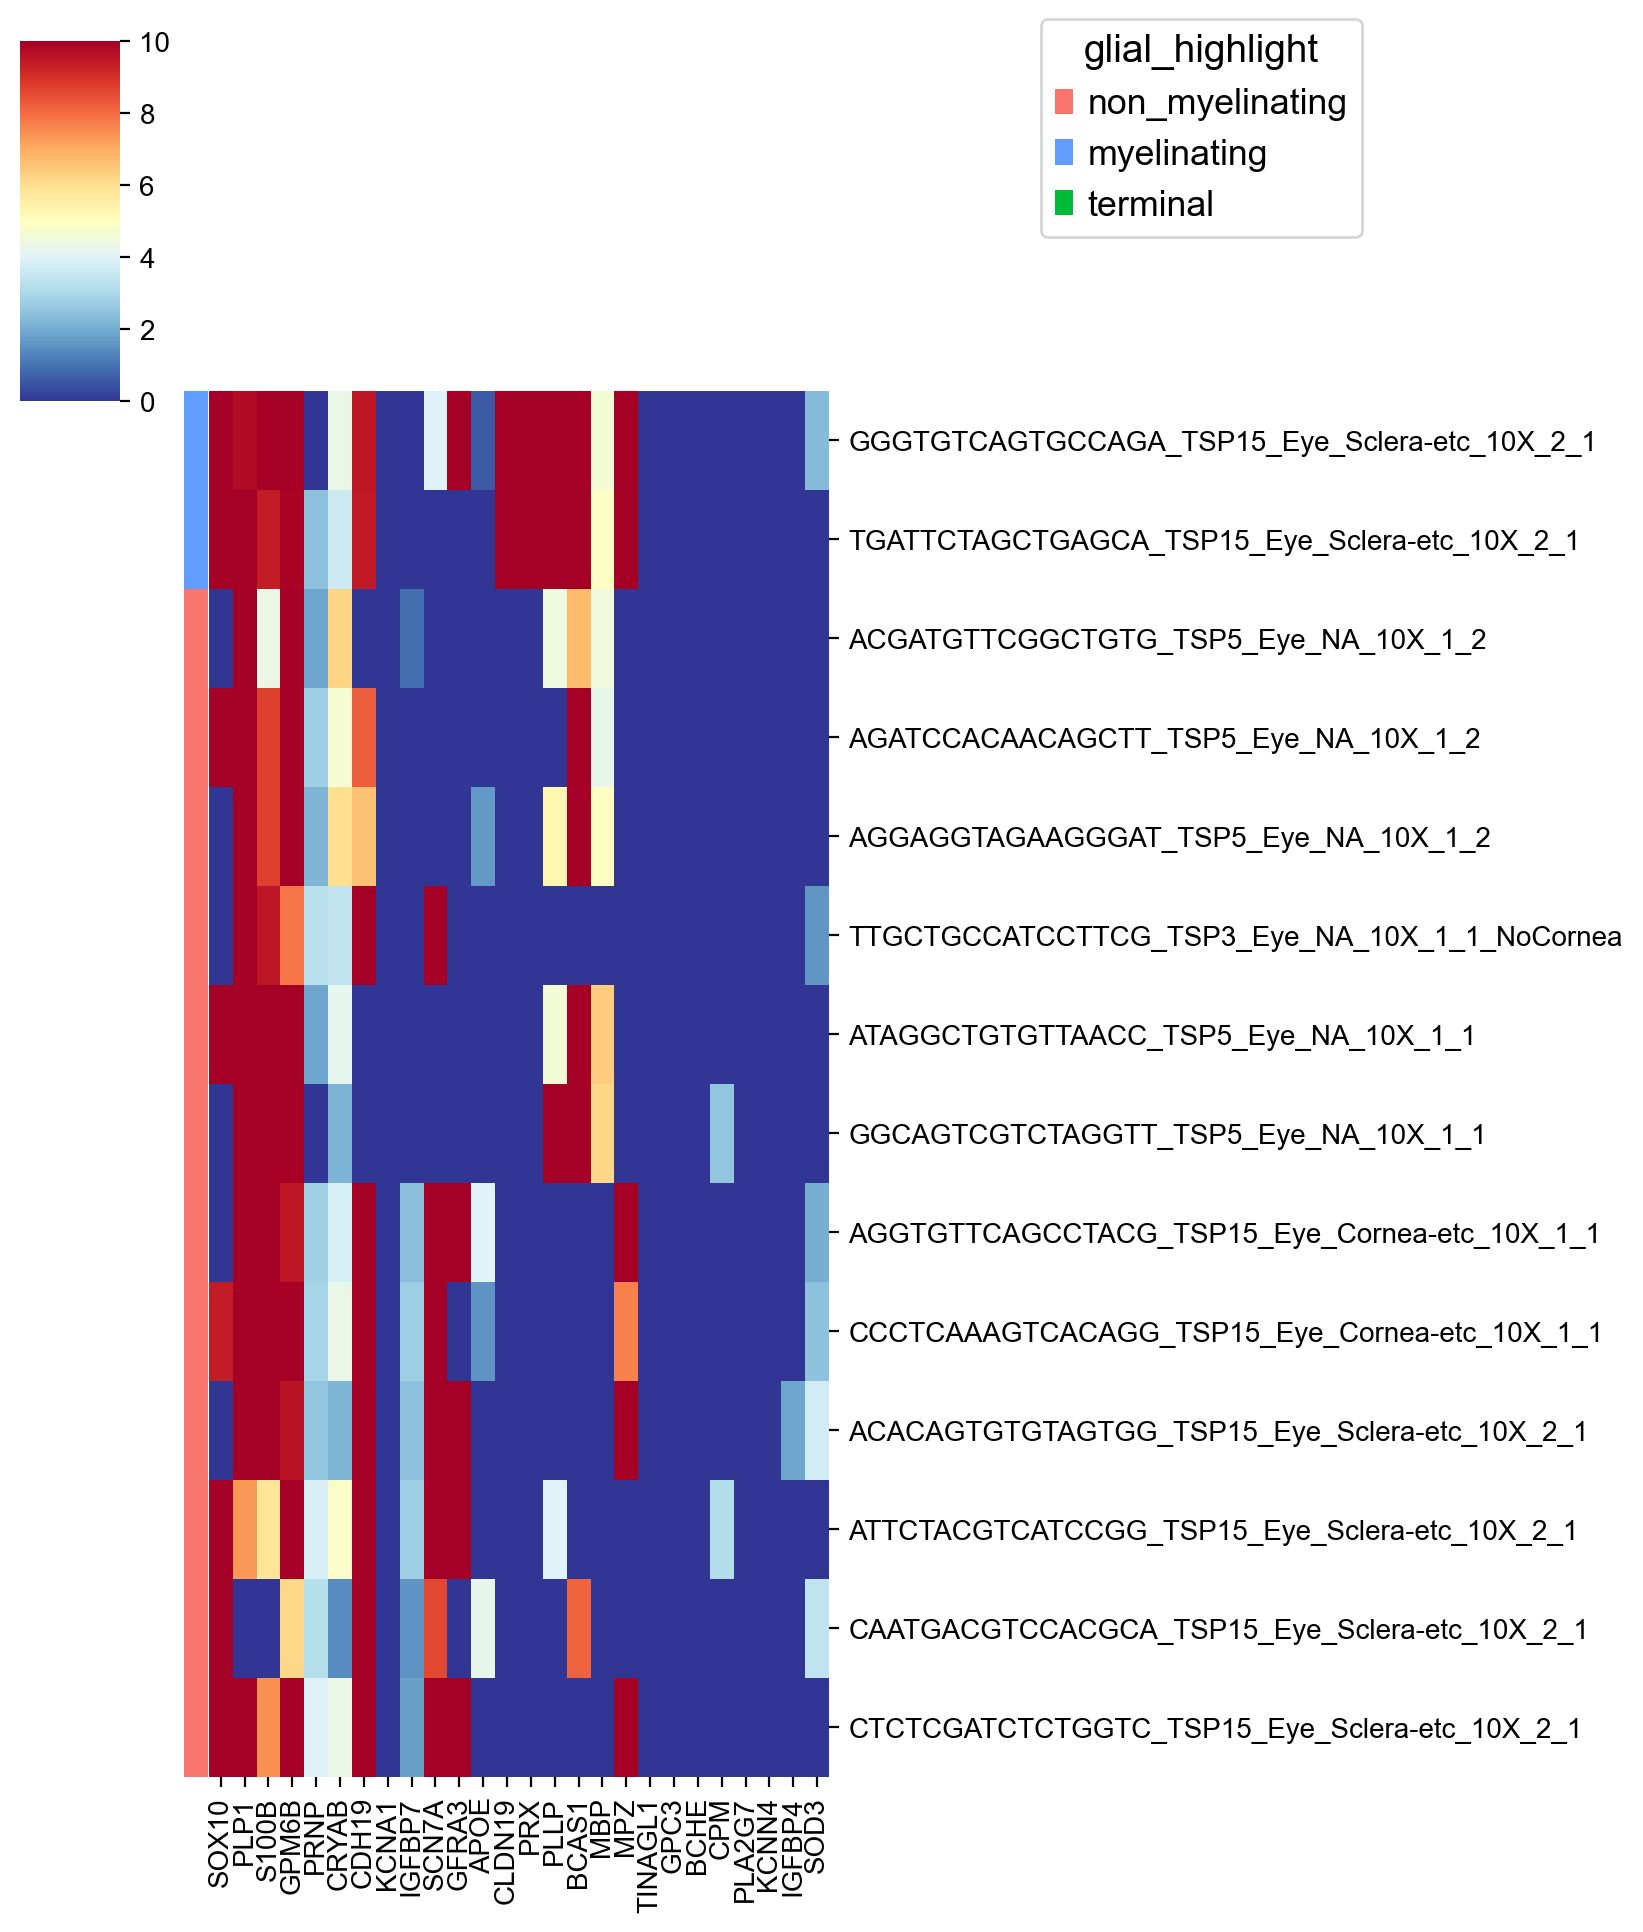

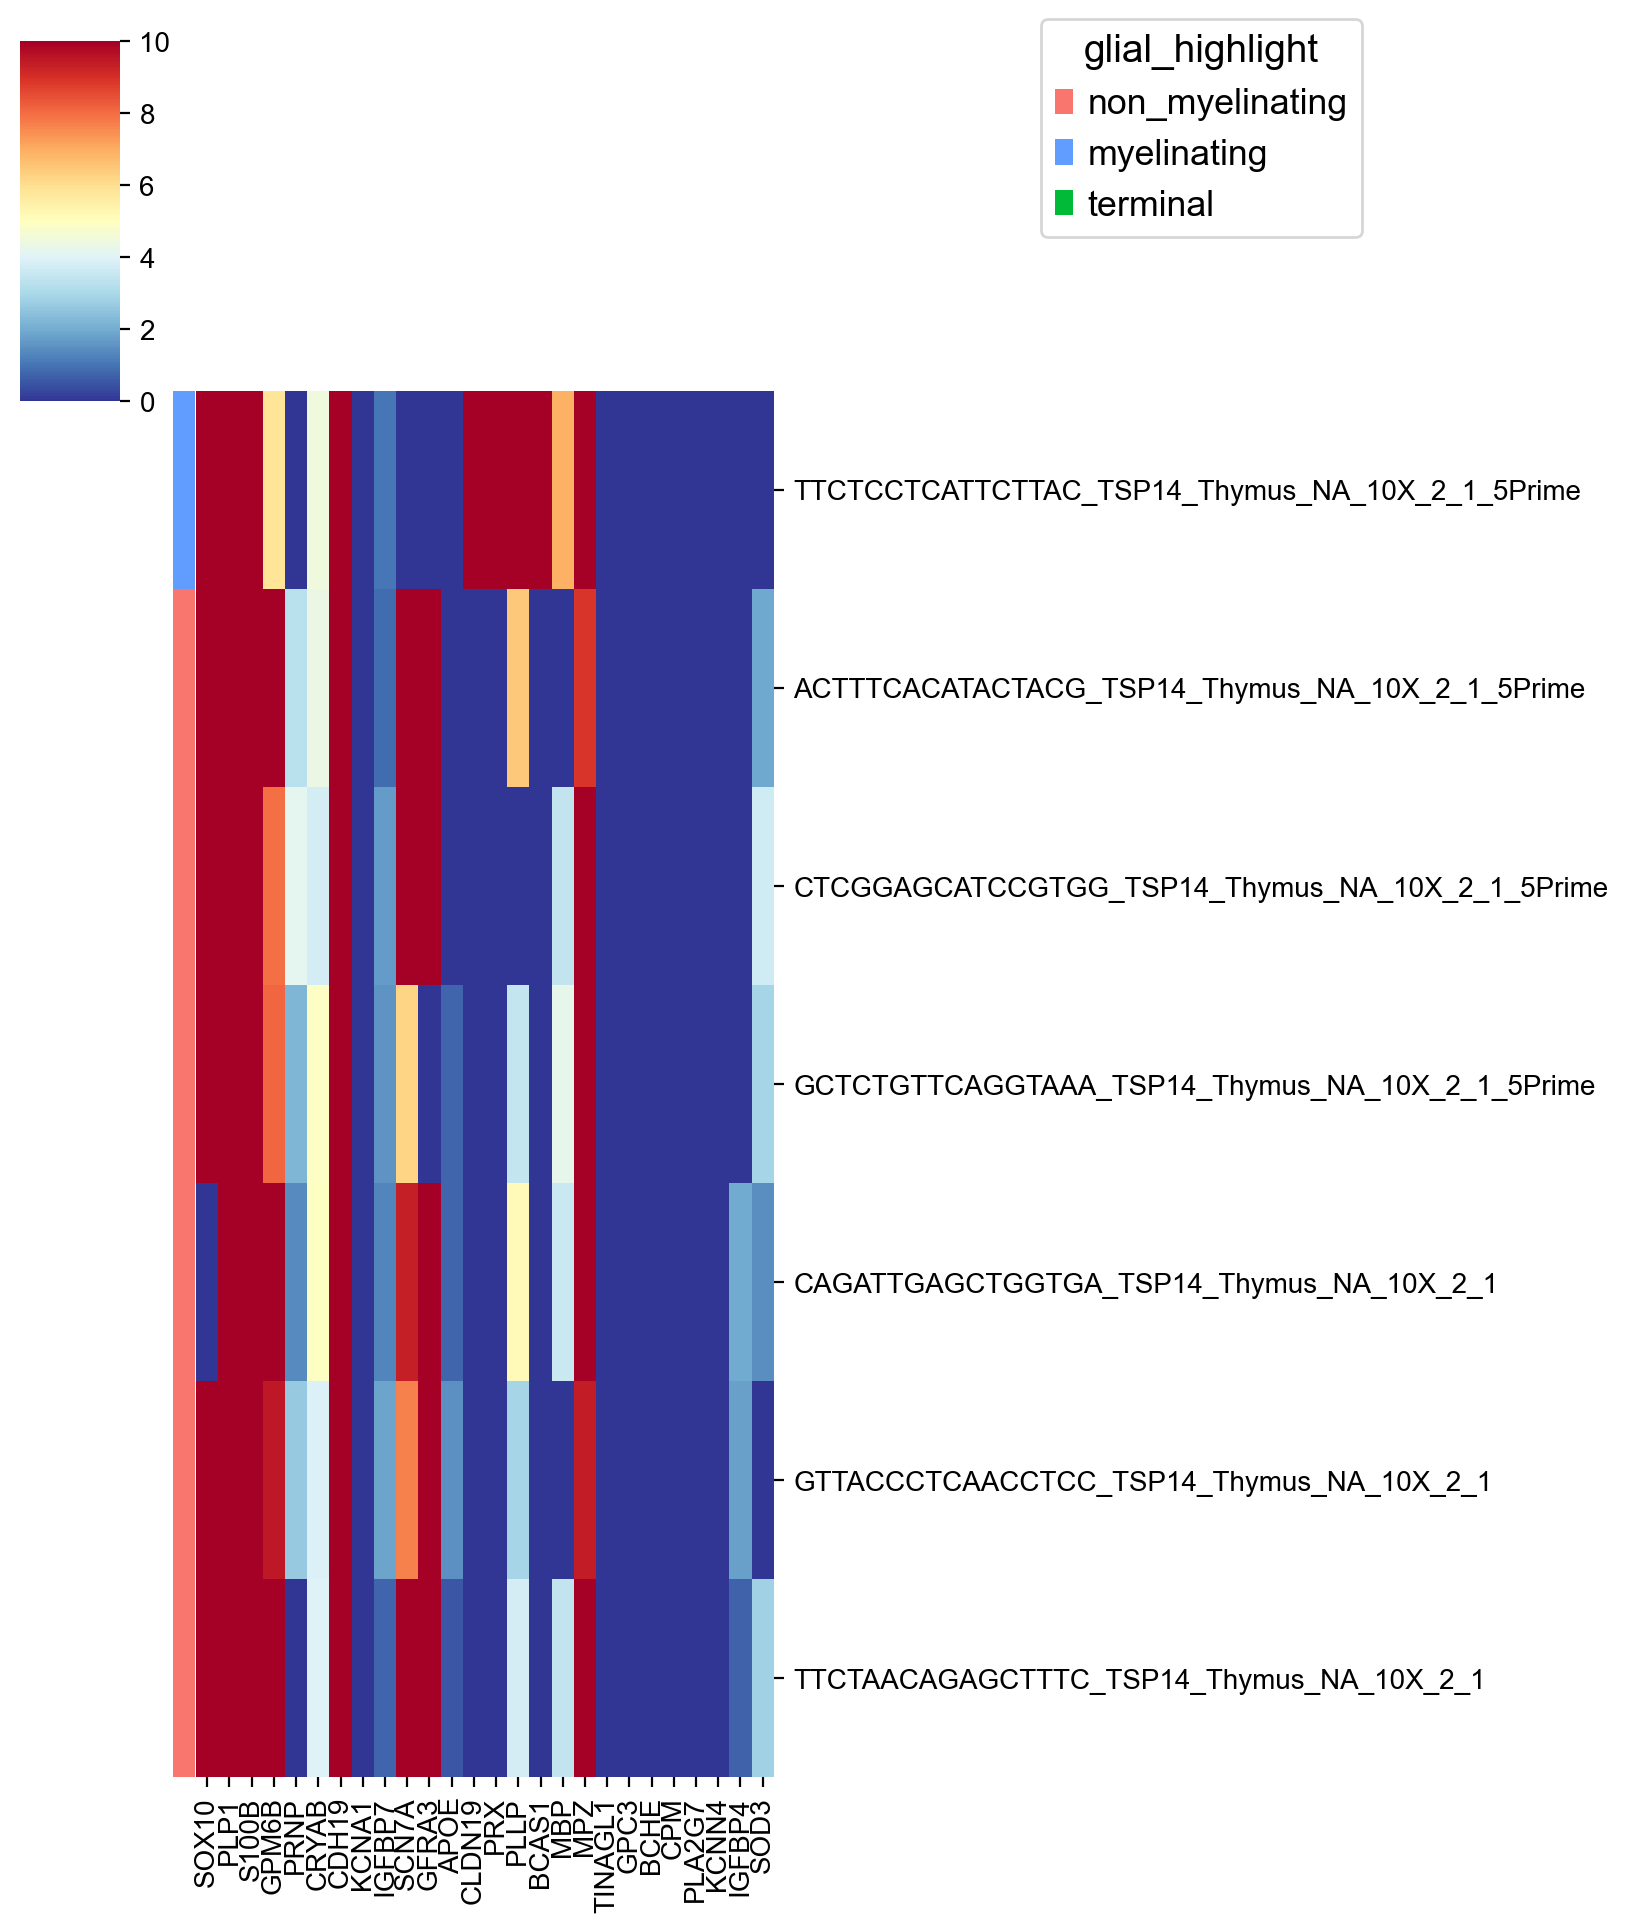

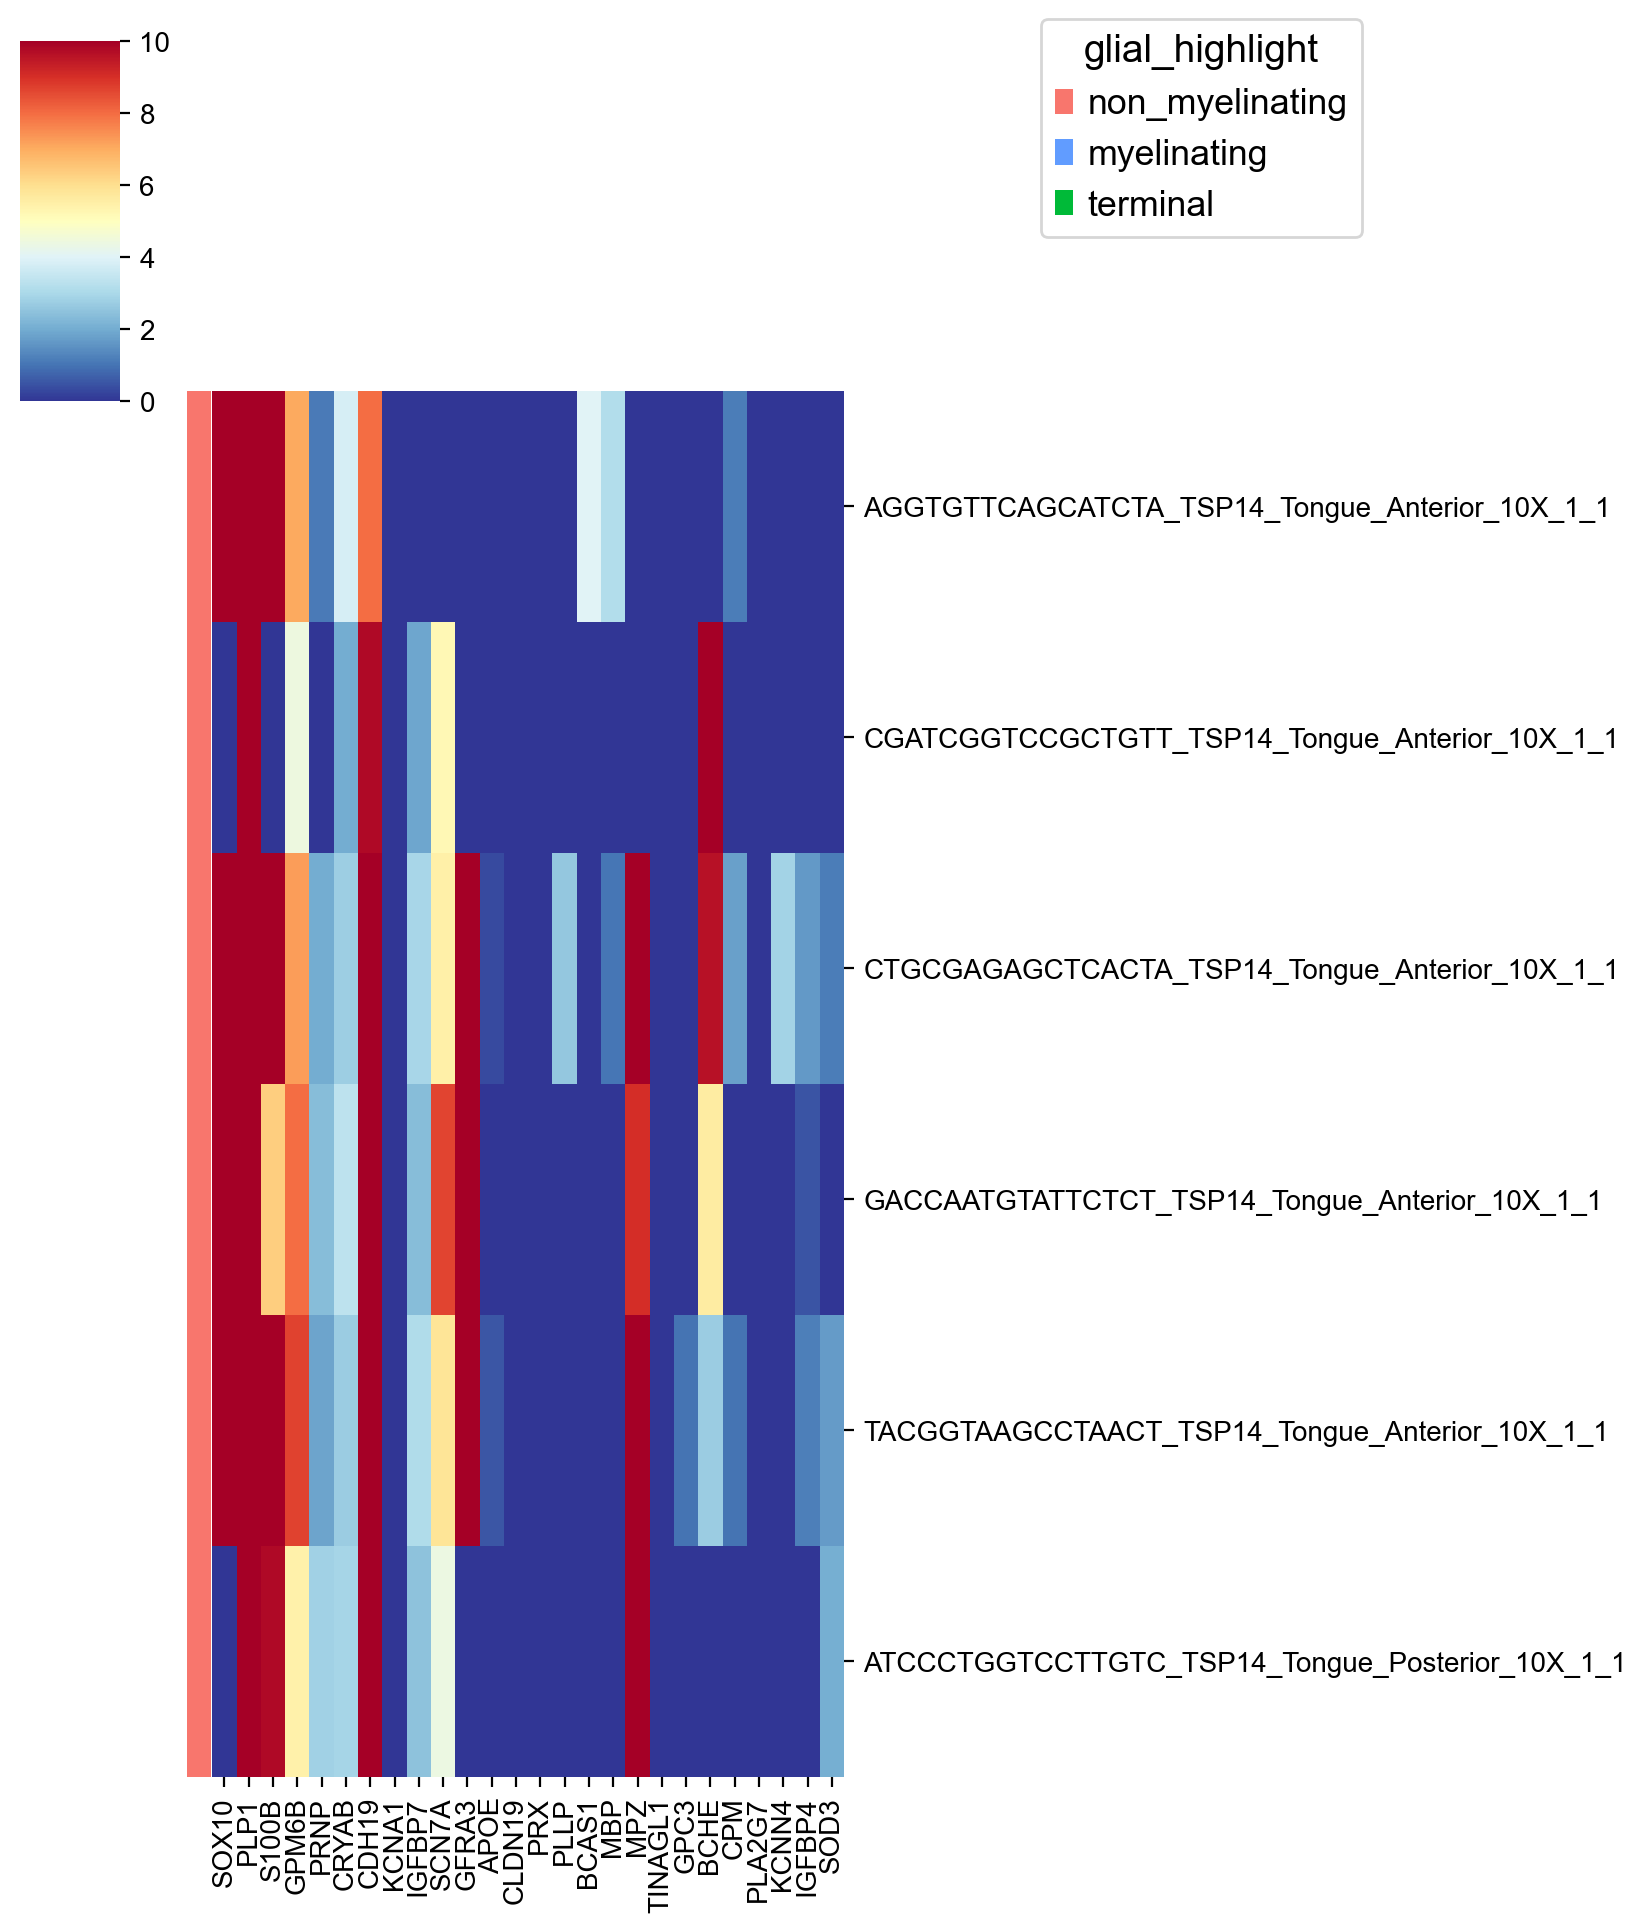

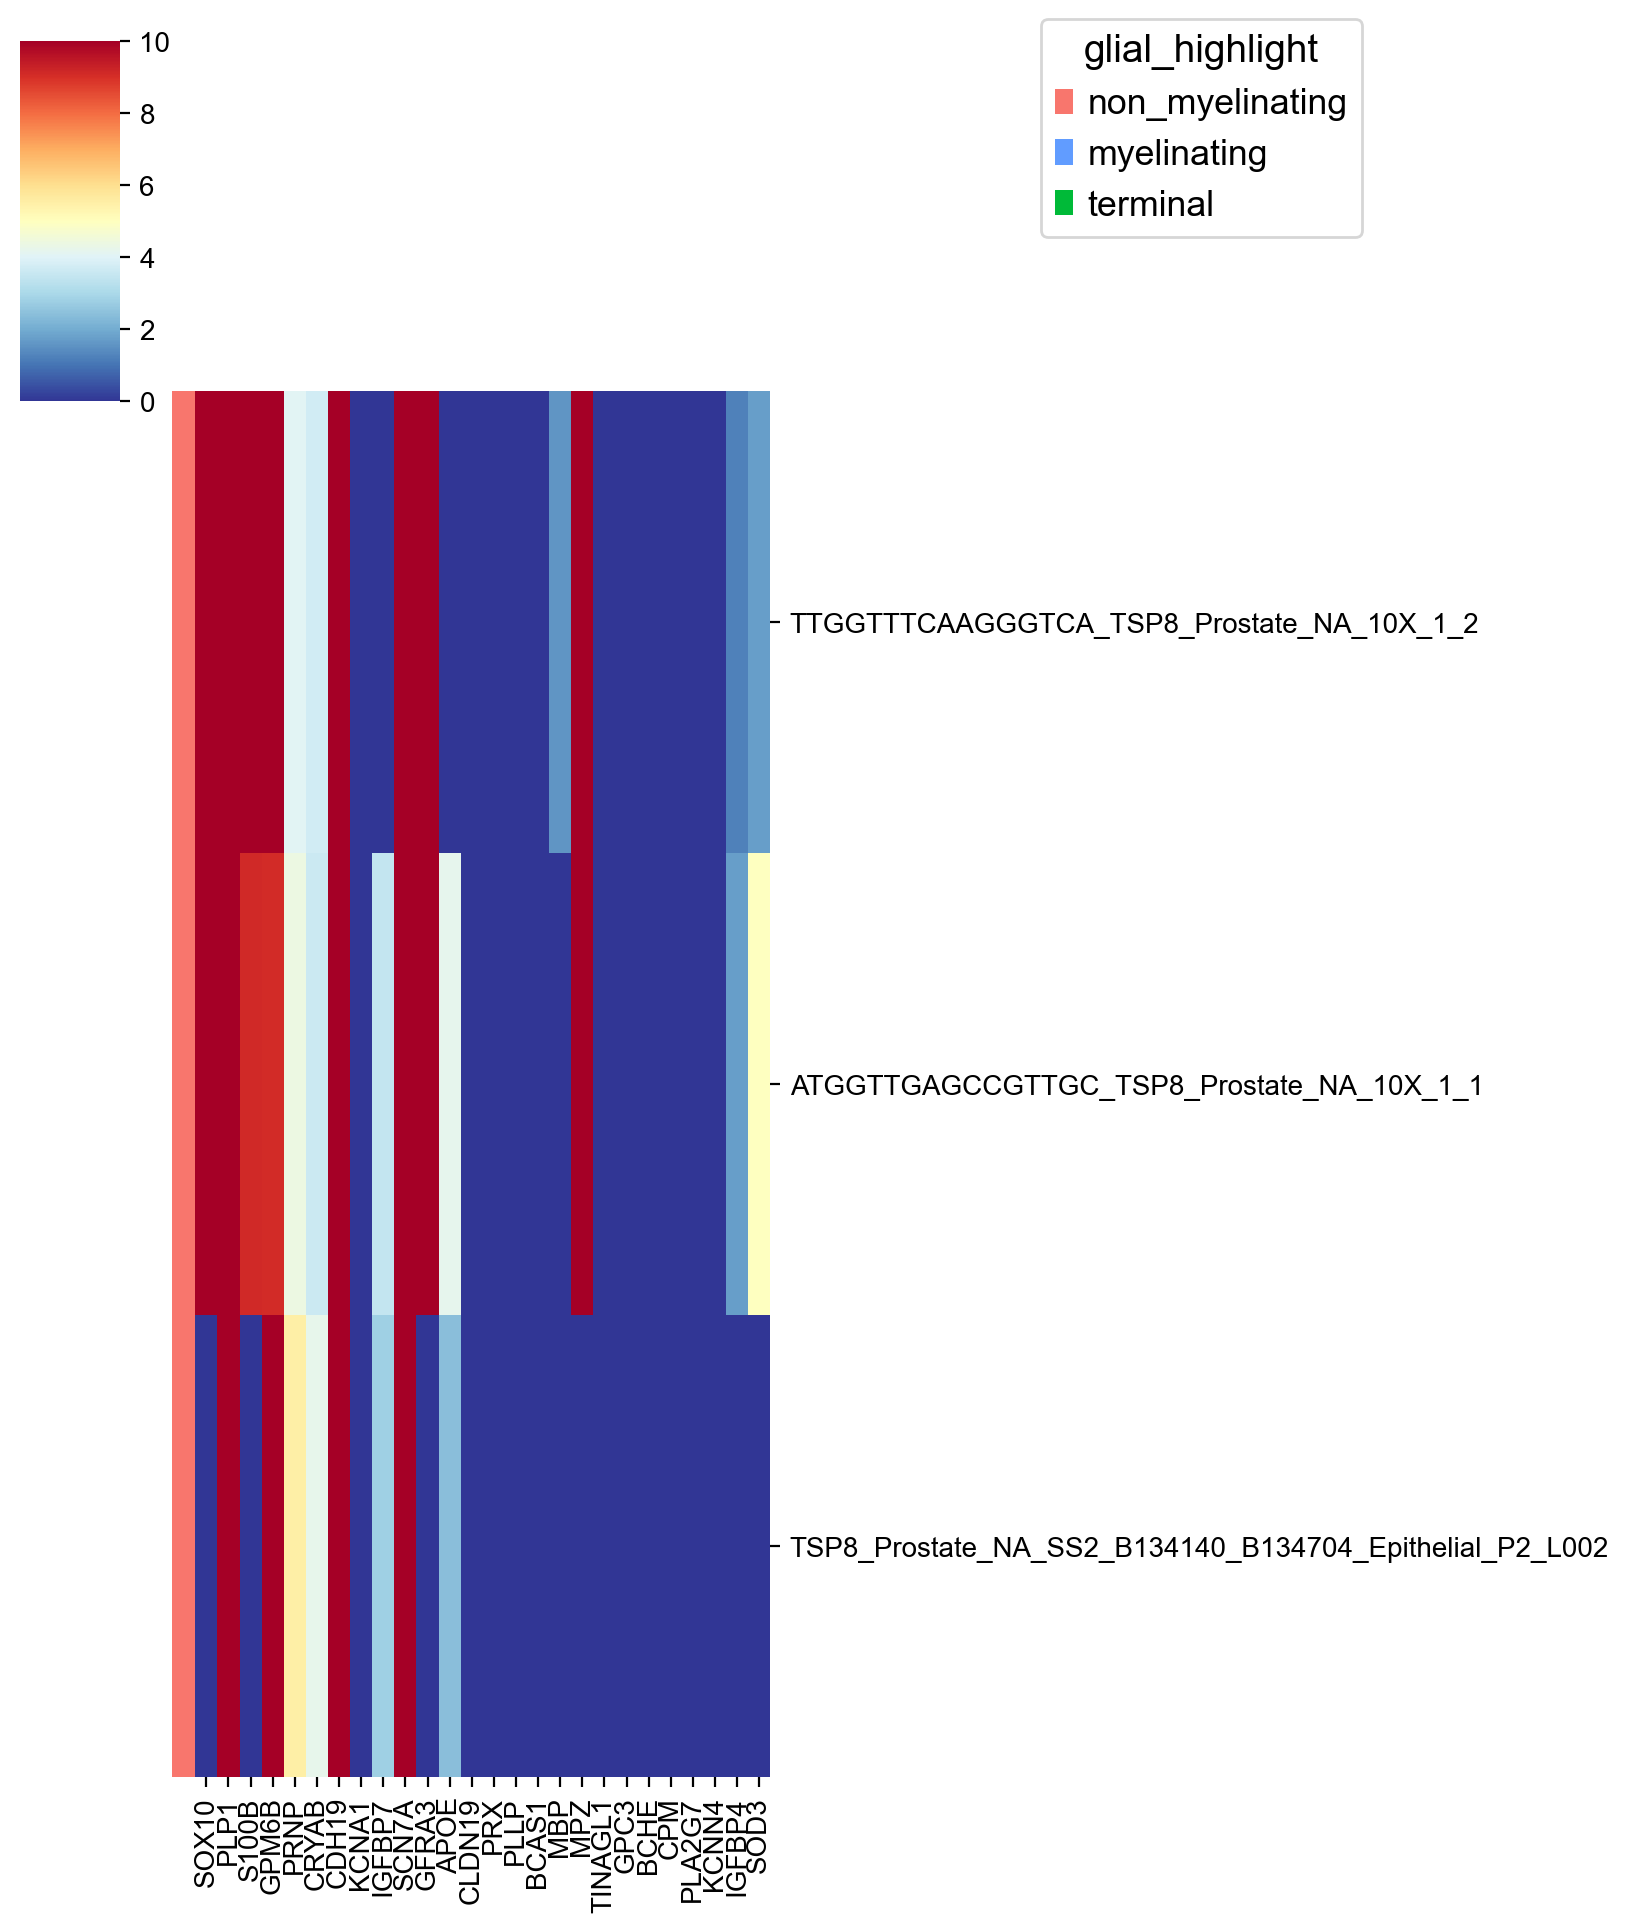

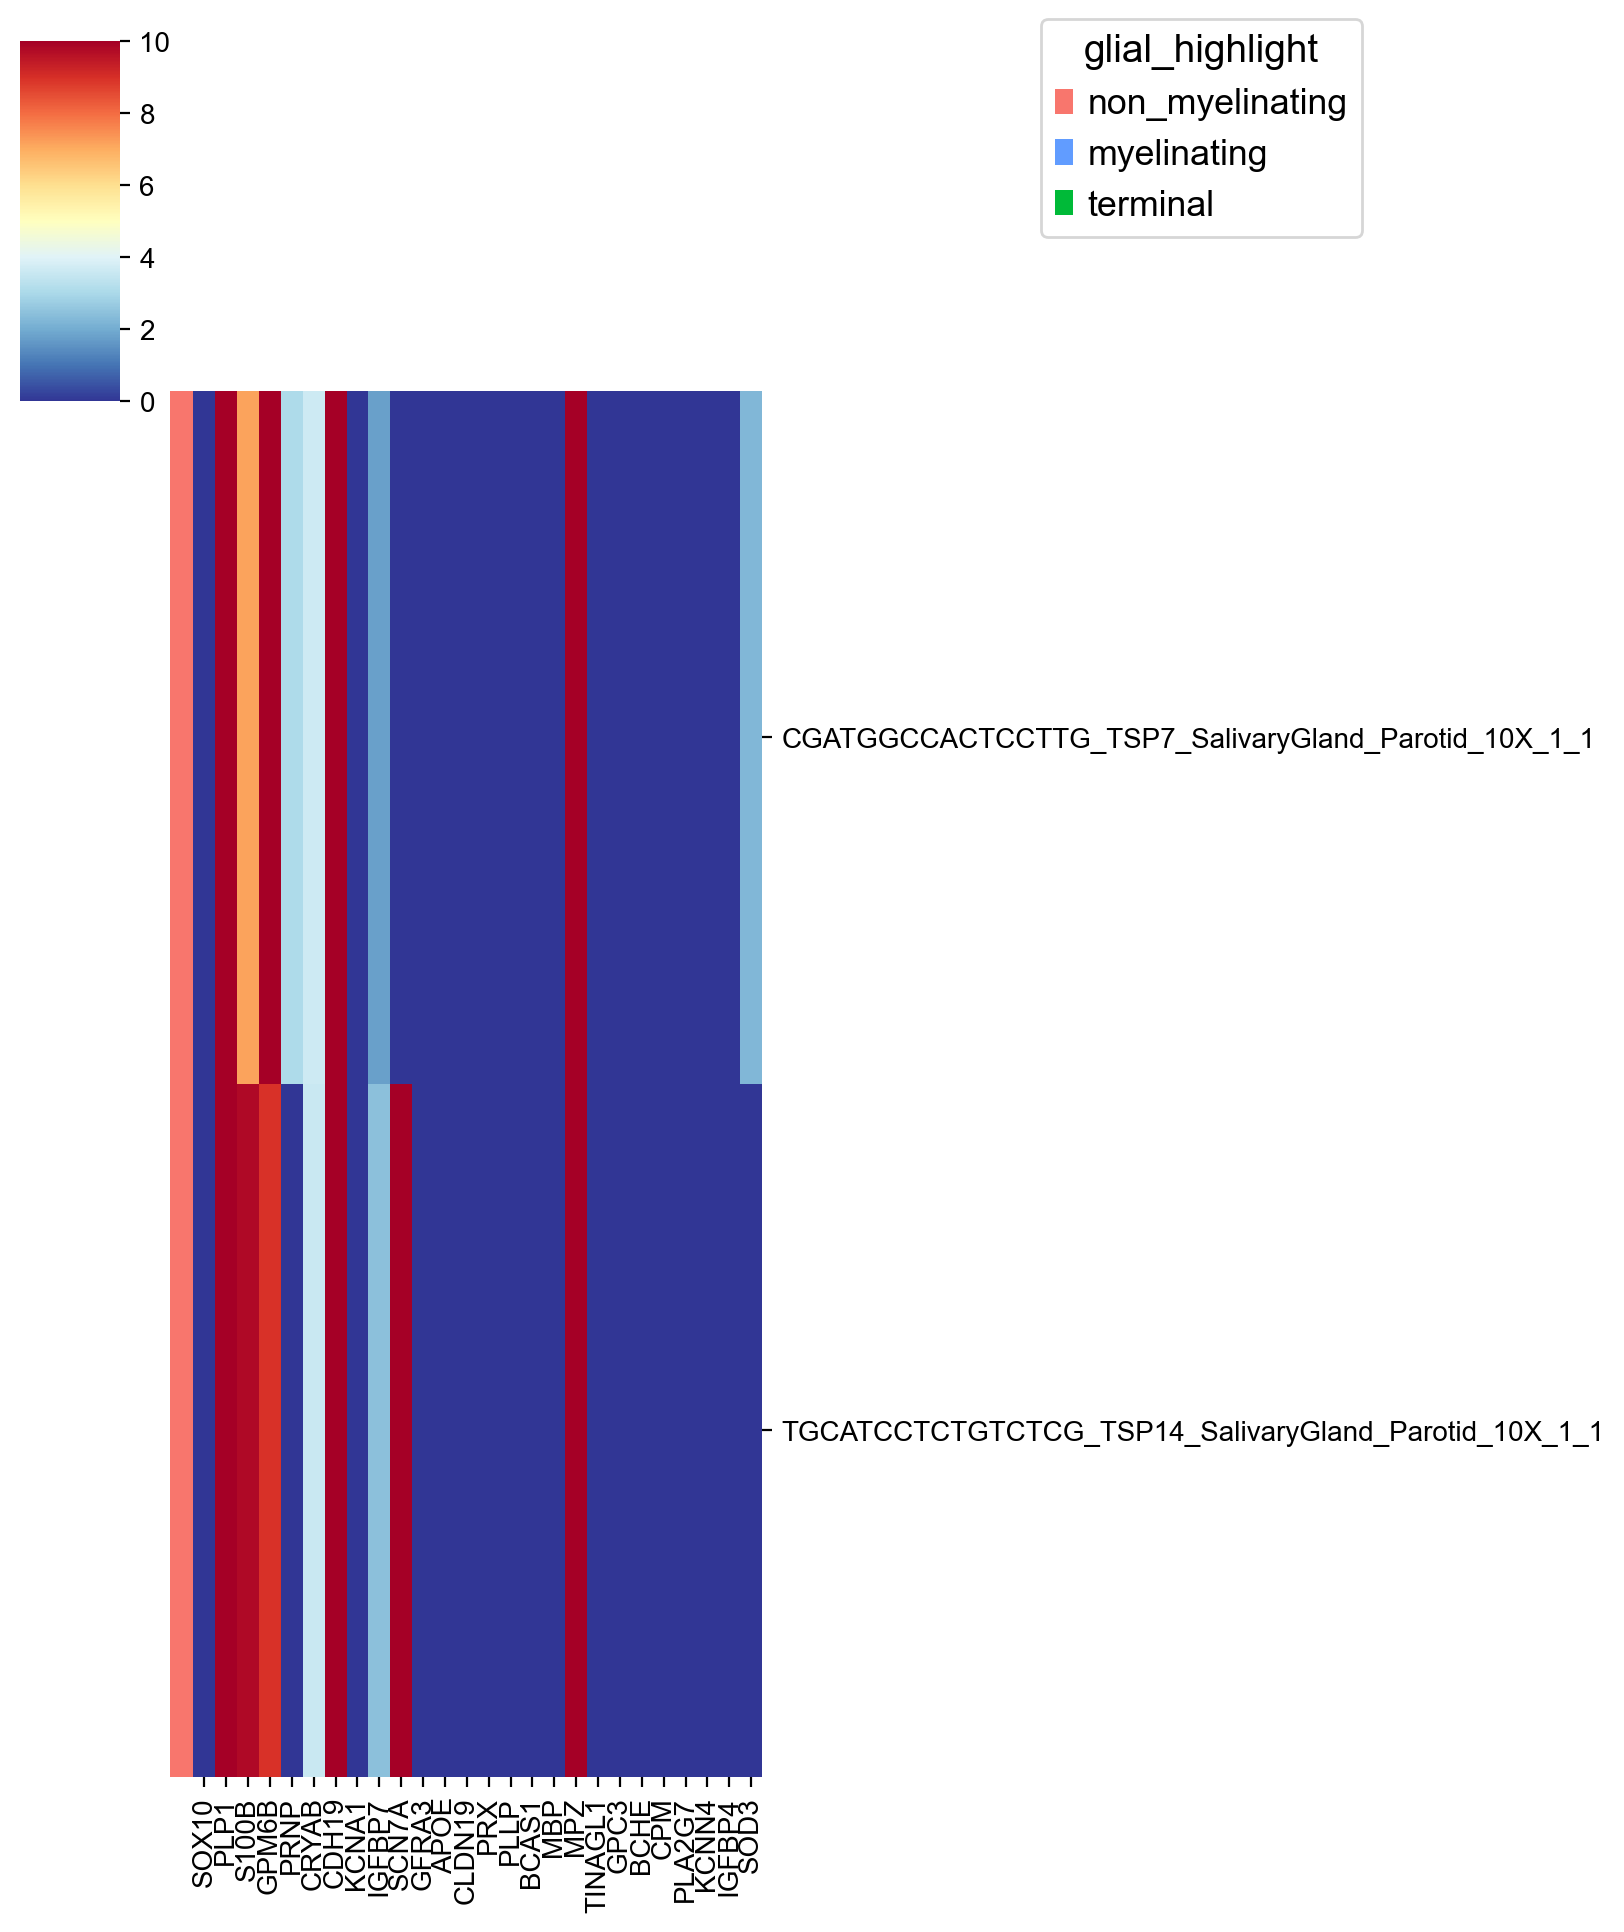

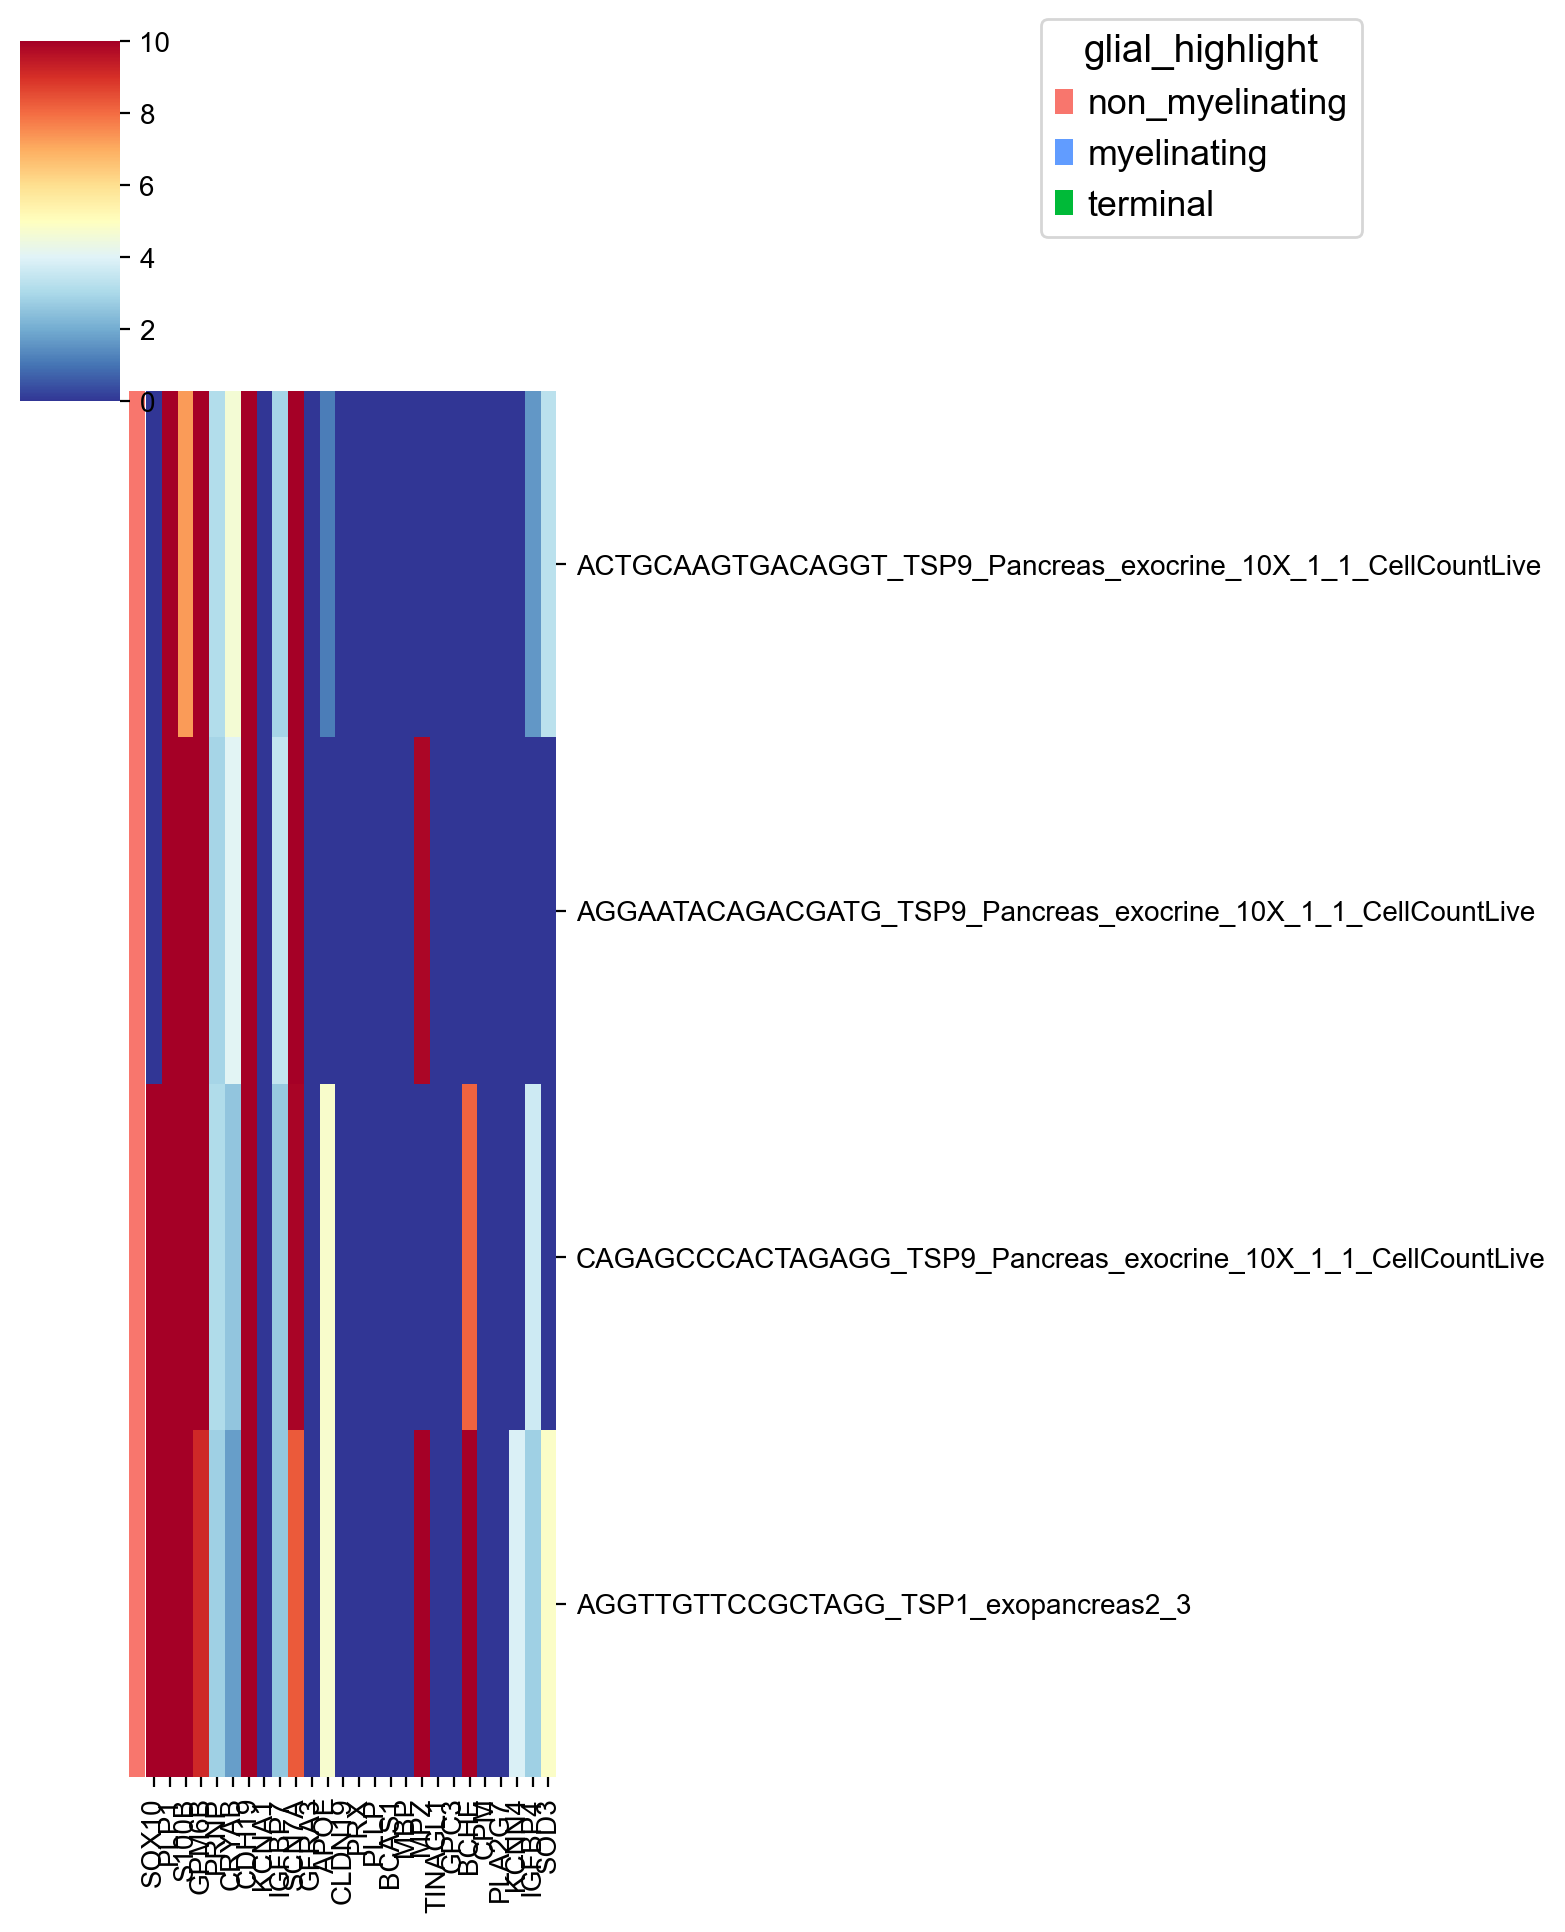

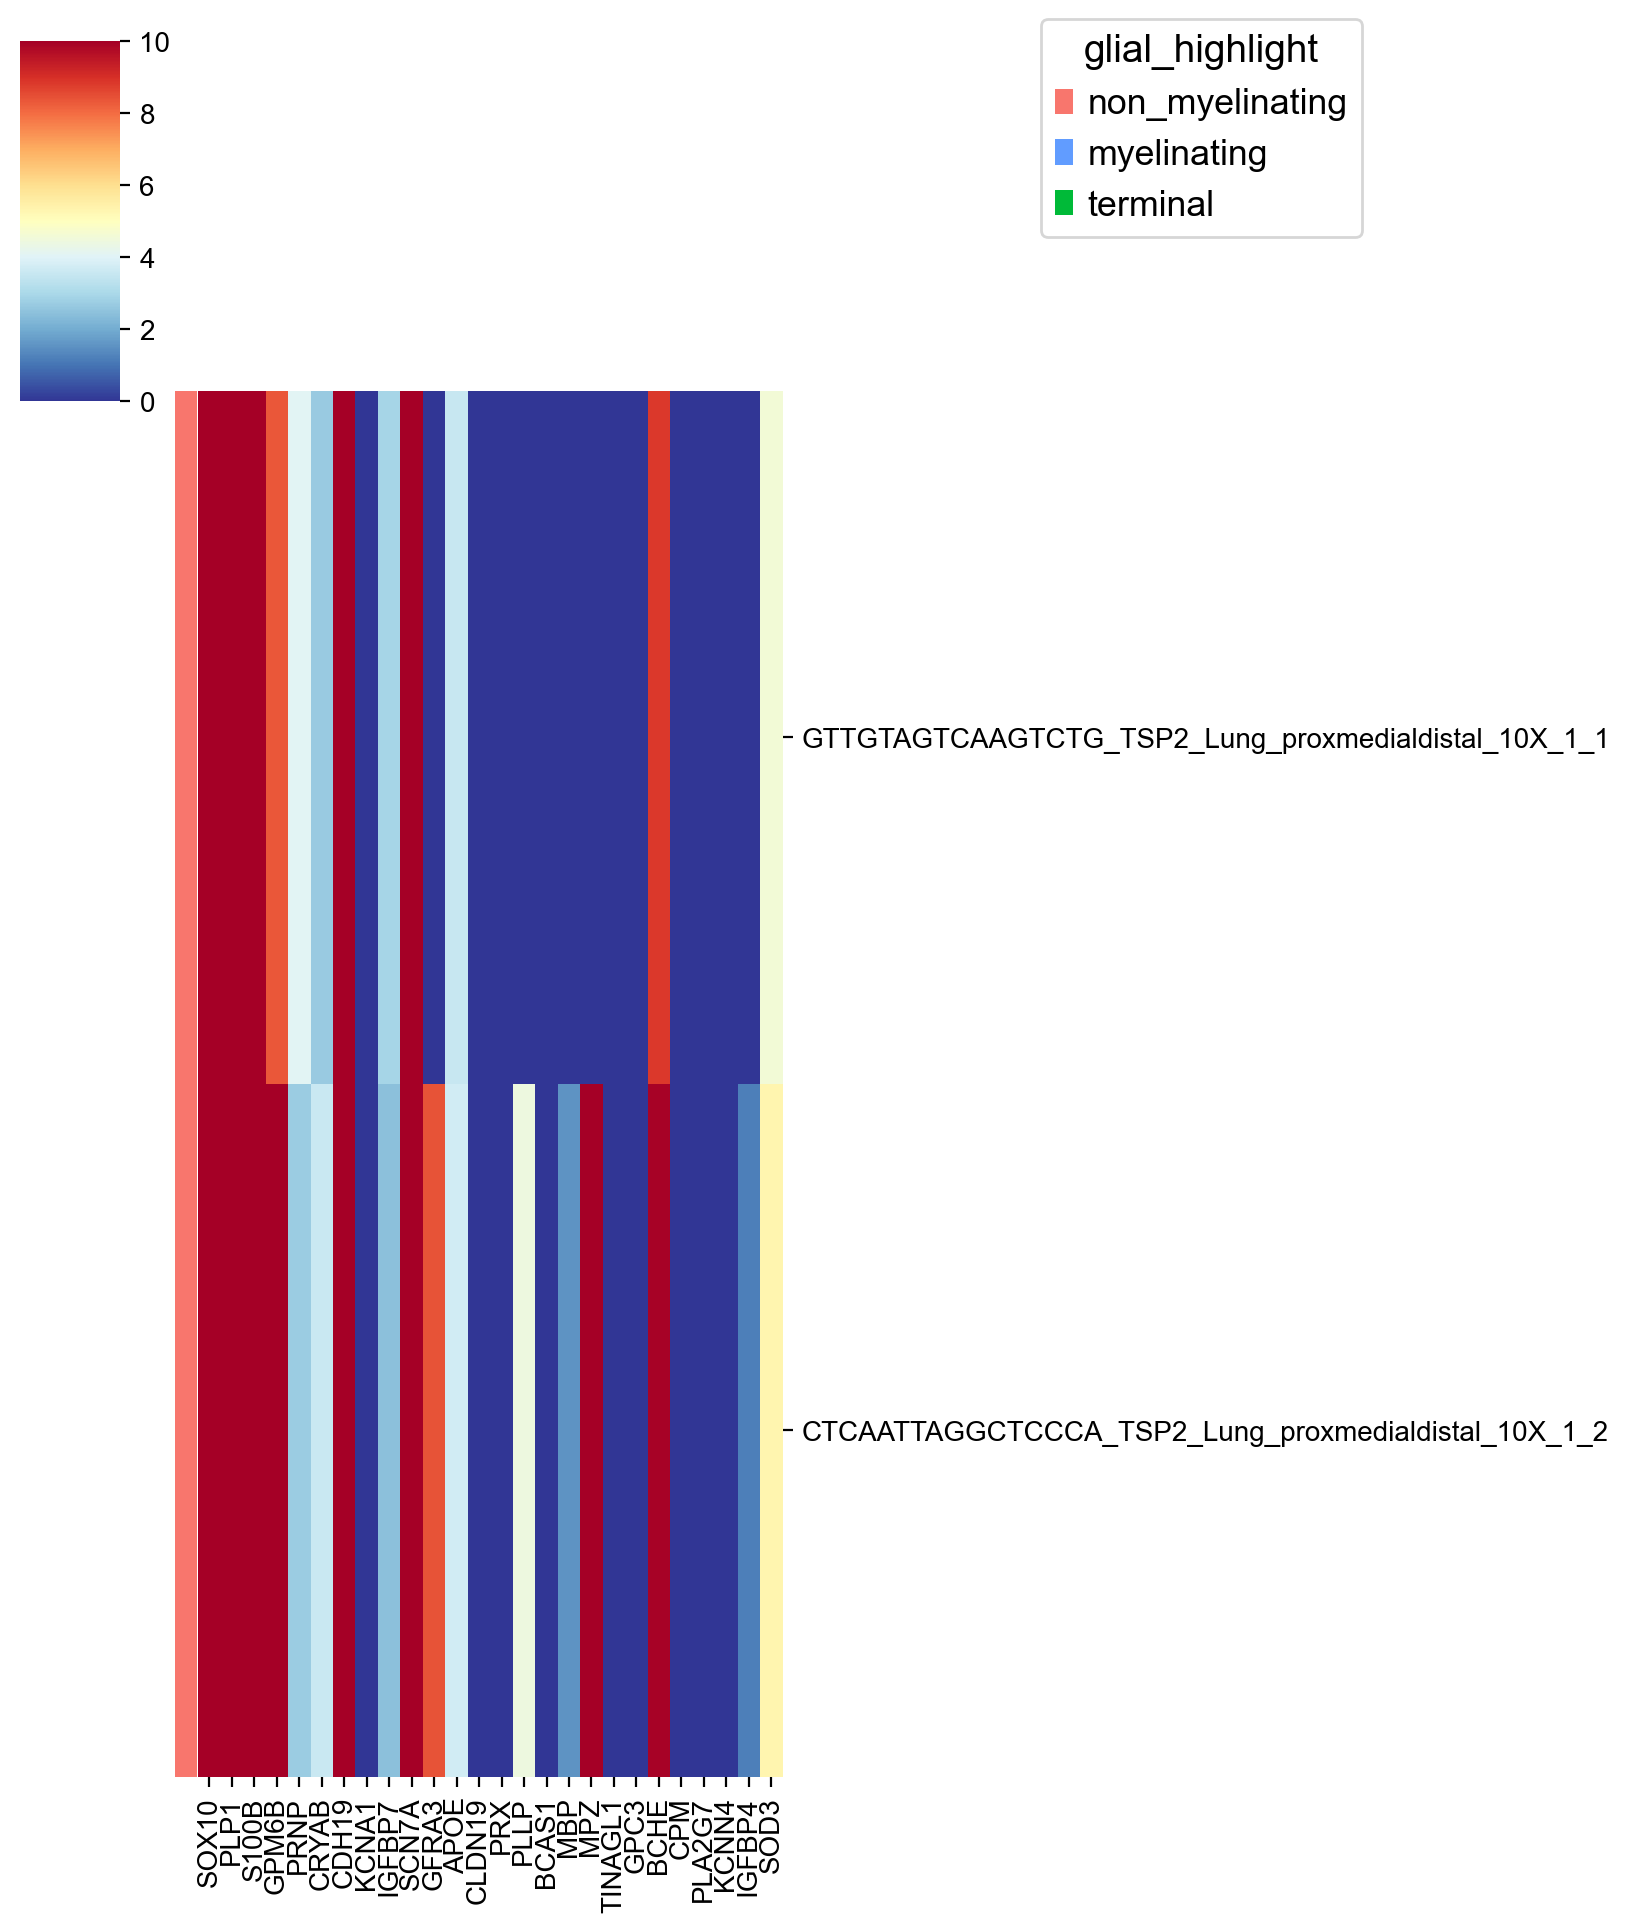

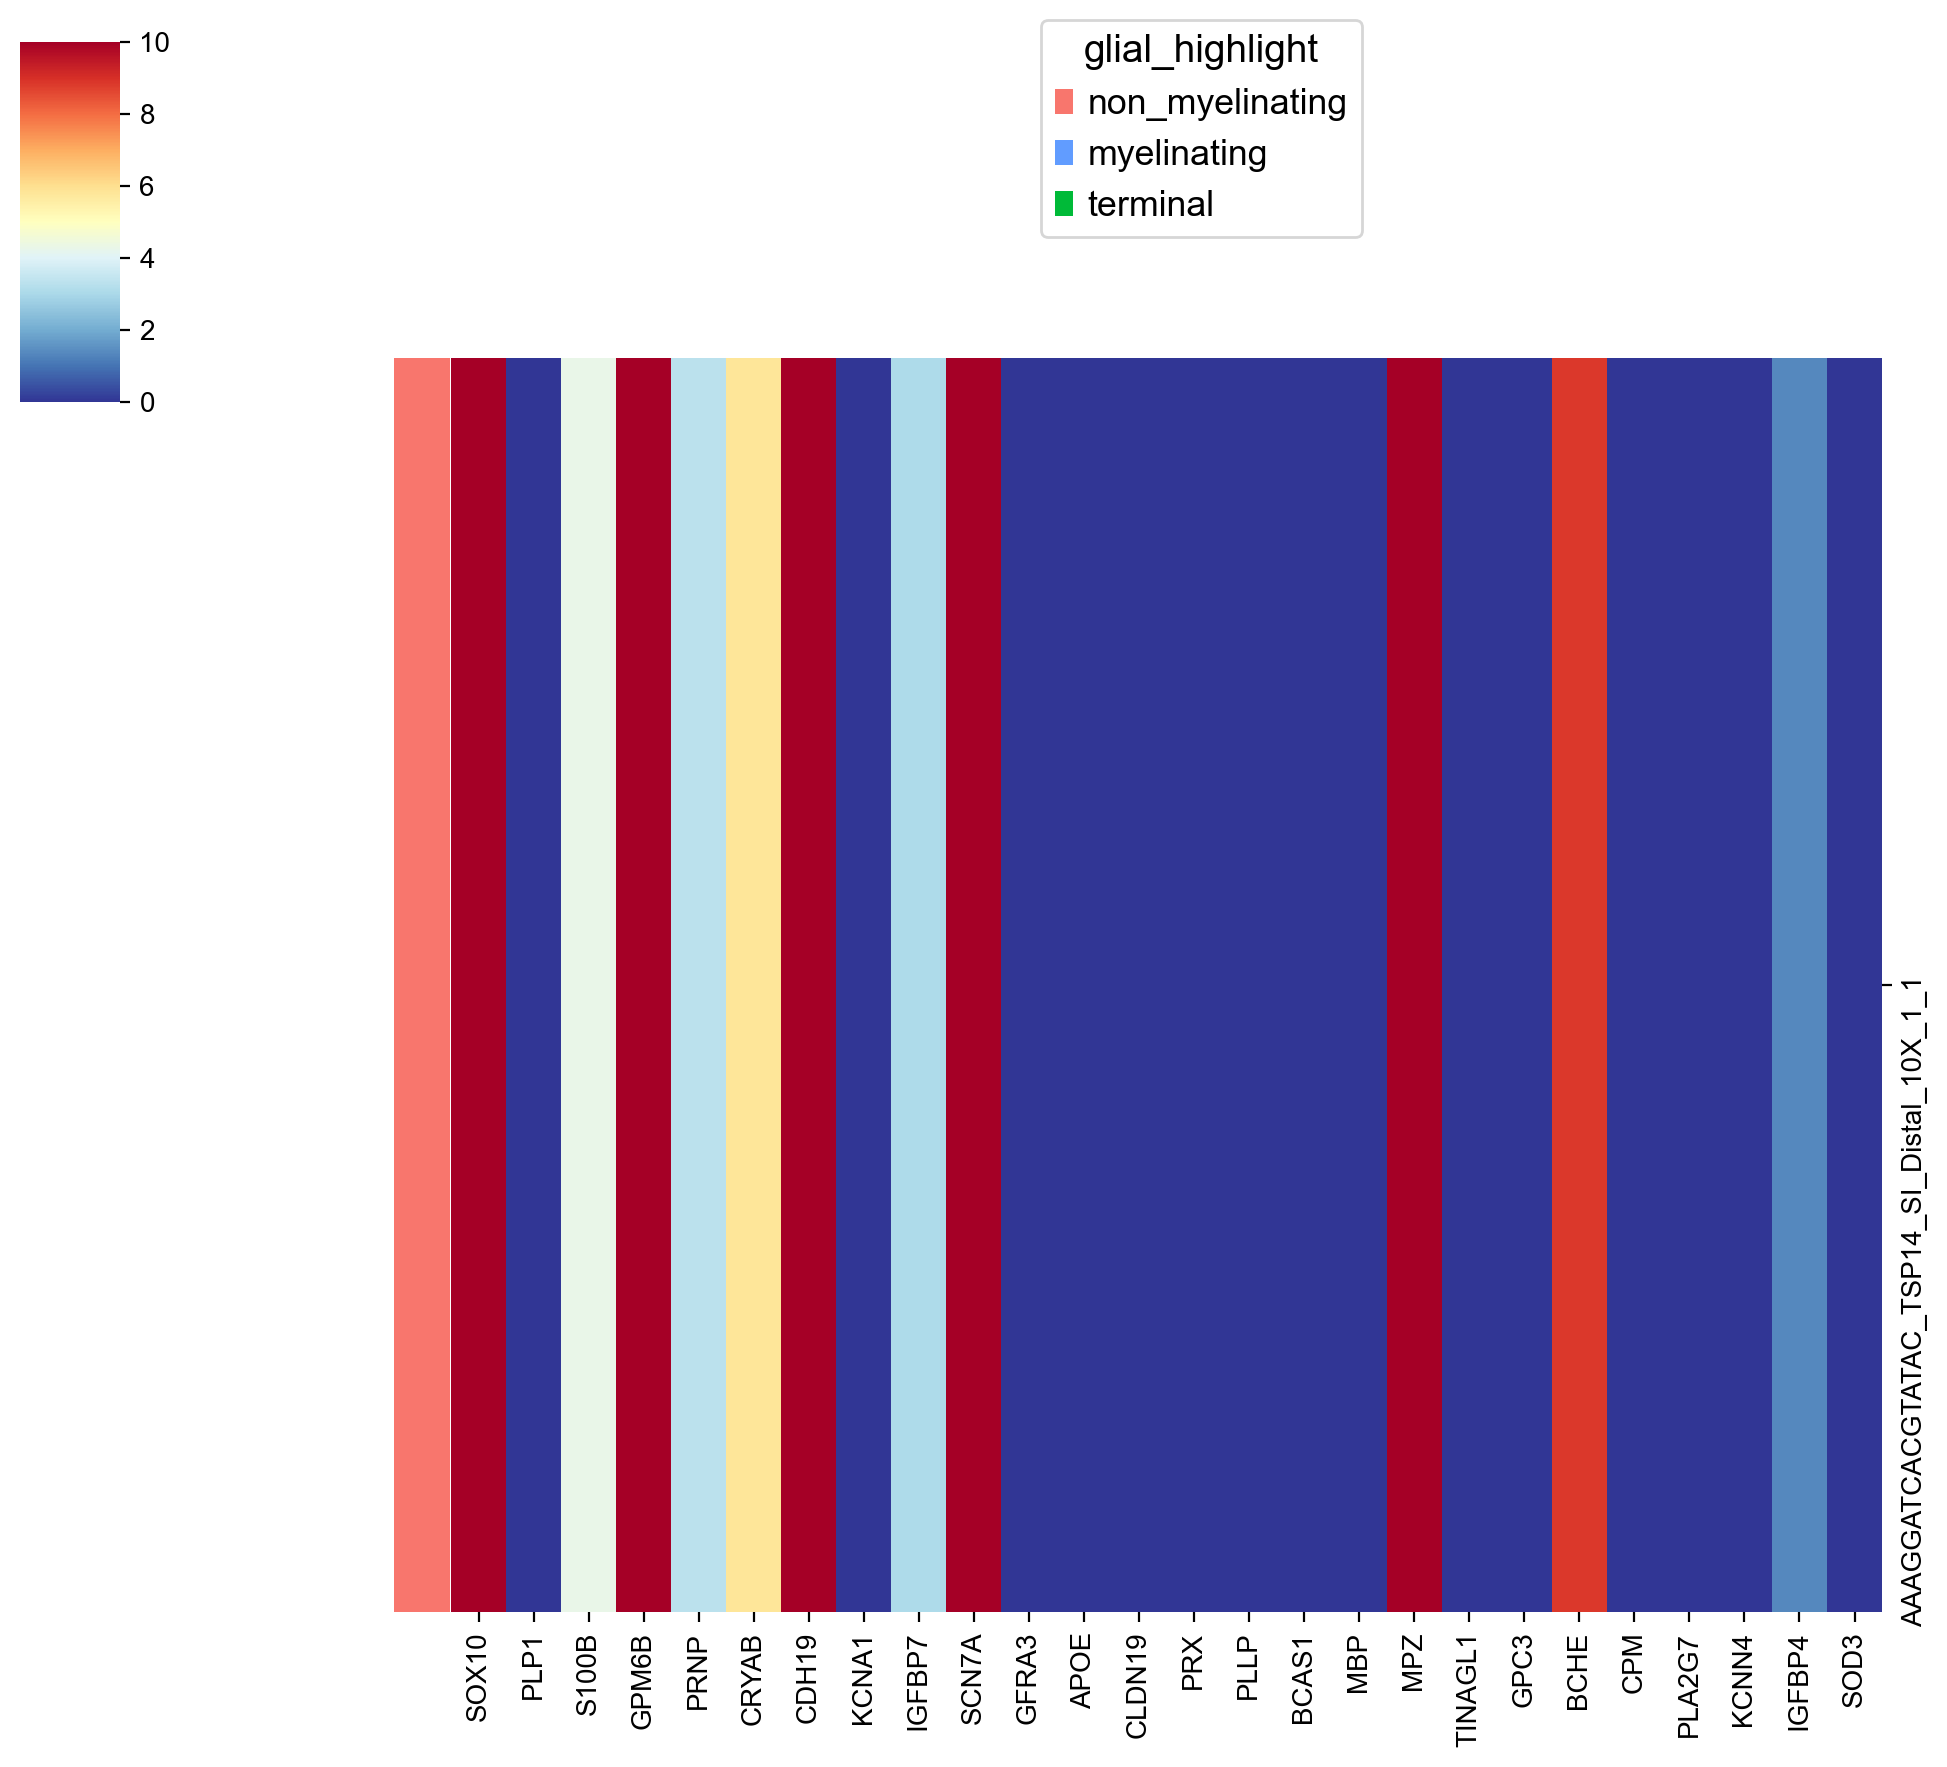

In [94]:
new_dict = {}
for tissue in ["Bladder", "Eye", "Thymus", "Tongue", "Prostate", "Salivary_Gland", "Pancreas", "Lung", "Small_Intestine"]:
    glial_col = snsHeatmap(adata, tissue)
    new_dict[tissue] = glial_col

In [95]:
barcode_col = []
class_col = []
tissue_col = []
for key in new_dict.keys():
    print(key)
    if not new_dict[key].empty:
        class_list = list(new_dict[key])
        class_list.reverse()
        barcode_list = list(new_dict[key].index)
        barcode_list.reverse()
        tissue_list = [key for i in class_list]
        tissue_list.reverse()
        class_col.extend(class_list)
        barcode_col.extend(barcode_list)
        tissue_col.extend(tissue_list)

Bladder
Eye
Thymus
Tongue
Prostate
Salivary_Gland
Pancreas
Lung
Small_Intestine


In [96]:
updated_table = pd.DataFrame()

In [97]:
updated_table['barcodes'] = barcode_col

In [98]:
updated_table['classes'] = class_col

In [99]:
updated_table['tissue'] = tissue_col

In [100]:
updated_table

barcodes          classes  \
0   TSP2_Bladder_NA_SS2_B114660_B111652_Stromal_P2...  non_myelinating   
1           GGGAAGTGTGGTCAAG_TSP14_Bladder_NA_10X_1_1  non_myelinating   
2           TCACTATCAGGATTCT_TSP14_Bladder_NA_10X_1_1  non_myelinating   
3                     CTAACTTGTAGGTTTC_TSP1_bladder_1  non_myelinating   
4                     GATCGTACAGTCAACT_TSP1_bladder_1  non_myelinating   
..                                                ...              ...   
69  AGGAATACAGACGATG_TSP9_Pancreas_exocrine_10X_1_...  non_myelinating   
70  ACTGCAAGTGACAGGT_TSP9_Pancreas_exocrine_10X_1_...  non_myelinating   
71  CTCAATTAGGCTCCCA_TSP2_Lung_proxmedialdistal_10...  non_myelinating   
72  GTTGTAGTCAAGTCTG_TSP2_Lung_proxmedialdistal_10...  non_myelinating   
73           AAAGGATCACGTATAC_TSP14_SI_Distal_10X_1_1  non_myelinating   

             tissue  
0           Bladder  
1           Bladder  
2           Bladder  
3           Bladder  
4           Bladder  
..              ...  
69         Pancreas  
70         Pancreas  
71             Lung  
72             Lung  
73  Small_Intestine  

[74 rows x 3 columns]

In [101]:
updated_table.to_csv("~/Downloads/ts_glial_updated_table.csv")